<a href="https://colab.research.google.com/github/SimplyDifficult/ML-for-Wireless/blob/main/22.EI_P%3D40_20_dim_user_case_BOGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
P_max = 40 #in dBm

In [2]:
var = 20
number_of_cells = 4

In [3]:
!sudo add-apt-repository ppa:octave/stable
!sudo apt update
!sudo apt install octave

 The latest version of GNU Octave built for all supported Ubuntu releases. GNU Octave is normally distributed with Ubuntu, this PPA is for you if you have a need to use a newer version of Octave than what you can already get from your installed version of Ubuntu.

Simply follow the instructions below to add this PPA to your system and install the octave package. If it's not that easy or you encounter any errors, contact the team and let us know.

Much credit goes to the Debian Octave Group who maintain the official Debian packages that this work is derived from. Without their efforts to bring Octave packaging to such a high level of quality in Debian and Debian derivatives, this PPA would not be here.
 More info: https://launchpad.net/~octave/+archive/ubuntu/stable
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:

In [4]:
!wget https://www.dropbox.com/s/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
!wget https://www.dropbox.com/s/d1ytzzfpxsrpbcv/main_bitchanged.m -O /content/main.m
!wget https://www.dropbox.com/s/v3y2xe56qodthnm/function_SE.m
!wget https://www.dropbox.com/s/5p0j4qdqist7ibm/main_individual_transmit_case_for_Test_phase_bitchanged.m -O /content/main_individual_transmit_case_for_Test_phase.m

--2021-10-29 19:48:35--  https://www.dropbox.com/s/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m [following]
--2021-10-29 19:48:36--  https://www.dropbox.com/s/raw/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc622c5cb36517188a830614e86e.dl.dropboxusercontent.com/cd/0/inline/BY8Z3sggaekZI7aGUVkrls5BWCVHPRcOSPYo4W0jLj72w9BesC7-sMlUPglN3wdC0xqiRRwIKO9eq3kBkxhiXnAAlSDFXOcgE7RUStPAeUFZ8g9ruvi820VViLIwc2QMjCa38GwqZ4D2oFPAe3Ys8R_v/file# [following]
--2021-10-29 19:48:36--  https://uc622c5cb36517188a830614e86e.dl.

In [5]:
!wget https://www.dropbox.com/s/utf73kdk09gjvsu/RR.mat
!wget https://www.dropbox.com/s/52gyqiq137mo2bb/SE.mat

--2021-10-29 19:48:41--  https://www.dropbox.com/s/utf73kdk09gjvsu/RR.mat
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/utf73kdk09gjvsu/RR.mat [following]
--2021-10-29 19:48:42--  https://www.dropbox.com/s/raw/utf73kdk09gjvsu/RR.mat
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc098a7fee8e80e293996e09d3ae.dl.dropboxusercontent.com/cd/0/inline/BY8zh7cGL0Rz1G3MWJ9yTzhNQsr6_d6OvAJCRJbZ08IFI4CoYFe2tkN3JlJ2jf7CY3XVR8xA-W6GMK35QXgfMI3VHWnIQxtliIxzdYvf76OXCfZph_1GqLzGqtia14hiwXHm-QfjMFVxoYJ1geOi80w3/file# [following]
--2021-10-29 19:48:42--  https://uc098a7fee8e80e293996e09d3ae.dl.dropboxusercontent.com/cd/0/inline/BY8zh7cGL0Rz1G3MWJ9yTzhNQsr6_d6OvAJCRJbZ08IFI4CoYFe2tkN3JlJ2jf7CY3XVR8xA-W6GMK35QXgfMI3VHWnIQxtliIxzdYvf76O

In [6]:
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
from scipy.optimize import minimize
import numpy as np
from scipy.io import loadmat, savemat
import numpy as np
from google.colab import files
import cv2
from scipy.optimize import dual_annealing

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
#### Objective function
import random
def objective(tr_array):
  tr_in_mW = np.power(10,tr_array/10.0)
  savemat("transmit.mat", {"transmit":(tr_in_mW)})
  !octave -W main.m
  SE = loadmat('SE.mat')
  return np.sum(SE["SE"])

In [9]:
#surrogate or approximation for the objective function
def surrogate(model, X):
	#catch any warning generated when making a prediction
	with catch_warnings():
		#ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

In [10]:
def EIacquisition(Xsamples, X, model):
  Xsamples = Xsamples[np.newaxis,:]
  yhat, _ = surrogate(model, X)
  best = max(yhat)
  mu, std = surrogate(model, Xsamples)
  mu = mu[:, 0]
  sigma = 0
  probs = (mu - best - sigma) * norm.cdf((mu - best - sigma)/(std+1e-10)) + std * norm.pdf((mu - best - sigma)/(std+1e-10))
  return -probs[0]

In [11]:
#optimize the acquisition function
def opt_acquisition(X, y, model):
  #Do it 5 times
  r_min, r_max = -31.0, P_max  
  bounds = []
  for ti in range(var):
    bounds = bounds + [[r_min, r_max]]
  min_result = 9999999999999.0
  min_answer = 0
  
  for i in range(1):
    result = dual_annealing(EIacquisition, bounds, args=(X,model))
    if(result.fun<min_result):
      min_result = result.fun
      min_answer = result['x']    
  return min_answer

In [12]:
import random
def objective_FPA(tr_array):
  tr_in_mW = np.power(10,tr_array/10.0)
  savemat("transmit.mat", {"transmit":(tr_in_mW)})
  !octave -W /content/main_individual_transmit_case_for_Test_phase.m
  SE = loadmat('SE.mat')
  return np.sum(SE["SE"])

In [13]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [14]:
X = np.load("/content/drive/MyDrive/trainingx_BOGP_EI_P=40.npy")
y = np.load("/content/drive/MyDrive/trainingy_BOGP_EI_P=40.npy")
y_FPA = np.load("/content/drive/MyDrive/grad_trainingyFPA_BOGP_EI_P=40.npy")

x_next is [ -3.25353394 -28.47528574   0.34859757  30.47851373   0.30811816
  36.62455822  -0.40618495  17.89797758   5.50688504  39.22896729
  -0.39749396 -24.37273952  12.19015425  -7.61007944 -23.82199138
  21.96873861 -13.2363684  -15.74615557 -17.26953036  13.74121274]
f()=0.215341, actual=24.646
0


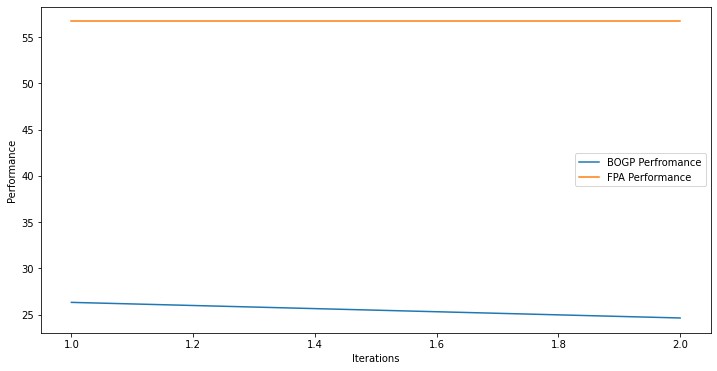

x_next is [ 39.99956557  39.99975535  39.99995544 -30.99882629  39.99875221
 -30.99971718  39.99920964 -30.99932255 -30.9997295  -30.99946968
  39.99935906  39.99838908 -30.99918849  39.9989894   39.99764897
 -30.99975593  39.99921216  39.99949553  39.99930756 -30.99946497]
f()=25.460620, actual=40.758
1


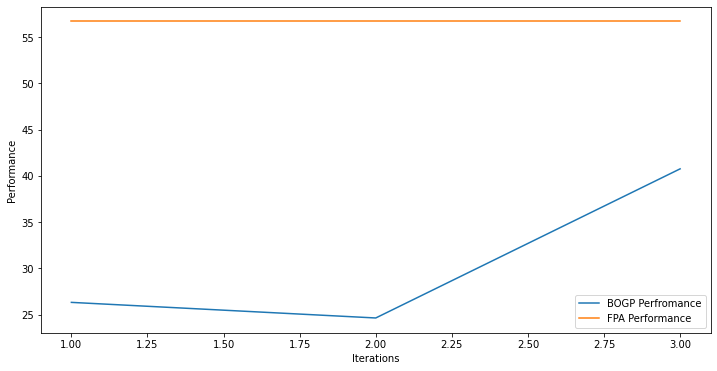

x_next is [ 39.99994729  39.99990207  39.99968552 -30.9998027   39.99990802
 -30.99977259  39.99999765 -30.99950674 -30.99991334 -30.99992812
  39.99988827  39.9999348  -30.99997696  39.99974017  39.99999783
 -30.99978806  39.99969023  39.9997532   39.99987836 -30.99998678]
f()=29.723407, actual=40.758
2


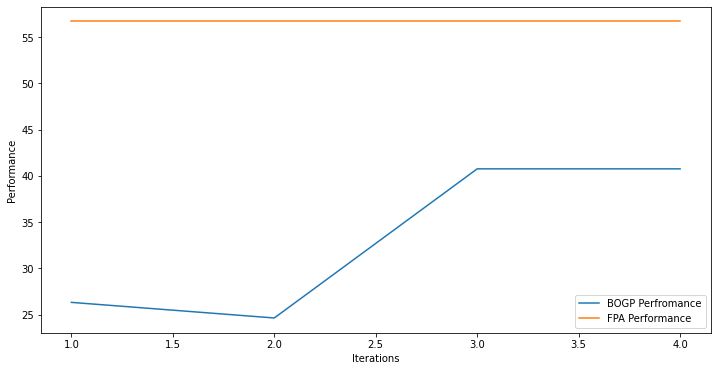

x_next is [ 39.99776926  39.9962862   39.97641561 -30.98869082  39.97326586
  39.992373    39.99232375 -30.96508118 -30.95730162  39.99824976
  39.98387571  39.99588056 -30.99504989  39.99214124  39.98911305
  39.98714259  39.98787554  39.98769272  39.9835043  -30.99630977]
f()=39.326173, actual=45.494
3


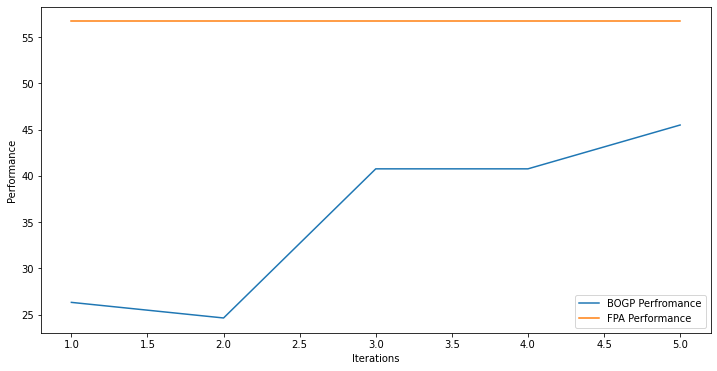

x_next is [ 39.99792116  39.99999974  39.99999958 -30.9119021   39.98459733
  39.99999971  39.99754035 -30.99999844  39.99999971  39.99999963
  39.94864372  39.93964891 -30.99568411  39.99999958  39.98935394
  39.99999971  39.95812154  39.99611089  39.99999966  39.99999971]
f()=42.234669, actual=49.927
4


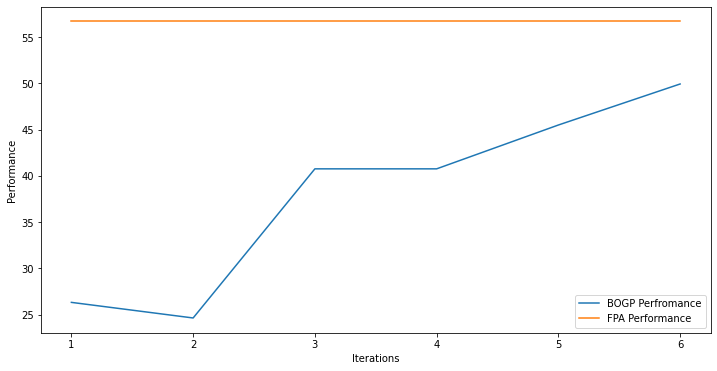

x_next is [ 39.89002753  39.99687981  39.99500126  39.90452308  39.95402419
  39.99481889  39.98736051 -30.92307031  39.80237116  39.97425298
  39.99483374  39.95133157 -30.98074927  39.99551189  39.99485696
  39.99752198  39.98087267  39.99956491  39.96809177  39.97868237]
f()=48.206813, actual=52.503
5


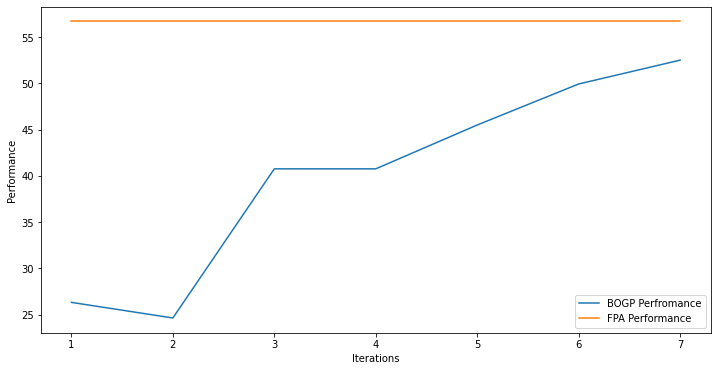

x_next is [ 39.96141612  39.90769059  39.96941689  39.98282924  39.98239372
  39.97577164  39.96047106  39.95543385  39.96621051  39.93202296
  39.95984723  39.96366538 -30.85809064  39.99765889  39.855356
  39.9874273   39.96956101  39.98871758  39.93740136  39.9902131 ]
f()=50.234311, actual=53.804
6


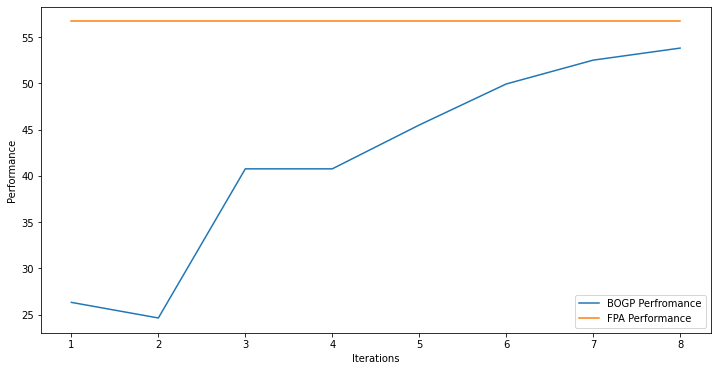

x_next is [39.93799846 39.91269101 39.96355059 39.99842611 39.79994973 39.90302291
 39.8556732  39.54105448 39.96791257 39.84808685 39.89350978 39.80444469
 39.80733232 39.98943221 39.94032022 39.75792309 39.8940039  39.98443212
 39.95088704 39.93695787]
f()=51.332587, actual=56.610
7


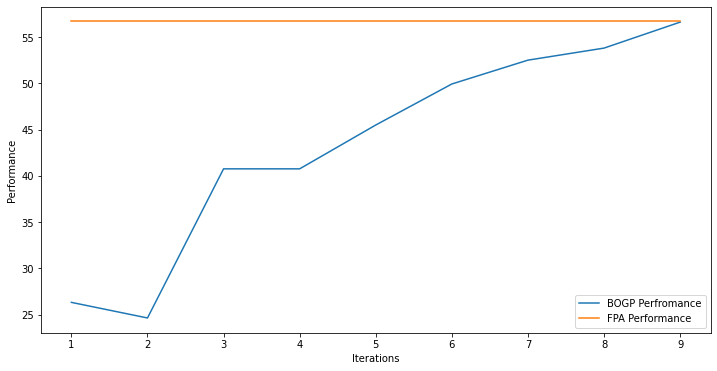

x_next is [ 39.93811698  39.90687408  39.99701283  39.7838422   39.63799529
  39.87437664  39.98778913  39.48919417  39.82808091 -30.8226103
  39.97437446  39.97861225  39.88816533  39.98713313  39.91650676
  39.98338977  39.9084618   39.95495714  39.96758064  39.80425472]
f()=54.865727, actual=57.344
8


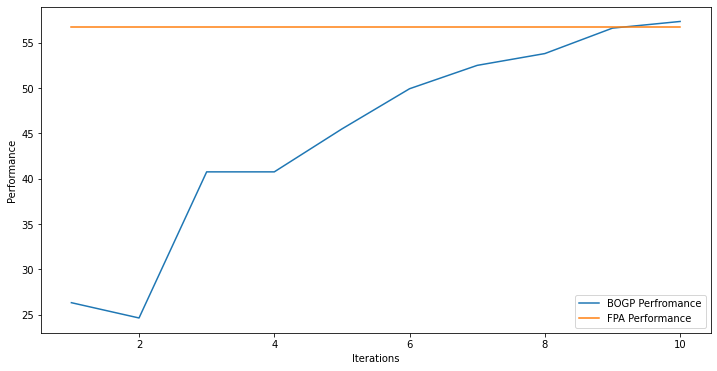

x_next is [ 39.93737919  39.72862324  39.85327054  39.8077532   39.58803906
  39.67074823 -30.79620982  39.57225502  39.89566795 -29.89593149
  39.86927913  39.92016844  39.5400352   39.96224932  39.92618474
  39.98274618  39.57207992  39.74285144  39.90486516  39.77190164]
f()=54.128284, actual=55.973
9


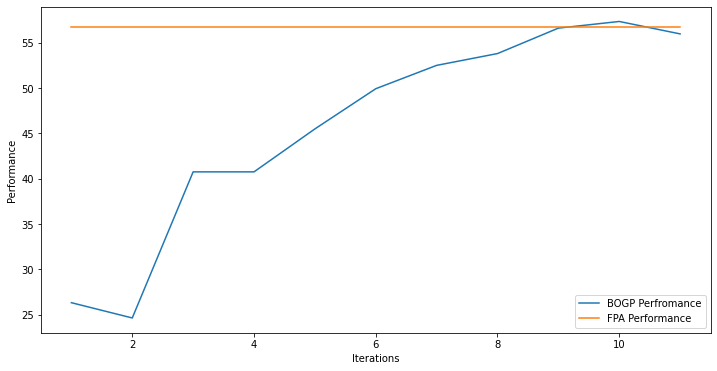

x_next is [-30.60662765  39.85896973  39.99727163  39.49615974  39.92185052
  39.95363968  39.88590156  39.33015913  39.66510679 -30.52390157
  39.95388262  39.97726719  39.36357532  39.90392327  39.97374485
  39.80046159  39.87453756  39.6604849   39.9220242   39.78823287]
f()=53.939941, actual=53.880
10


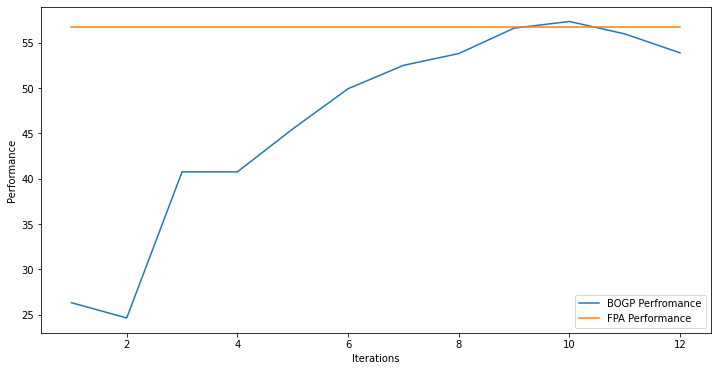

x_next is [ 39.6283571   39.92356465  39.75904165  39.40491738  38.9749662
  39.4086574   39.87382056  38.48170382  39.81430199 -30.52237496
  39.72101355  39.78883594  39.69219337  39.68270938  39.95173572
  38.95257048  39.77618364  39.43840114 -30.68878764  39.7299043 ]
f()=53.674146, actual=54.990
11


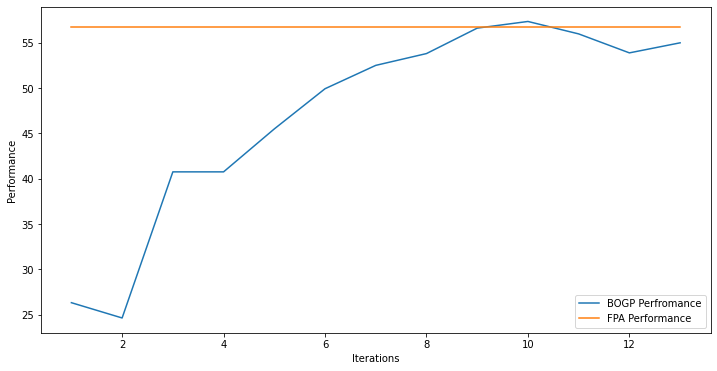

x_next is [ 39.40778521  39.61770905  39.85339339  39.94600417  39.35449454
  39.92681536  39.3007512   38.68893344  39.93661143 -30.92113007
 -30.53086064  38.94191887  39.98554073  39.85073578  39.95940866
  39.64619731  39.71215303  39.41221299  39.23802303  39.96389458]
f()=53.785052, actual=57.332
12


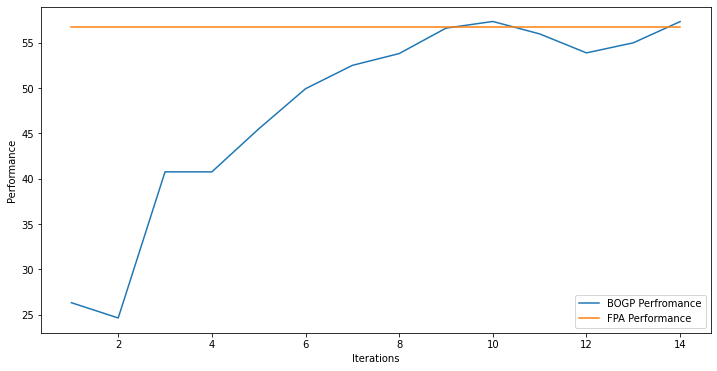

x_next is [ 39.78392829  39.49402979  39.93415859  39.93584394  39.27768955
  39.10904131  38.77908382  39.70549412 -30.8755206  -28.61719174
 -22.99281101  39.37340197  39.42785877  39.92626234  39.00861381
  39.64222176  39.72487868  39.96851915  38.3542881   39.91562599]
f()=54.891576, actual=57.151
13


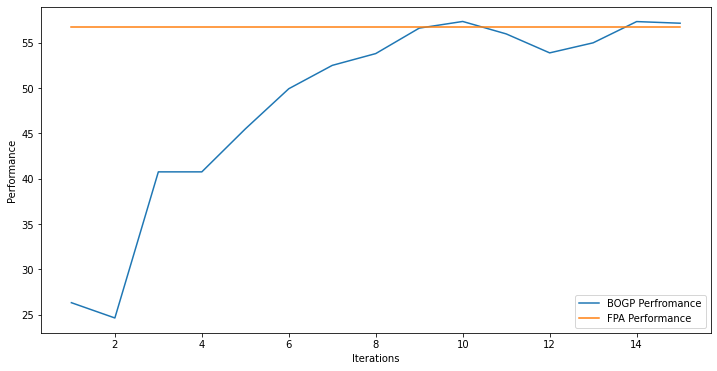

x_next is [ 39.83196578  39.39368555  39.78275524  39.30037673  39.99581462
  39.08295615  38.90313204  39.85334628  30.62646529 -30.67764509
 -28.38186242  39.34787195  37.95620985  38.15014176  39.5787937
  39.0183776   39.25544195  38.13695847  39.16474876  38.85136972]
f()=56.980044, actual=56.816
14


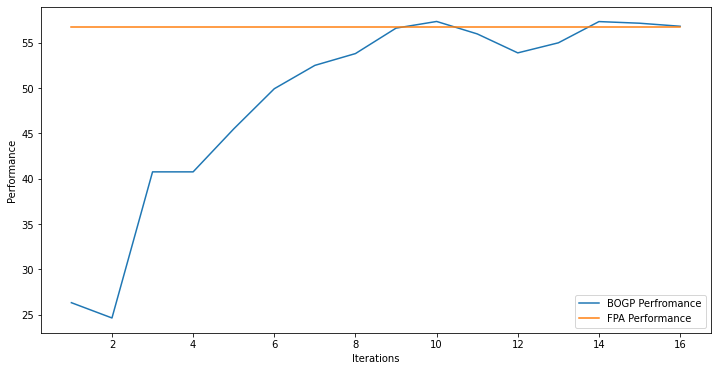

x_next is [ 38.58153755  39.08992566  39.46818689  36.11323097  39.52583844
  38.33168839  33.83209995  32.40017355 -29.48009506 -19.55299969
 -29.75187561  39.17881871  38.43997192  38.95038831  36.7199557
  38.88850913 -30.78574267  38.83309355  39.8079919   35.54795428]
f()=52.101026, actual=53.516
15


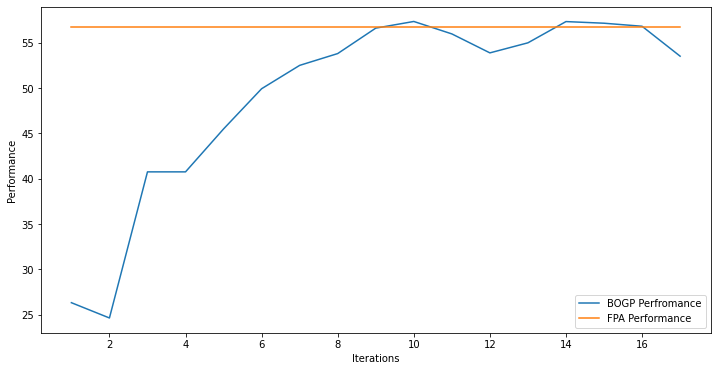

x_next is [ 39.90994429  37.67719454  37.29926137  36.76963538 -30.57086997
  37.85588183  36.36517342  35.81721642  37.42668299 -19.28888434
   2.63255909  39.73197219  37.88607704  39.72553515  39.30670109
  39.87122559  38.71016392  38.96150143  36.64206156  39.76954249]
f()=53.813557, actual=54.873
16


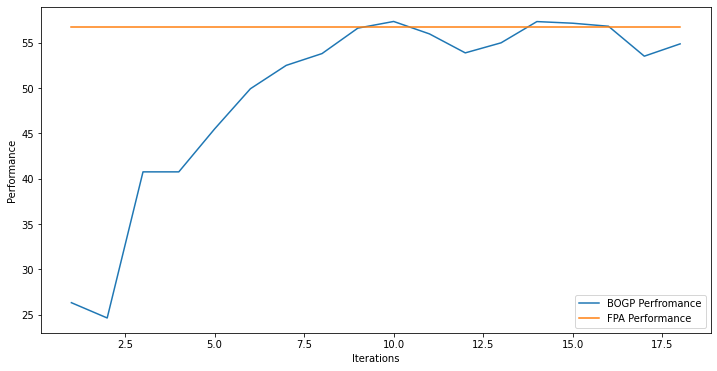

x_next is [ 39.18951367  36.04081685  34.07426362  37.6346866   36.30963513
 -29.46349715  30.04971968  36.31666317  35.75473088 -29.72732653
 -10.74360409 -25.90006351  36.58247543  38.41983065  39.92485011
  38.97817382  37.5314747   35.68309361  39.82396932  34.53686657]
f()=49.445677, actual=50.546
17


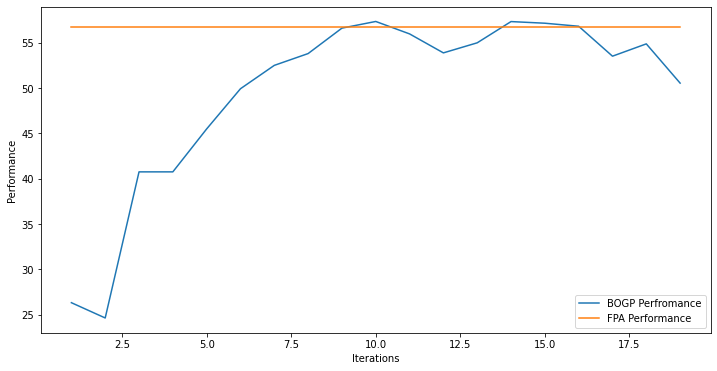

x_next is [ 37.86555667  36.51924802  37.40078817  35.16449997  36.92040004
  36.96737082  36.78340763  37.49222545 -24.58458022 -21.17512177
  10.89848445  25.50226869  35.4467243   36.37302903  39.66542266
  35.37595179  37.73485317  37.7564419   28.96807876  39.92481805]
f()=54.532144, actual=58.754
18


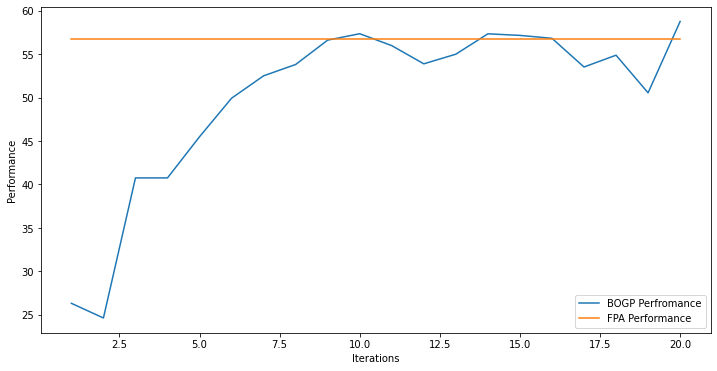

x_next is [ 39.99956449  39.9946856   39.99785798  39.98693808  39.99940329
  39.99977307  39.9994847   39.97861702 -30.99981716 -20.11392795
  39.98732284  -9.54797085  39.99659855  39.9991      39.99743688
  39.99175517  39.99929056  39.99917752  39.99075622  39.99817092]
f()=60.916398, actual=56.314
19


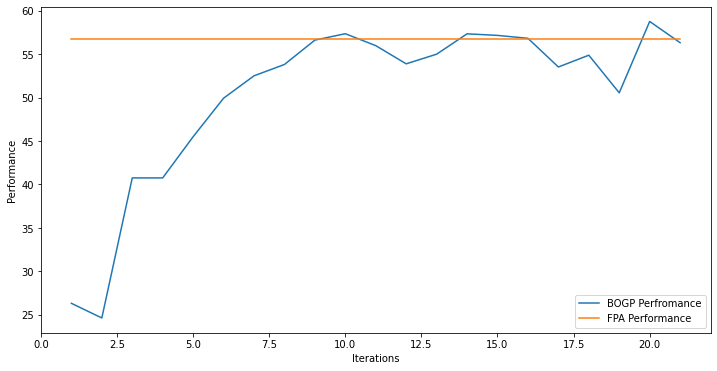

x_next is [ 39.9992465   39.99854676  39.99949208  39.98872068  39.99941616
  39.99457574  36.29625727  31.21602638 -28.21088808  -9.39947912
  25.03261997  39.99756406  39.99692037  39.99763012  39.99836046
  39.99760439  39.99147154  39.99882707  25.78042932  39.99811412]
f()=60.076527, actual=57.895
20


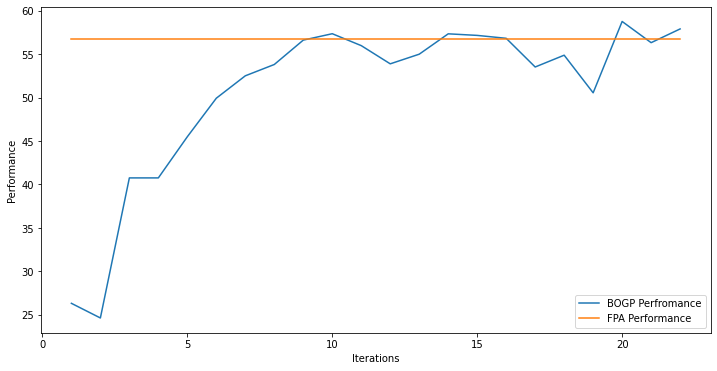

x_next is [ 39.99944758 -22.87246475  39.99788653  26.00197881  39.99852666
  39.99989285  39.99914653  39.99731898  -4.59510913 -26.96437
  12.15845813  32.64726157  39.99951477  39.99987892  39.99958332
  39.99984954  39.99983752  39.99859291  39.99342136  39.99993645]
f()=55.931087, actual=55.572
21


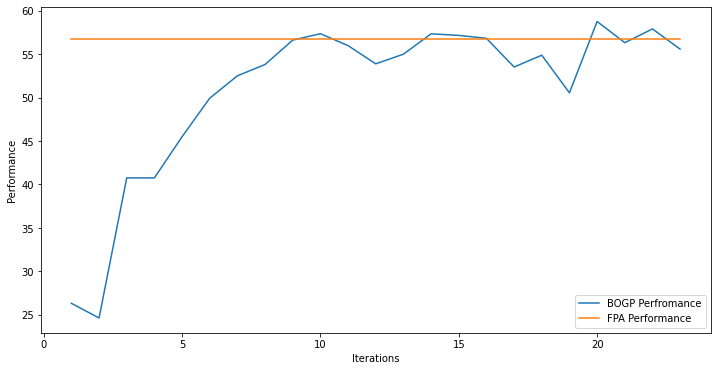

x_next is [ 39.99929699  39.99973151 -25.00656539  31.7369664   39.99980079
  39.99985344  39.99599115  39.99688218   1.06624845 -23.57790702
  10.05590308  30.79986555  39.99641007  39.99932914  39.99947374
  39.99849258  39.99844616  39.99970683  39.99154378  39.99998391]
f()=55.526786, actual=57.628
22


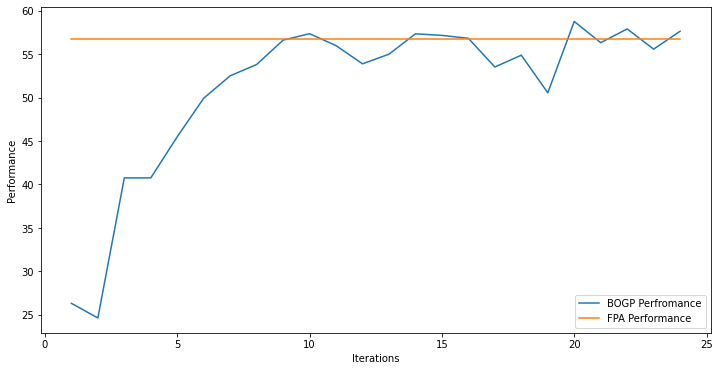

x_next is [ 39.99875173  39.99915068  29.32991641  32.40799439  39.99863615
  39.99989557  39.99870605  39.99840208  -7.86455317 -20.08011967
   9.5102408   25.03128284  39.99984194  39.99961278  39.99905606
  -5.38364366  39.99845391  39.99938704  36.14260097  39.9989138 ]
f()=58.213924, actual=55.638
23


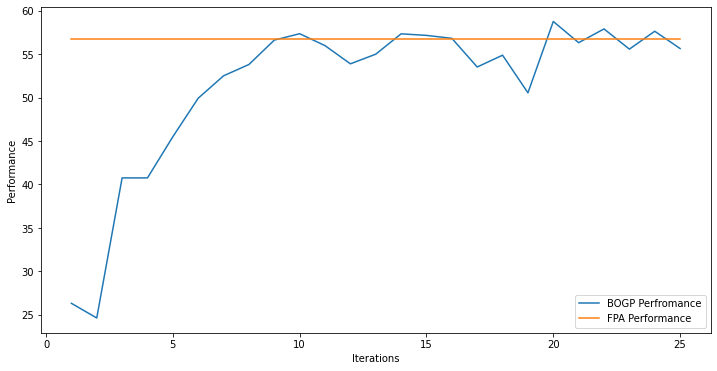

x_next is [ 39.9969612   39.99015319  30.42127618  21.35620544  39.98793381
  39.9993126   36.97094014  39.99741613 -16.21924886 -26.37897686
   9.26946228  22.3843244   37.79752453  39.99888758  39.99869111
  39.99805064  39.99195793  39.99870843  27.8033146   39.99996834]
f()=59.441470, actual=56.034
24


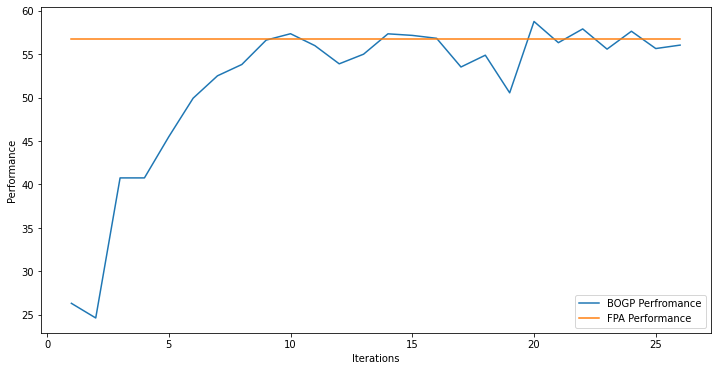

x_next is [ 39.99930319  32.42385845  23.24755043  39.99956971  39.71632091
  39.99217616  39.99933352  39.99893686 -26.60291742 -26.04044561
  19.88158683  39.99796655  29.19887662 -17.96302727  39.99992717
  39.99954642  39.99954225  39.99856217  39.9997706   39.99882807]
f()=57.474498, actual=51.295
25


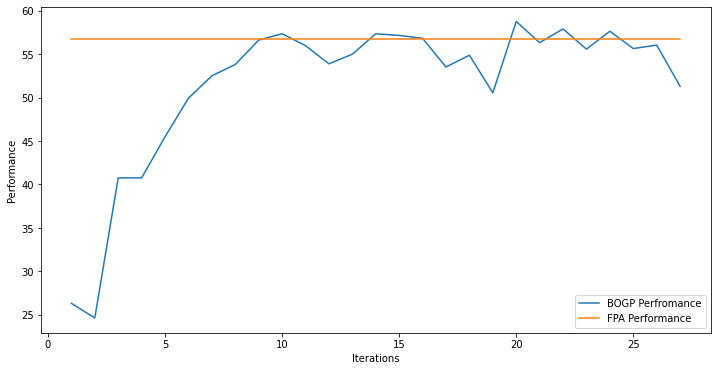

x_next is [ 38.71193071  27.96704069  34.00147062  39.99939429  31.66083962
  33.16877099  37.89228048  36.04256155 -23.46506255 -17.59387044
   9.7067923   25.24373428  27.7528666   39.99951858  39.99932946
  38.72727197  33.55937533  39.99940259  36.19995887  39.99846419]
f()=59.903255, actual=51.233
26


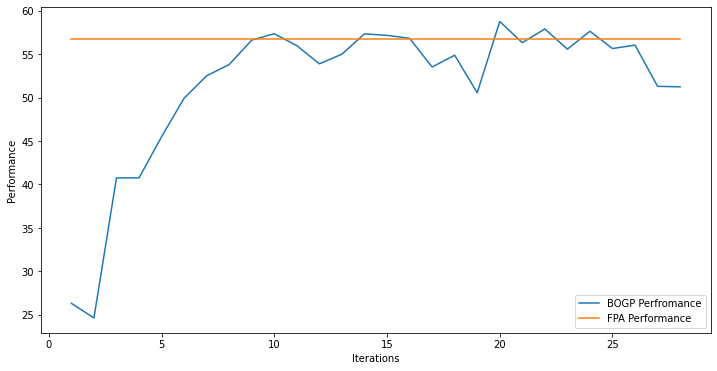

x_next is [ 31.98268297  39.99991564  39.99992313  39.9996873   39.99996671
  39.99976618  32.17738909  39.99998758 -30.7614656  -30.9997924
   8.21750991  27.04146214  39.99996552  30.42903406  39.99989231
  27.2612089   39.99985865  -0.69982602   9.34796523  39.99935397]
f()=63.897018, actual=47.604
27


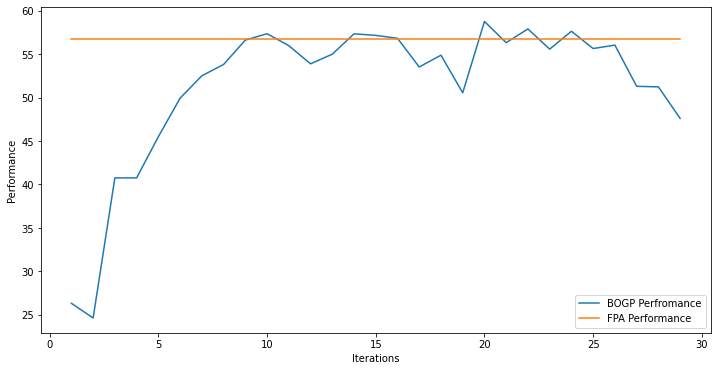

x_next is [ 40.  40.  40.  40.  40.  40.  40.  40.  40. -31.  40.  40.  40.  40.
  40.  40.  40.  40.  40.  40.]
f()=58.189942, actual=57.349
28


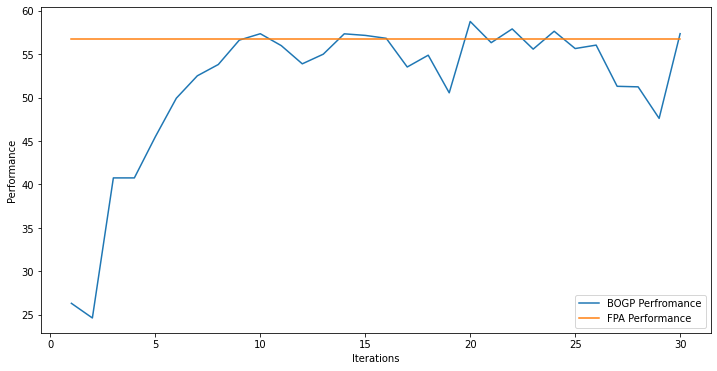

x_next is [ 40.          40.         -30.99987574  40.          40.
  40.          40.          40.          39.99999999 -30.99999992
  39.99988135  40.          40.          40.          40.
  39.99999999  40.          40.          40.          40.        ]
f()=57.412270, actual=57.105
29


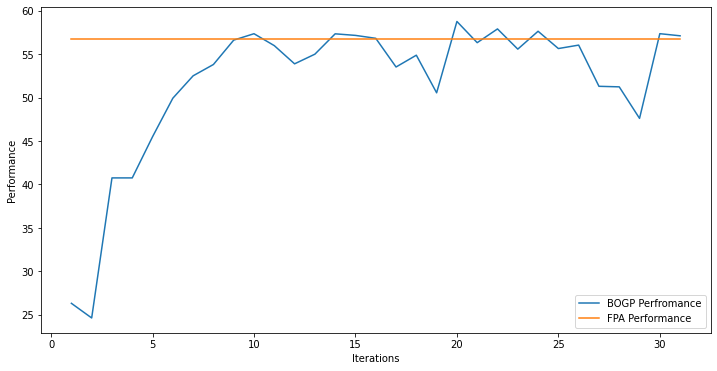

x_next is [ 40.          40.          39.99999124  39.999951    40.
  40.          40.          40.          39.9999999  -30.99971722
  40.          40.          40.          40.          40.
  39.99999998  39.99999999  40.          40.          40.        ]
f()=57.909683, actual=57.349
30


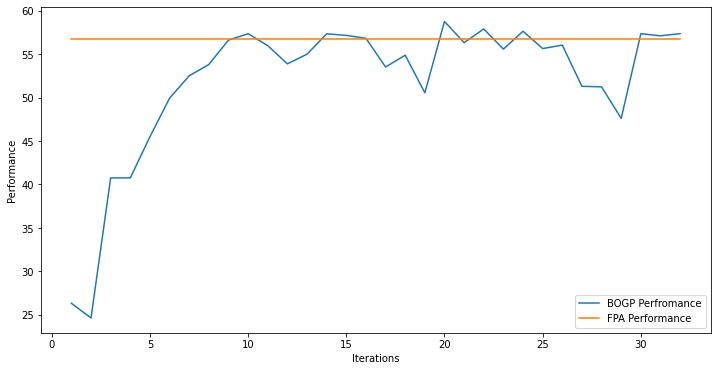

x_next is [ 39.02222931  39.98237728  39.98563119  39.9831143   39.99642839
  39.99326527  27.13065657  22.80042567  39.99253329   0.86277389
   5.46390539  32.77645158  39.99946029  19.92276544  39.97767575
  39.06272859  39.99973227  39.99978382  28.56422647 -14.45550368]
f()=58.182392, actual=53.294
31


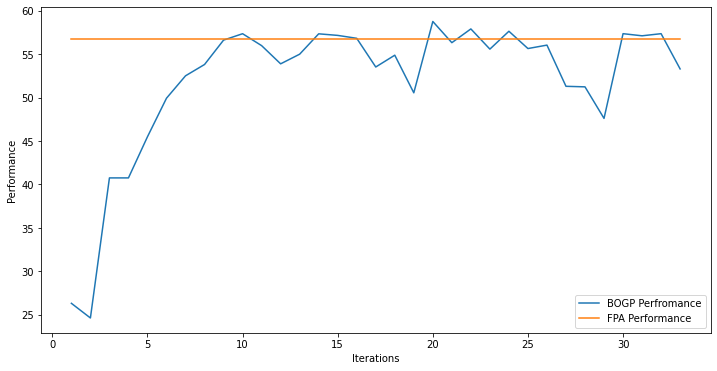

x_next is [ 40.          40.          39.99995036  40.          40.
  40.          39.99999999  39.99999998  39.99999996 -30.99999996
 -30.99997085  40.          40.          40.          40.
  40.          40.          40.          40.          40.        ]
f()=57.834512, actual=57.442
32


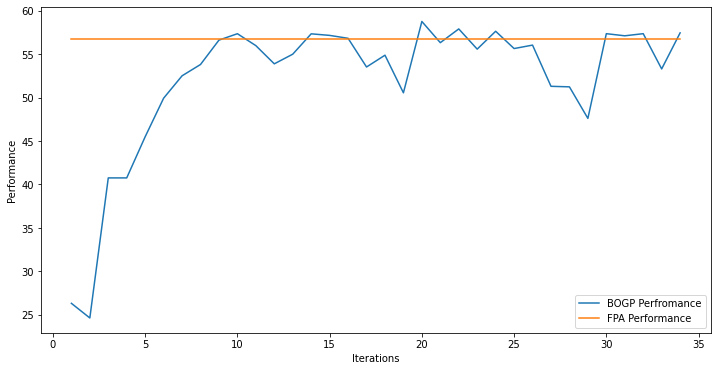

x_next is [ 39.99999999  39.99999999  39.99999999  40.          40.
  39.99999999  40.          39.99999999  39.99999998 -30.99998875
  12.61100583  40.          40.          40.          40.
  39.99999998  40.          40.          40.          39.99999997]
f()=57.845406, actual=57.442
33


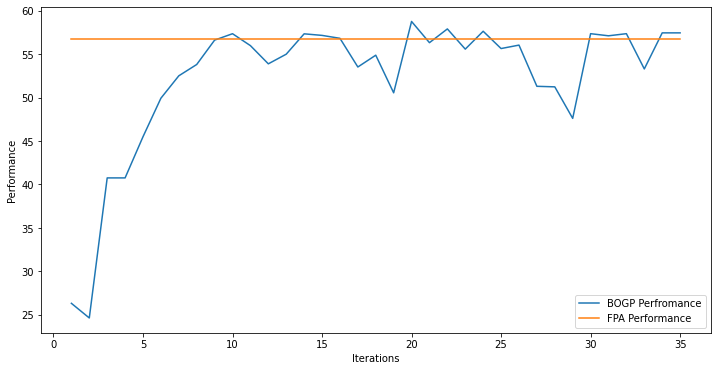

x_next is [ 39.97350551  39.99741543  39.99008933  39.93510787  39.98992927
  39.99451019  33.75741676  39.90181157  39.86145155  -4.64427559
  10.73666273  39.99358167  39.99480386  32.53693684 -30.2165719
  39.98428302  39.98547051  39.99834817  36.39784938  39.99090532]
f()=54.788275, actual=55.277
34


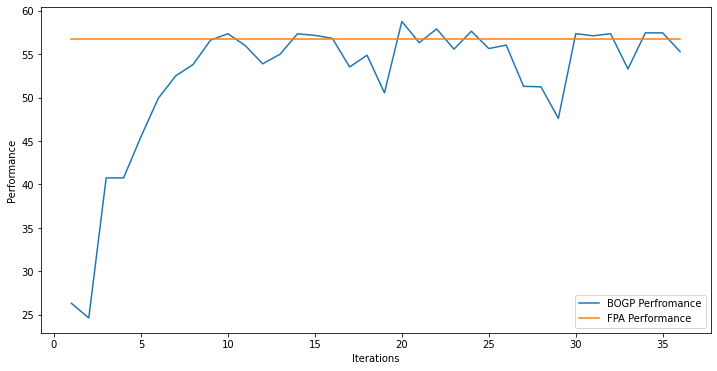

x_next is [ 39.99999999  39.99999999  39.99999993  40.          39.99999999
  39.99999999  40.          39.99999994  39.99999999  39.99988733
 -30.99967175  39.9999426   40.          40.          40.
  40.          39.99999999  40.          39.99999999  39.99999999]
f()=57.313774, actual=56.772
35


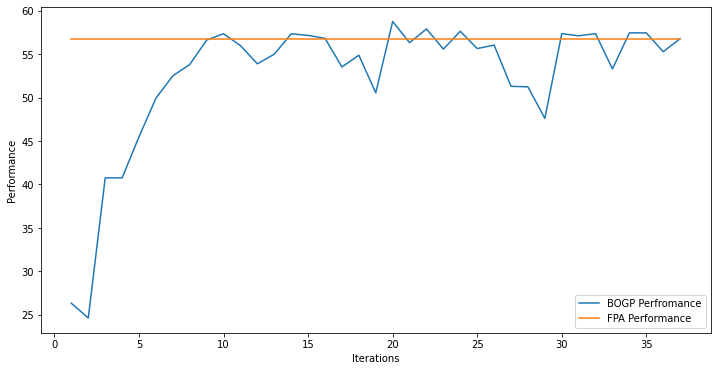

x_next is [ 36.38478113  39.99907139 -30.99989016  39.9898774   39.99659988
  39.99058713  26.73470047  39.99174863  39.99280876   2.61482497
 -14.56778387  39.99482357  39.99832578  32.37525133  39.97678419
  39.95997128  39.99579815  39.99984199  39.97432994  39.99326436]
f()=58.062657, actual=54.952
36


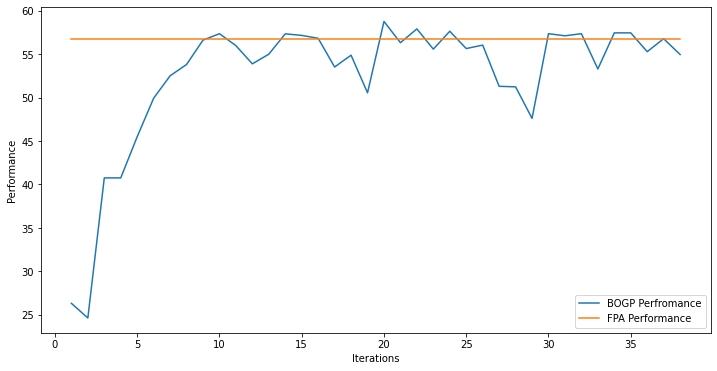

x_next is [ 39.99688745  39.98477044  39.99509585  23.44111791  39.9833799
  39.99356321  39.96241818 -14.00478462  39.95267758  -1.71324882
  17.28691519  39.9825739   39.99877045  12.59755975  39.97801936
  28.90239291  39.99351163  39.99764309  39.7203777   39.99635751]
f()=56.623132, actual=55.075
37


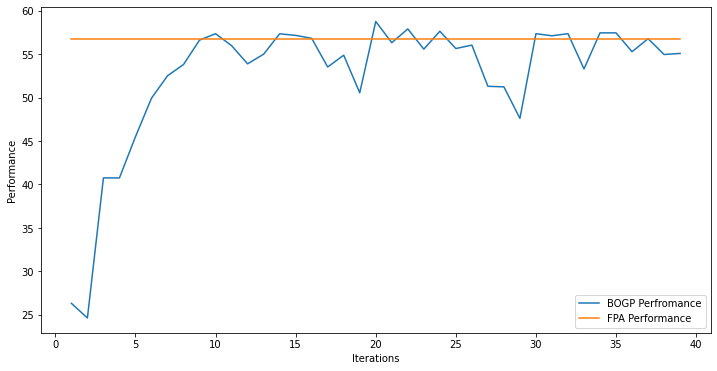

x_next is [ 39.0815242   39.98237186  39.98681792  23.5106726   39.98916554
 -16.27806481  24.90046147  39.99763766  39.99649225   2.8750397
  39.71249569  39.99605134  39.99507706  35.23147018  39.92955911
  32.31716947  39.99334809  39.99882529  21.31595385  39.99514535]
f()=55.067419, actual=55.956
38


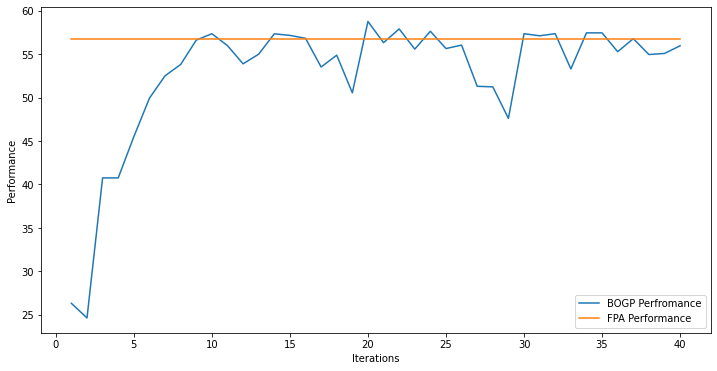

x_next is [ 39.9468021   39.99812976  39.99193677  39.9987286   39.99162375
  39.99186727  39.61555131  39.97362272  39.98408494   2.36240363
  11.06567296  39.99613294  39.99605369  31.90375004  39.9473769
  34.8159489  -17.3103578   39.99966955  16.31338079  39.98470723]
f()=55.642272, actual=52.233
39


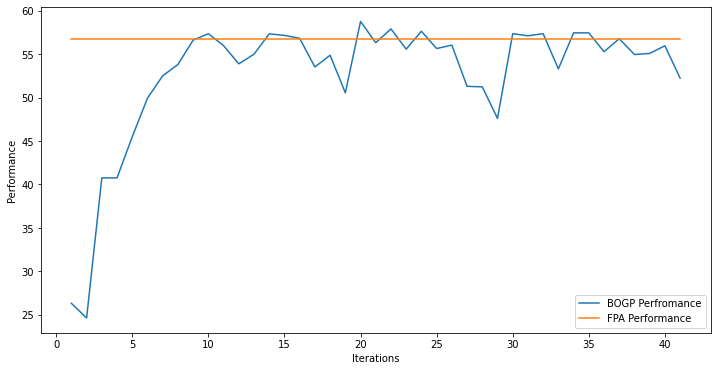

x_next is [ 40.          40.          40.          40.          40.
  40.          40.          39.99999999  -7.61325406 -18.67260891
  40.          40.          40.          40.          40.
  39.99999999  40.          40.          40.          40.        ]
f()=58.020896, actual=57.031
40


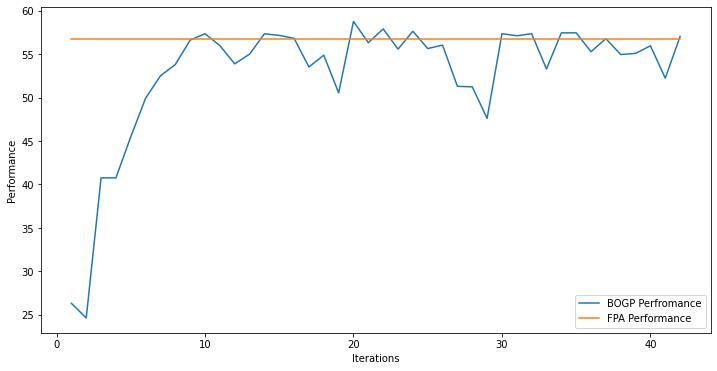

x_next is [ 40.          39.99999999  39.99999999  39.9999998   39.99999999
  39.99999999  39.99982128  39.99999999   8.82867053 -30.99959218
  39.99999999  39.99999998  40.          40.          40.
  39.99999997  39.99999999  40.          40.          40.        ]
f()=57.868628, actual=57.031
41


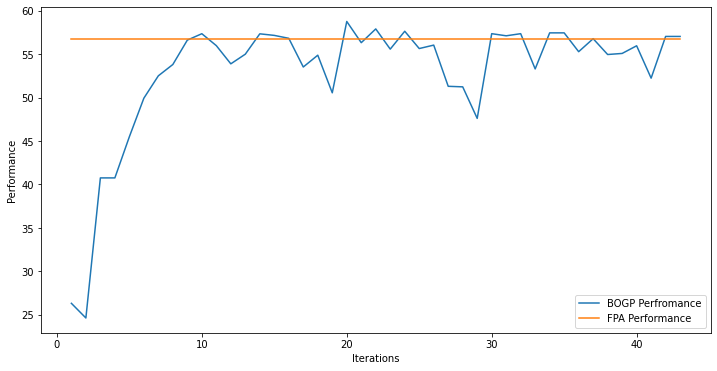

x_next is [40.         40.         39.99999999 39.99999998 40.         39.99999999
 39.99999998 39.99999999 20.00952248  1.47120689 40.         40.
 40.         40.         39.99999999 40.         40.         40.
 40.         40.        ]
f()=57.765282, actual=57.099
42


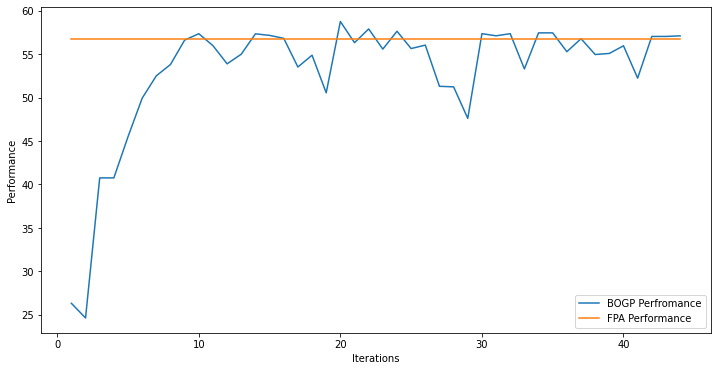

x_next is [ 40.          39.99999999  40.          40.          40.
  39.99999982  40.          40.           7.50812783 -30.9999539
   9.14410768  40.          40.          40.          40.
  39.99999995  39.99999999  40.          40.          40.        ]
f()=57.736192, actual=57.020
43


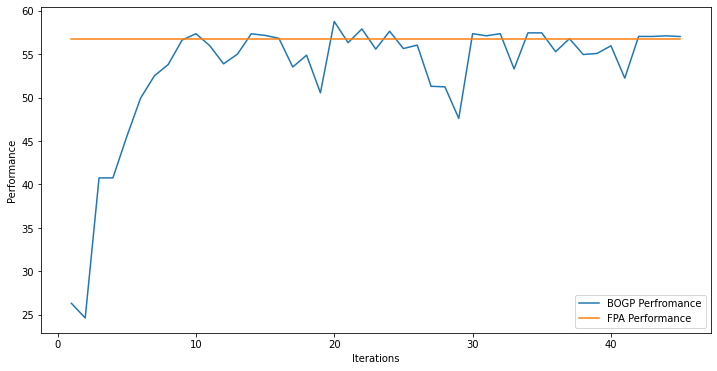

x_next is [40.         40.         40.         40.         40.         40.
 39.99999999 40.         39.99999998 -9.43424153 39.99917999 40.
 40.         40.         40.         39.99999999 40.         40.
 39.99999998 40.        ]
f()=57.663644, actual=57.354
44


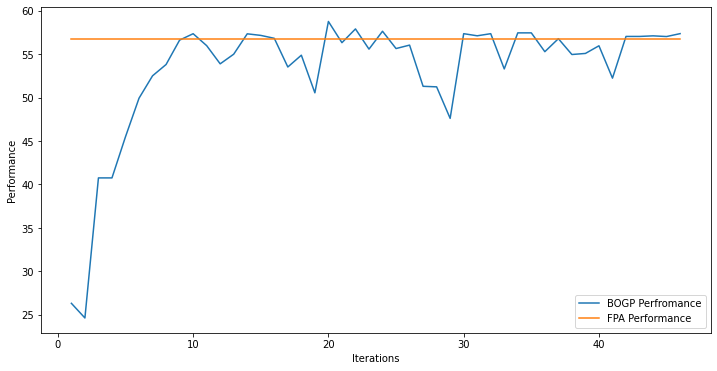

x_next is [ 39.99999999  40.          39.99999998  39.99999998  39.99999999
  40.          39.9997858   39.99999998  -4.0343711  -30.99982857
   5.91737236  39.99999999  39.99999998  40.          40.
  39.99999999  39.99999998  40.          39.99999999  39.99999999]
f()=57.645104, actual=57.020
45


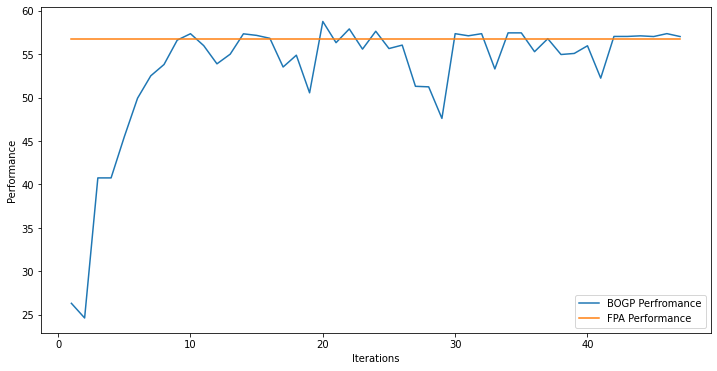

x_next is [40.         39.99999999 39.99999997 40.         39.99999999 40.
 40.         40.         39.99999998 -1.58979766 40.         40.
 40.         40.         39.99990532 40.         40.         40.
 40.         39.99999999]
f()=57.597691, actual=57.381
46


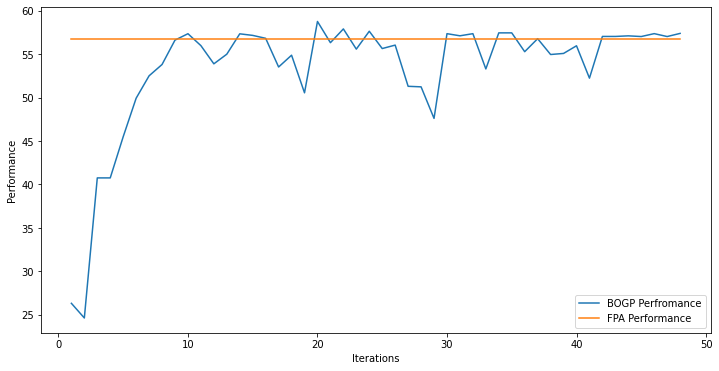

x_next is [ 40.          40.          39.99999998  40.          40.
  40.          39.99999996  40.         -30.99980622  39.99999996
  39.99999994  40.          39.99999999  40.          39.99999993
  40.          39.99999999  40.          39.99999998  40.        ]
f()=57.245415, actual=56.355
47


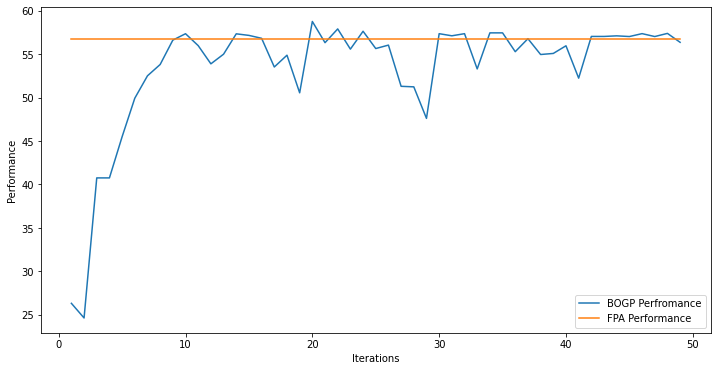

x_next is [ 39.99999996  39.99999998  39.9999999   39.99999999  40.
  39.99999995  39.99999993  39.99995262  39.99999999 -30.99992458
   5.62622471  39.99999998  39.99999998  39.99999999  39.99999998
  39.99999999  39.99999999  40.          39.99999992  39.99999995]
f()=57.621245, actual=57.442
48


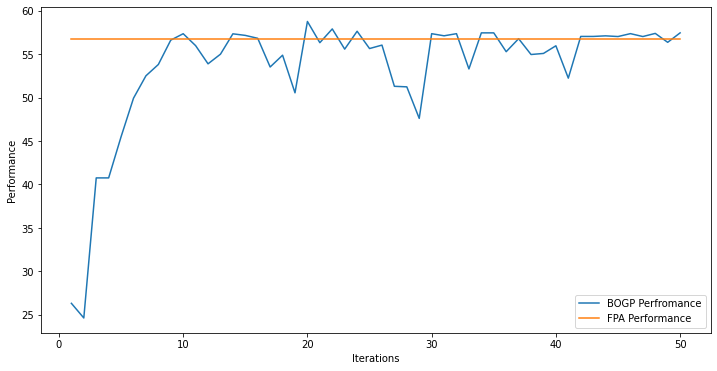

x_next is [ 39.99999998  39.99992205  39.99999998  39.99999995  39.99999999
  39.9998876   39.99999998  39.99980991  39.99999997 -30.99990114
   6.76635017  39.99999998  39.99999998  39.99999998  39.99989089
  39.99984782  39.99999998  39.99999999  39.99999998  39.99948479]
f()=57.595080, actual=57.442
49


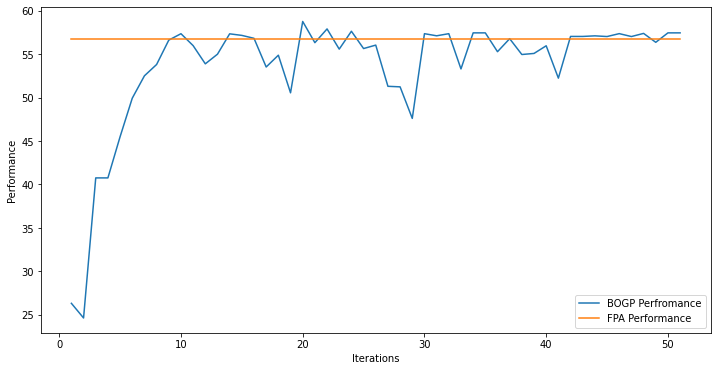

x_next is [ 33.59454402  39.99891611  39.99841584  37.12066621  39.99897118
  39.97716276  35.28428392  39.99689946 -28.32191439 -19.03916703
  10.46457237  24.11201559  39.99986205  28.28348807  37.94569927
  29.04118299  39.9992285   39.99988056  23.66563057  39.99835001]
f()=62.113424, actual=55.827
50


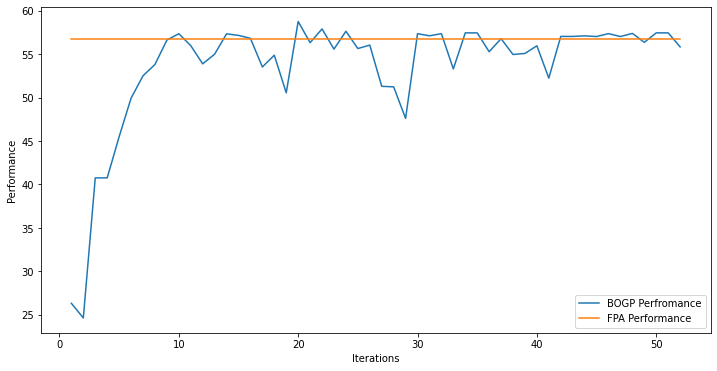

x_next is [ 39.99633204  39.99601107  39.98813622  29.71710637  39.99773841
  33.7024698   39.98639671  29.66025765 -28.15128893 -23.37566701
  14.08108426  30.15497052  39.99524996  39.98999721  39.99243512
  32.88168831  39.96953444  33.56085485  34.38485207  39.94921816]
f()=60.705538, actual=61.378
51


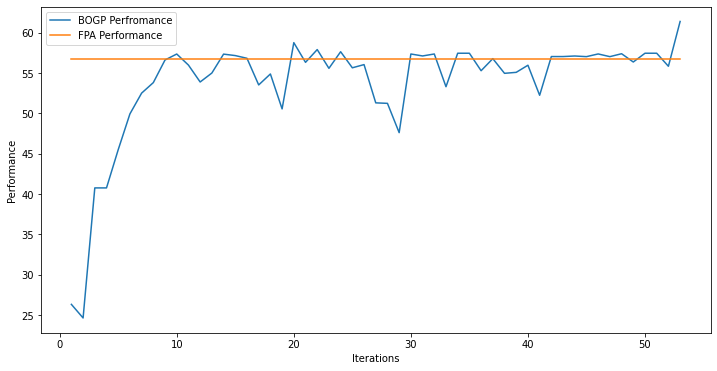

x_next is [ 39.9990287  -15.05208157  39.97306903 -30.13375944  39.99733554
  39.89605411  39.87889433  39.99493594  39.99460276 -11.91103764
  39.98905755  39.99355138  39.99909266  39.99253459  39.9777417
  38.94907099  39.99617508  20.26020633  39.99797725  39.96479772]
f()=55.325692, actual=51.649
52


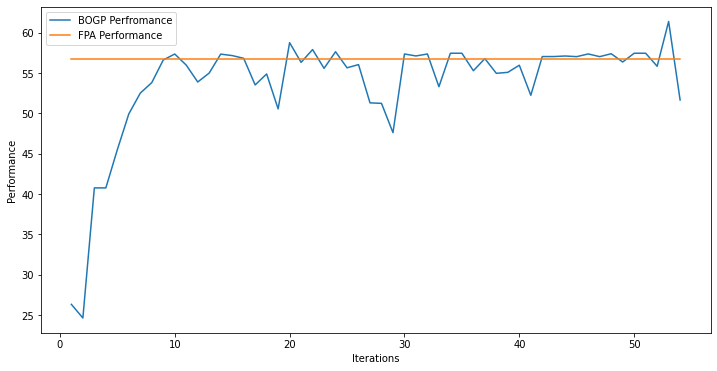

x_next is [ 40.          40.          40.          40.          40.
  40.          40.          40.          14.4217418  -10.38444898
  14.28635027  40.          40.          40.          40.
  40.          40.          40.          40.          40.        ]
f()=58.166817, actual=57.025
53


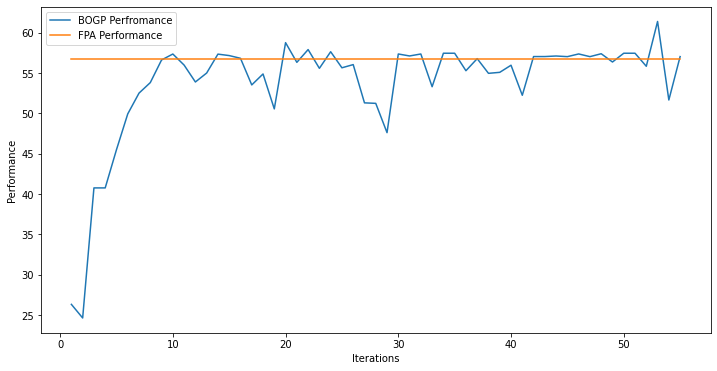

x_next is [ 40.          40.          40.          40.          40.
  40.          40.          -7.92128932 -30.99996551 -30.99985717
  10.92277961  40.          40.          40.          40.
  39.99999999  40.          40.          40.          40.        ]
f()=57.821699, actual=55.708
54


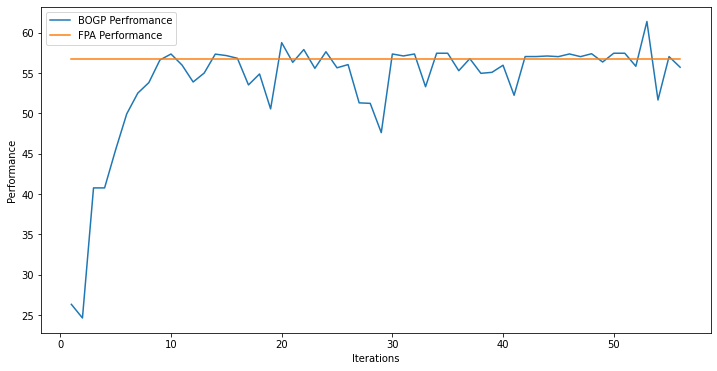

x_next is [ 40.          40.          39.99999994  39.99999995  40.
  39.99999999  39.99999999  40.         -30.75635206 -30.99972356
  12.54446424  40.          40.          40.          39.99999998
  39.99999999  40.          40.          39.99999999  40.        ]
f()=57.837836, actual=57.020
55


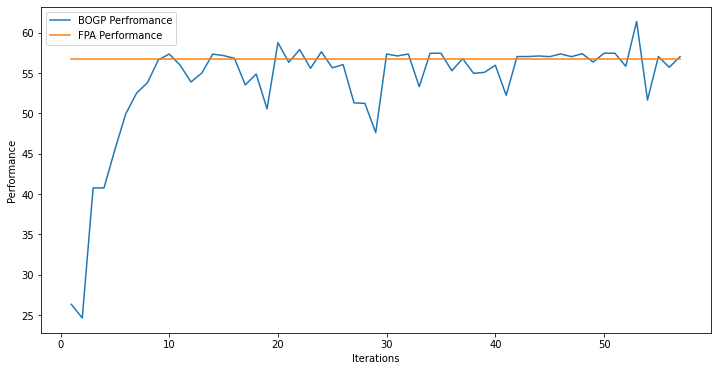

x_next is [ 39.99788443  39.98685087  39.99608123  -6.5184425   39.98910588
  -3.6775011   39.992678    10.18299394 -23.8719991    7.85119358
 -30.98340289  39.98614117  39.99688846  39.99236058  39.98247296
  34.94136661  39.99613025  37.44352049  39.99821624  39.97096641]
f()=56.354672, actual=52.906
56


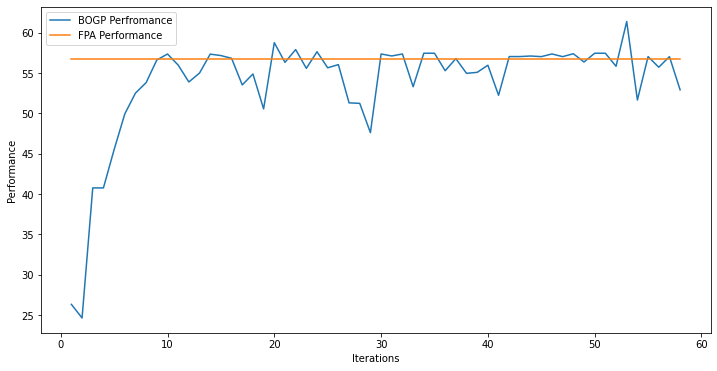

x_next is [ 40.          40.          39.99999999  39.99999999  40.
  39.99999999  40.          40.         -18.49133533 -30.99999997
  25.88565743  40.          40.          40.          40.
  40.          40.          40.          40.          40.        ]
f()=57.745702, actual=57.020
57


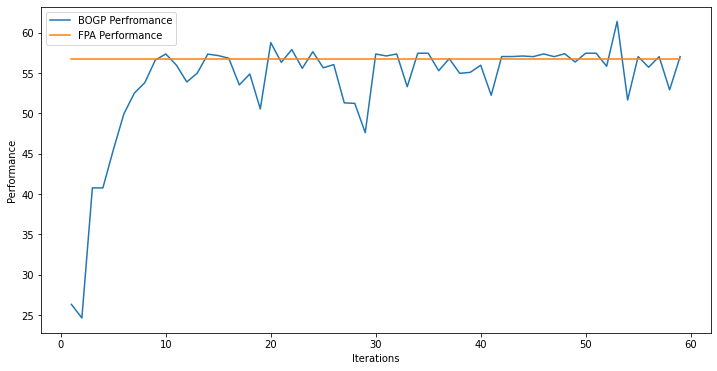

x_next is [ 39.99365964  39.98998449 -30.97703238  12.63459745  39.99707797
  39.96180915  39.9934469    3.2027885    0.40374527  26.01274803
  39.98536921  39.98093657  39.99302141  39.99218119  39.99930364
  30.0946114   39.98927257  20.66814158  39.96674323  39.99821068]
f()=55.071378, actual=54.949
58


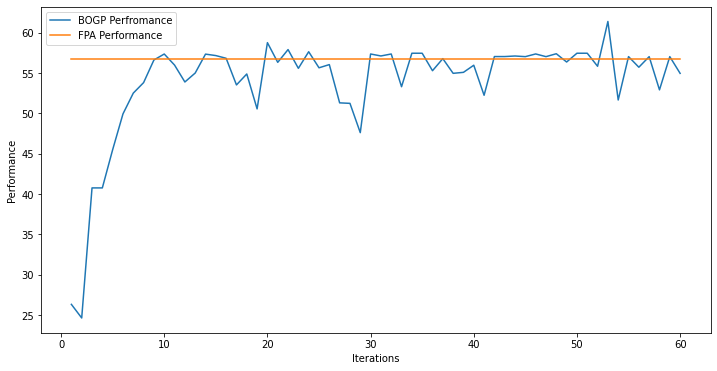

x_next is [ 40.          40.          40.          40.          40.
  40.          39.99999999  40.         -13.83015628 -23.73937747
  29.68497037  39.99999999  40.          40.          40.
  39.99999999  40.          40.          40.          40.        ]
f()=57.673880, actual=57.021
59


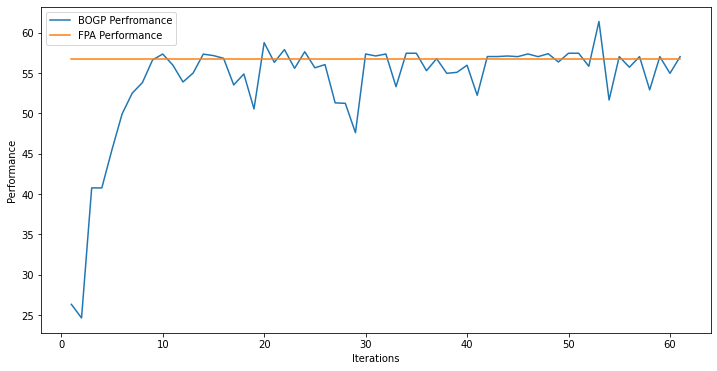

x_next is [ 39.99587409  39.99341283  39.98932483  20.3357503   39.99487833
  39.94997088 -16.09565411   8.02348726  39.99964653  39.92703446
  39.97601302  39.98626643  39.99996219  39.99981383  39.97989686
 -11.62600904  39.99825293  39.99629993  39.99601314  39.98054777]
f()=52.882989, actual=49.394
60


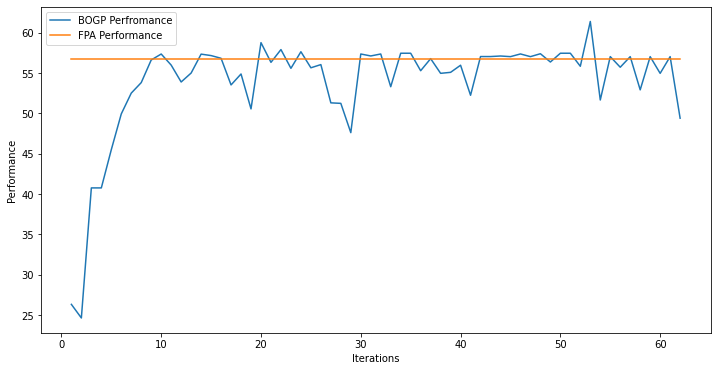

x_next is [ 40.          40.          39.99999992  39.99999995  40.
  40.          40.          39.99999996  -9.36887569 -30.99997708
  23.52118584  40.          40.          40.          40.
  40.          40.          40.          40.          40.        ]
f()=57.702196, actual=57.020
61


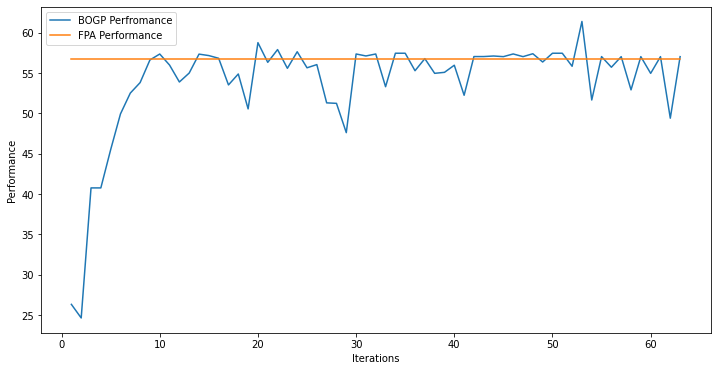

x_next is [ 39.9883979   39.98658462 -20.37481401  34.92168532  39.97442678
 -13.06096777  39.95853779  -0.04647996  39.970434   -30.97075657
  39.98131907  39.99695919  39.99812182  39.99503359  -1.07416187
  39.99422366  39.96948805  39.99870849  39.87535085  39.98465255]
f()=53.301393, actual=53.726
62


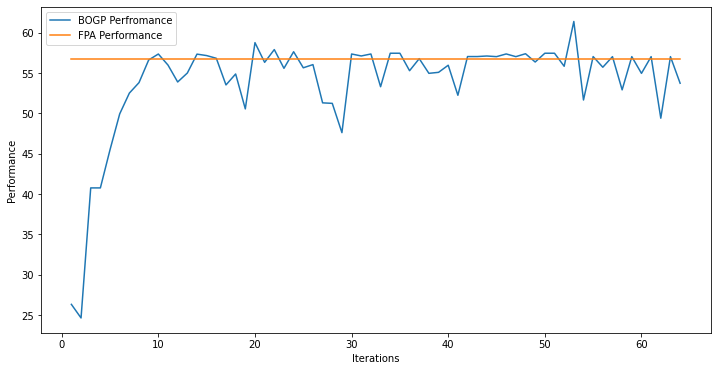

x_next is [ 21.40386636  36.40175174  15.21287283  28.71737823  35.33367911
  36.76422461  35.21308605  38.07892552  15.76995151 -21.01249022
  24.25569258  18.45414684  39.5363833   34.88043747  19.20843302
  33.57315658  38.95798734  33.26844212  26.29582618  38.66549407]
f()=53.945766, actual=54.557
63


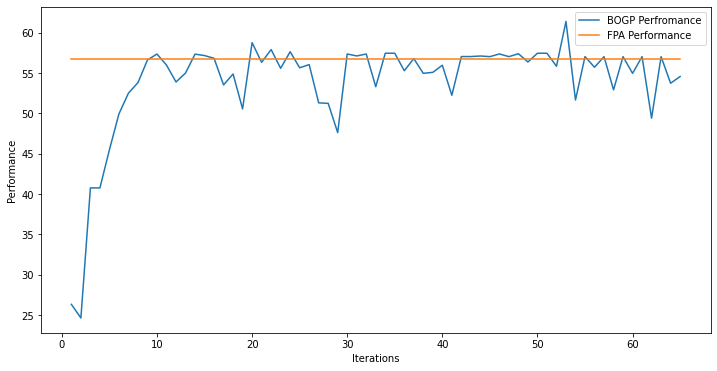

x_next is [ 40.          40.          26.89492692  23.88697268  39.99999999
  40.          40.          39.99999996   2.9980435  -29.13494147
  22.12588785  39.99999999  40.          40.          39.99999999
  40.          40.          40.          39.99999999  40.        ]
f()=57.637711, actual=57.674
64


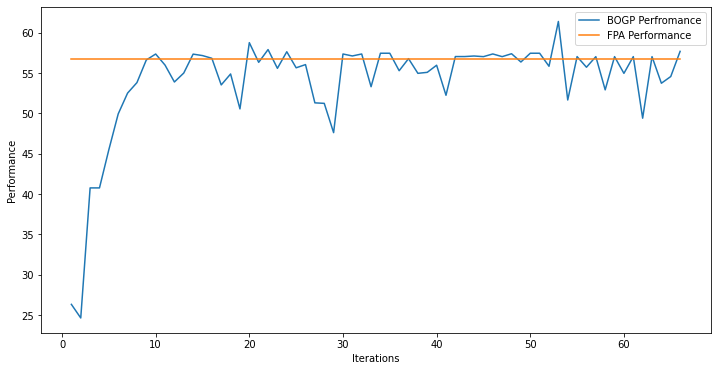

x_next is [ 40.          40.          27.06526524  23.60612058  39.99999999
  39.99999999  40.          39.99997037   2.23565833 -27.77861446
  21.57560056  39.99999999  40.          40.          39.99999997
  40.          40.          40.          40.          40.        ]
f()=57.645811, actual=57.618
65


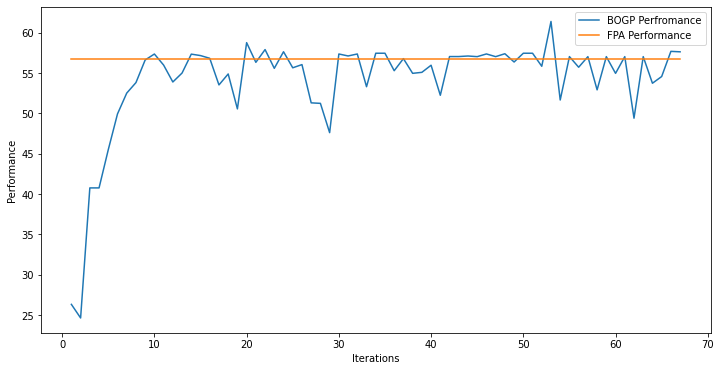

x_next is [ 39.95061147  39.96436326 -19.83586238   6.2829474   39.99310391
   9.34538177  39.9969465   39.91350142   8.92449419 -30.98385788
  39.98953393  39.99665848  39.98695053  39.99122929  39.92571758
  32.84511405  39.96624725  39.94647736  39.9978114  -10.66652589]
f()=54.584998, actual=51.583
66


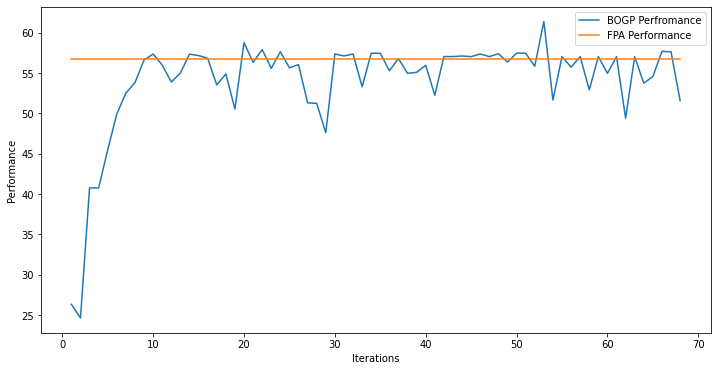

x_next is [ 39.99647937  39.99196744  39.88425886  30.57679007  39.95973082
  16.41429385  39.98269182  12.0015574   39.94135549  12.23012673
  39.96845035  39.86267602  39.99925804  39.9869467   39.7787945
  39.99388868  39.99296546 -18.65602075  39.98570745  39.98170249]
f()=54.607678, actual=55.034
67


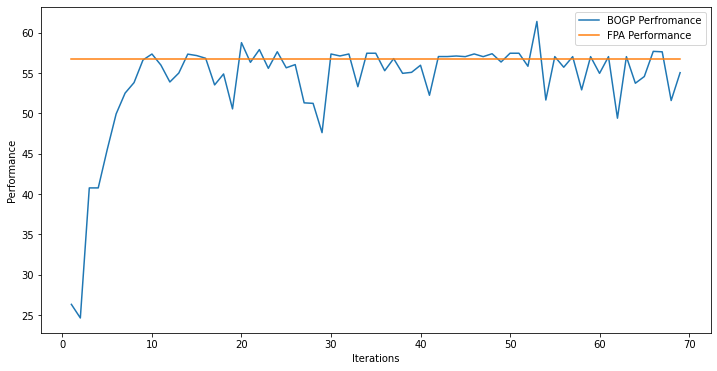

x_next is [ -9.8960465    3.73834958 -21.4295017   -4.40443308  31.98943288
   9.78967799  29.97932922  22.86876825   0.44582796  -4.89664405
  -9.18550919  -2.9364659    1.05716819 -28.75961927  38.43935262
   6.71333518 -21.57855242 -12.89711242 -27.83954517  38.10812395]
f()=54.044071, actual=25.848
68


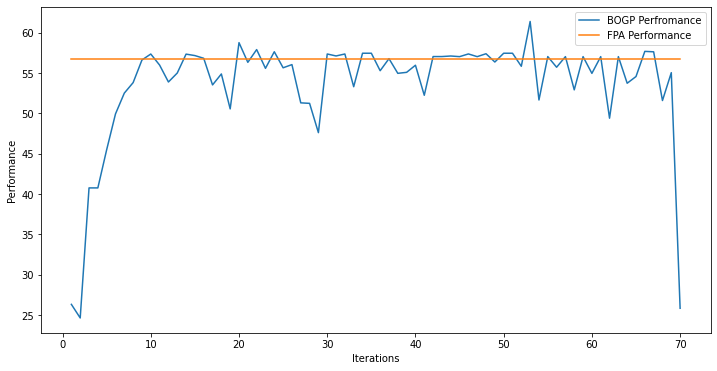

x_next is [ 39.99584964  39.99980574  39.99444544  29.54365585  39.98460185
  39.98280065  39.99263477  -1.26410242  39.90742132  19.23834234
  39.99484383 -30.84538151  39.99608628  39.99137046  39.99913993
  39.97782394  39.99030588  39.07226956  39.94135514  39.91783285]
f()=53.745162, actual=57.626
69


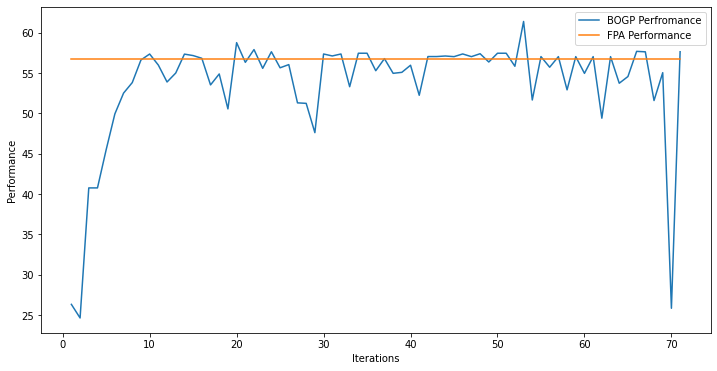

x_next is [ 39.99693307  39.99601235  39.98904052  14.40485269  39.96807979
  21.66717899  39.96814346  13.36712175 -17.27773785 -12.60116747
  39.9659144   19.64781468  39.99645478  39.99365947  39.99264631
  27.45979613  39.97154577  28.04808716  39.84664906  39.98286803]
f()=60.032008, actual=52.464
70


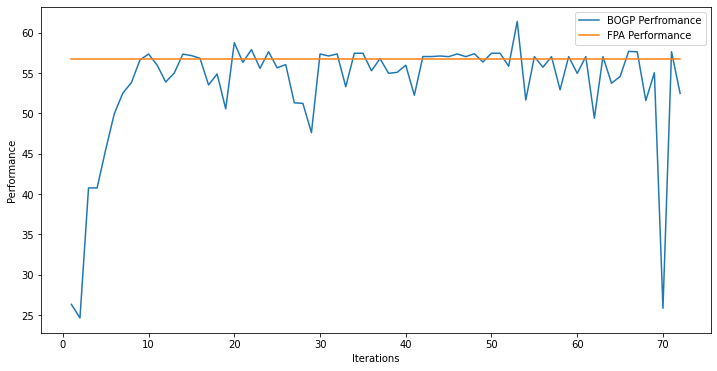

x_next is [ 39.99461654  39.99154304 -22.13862524  15.50746193  39.98483813
  39.99937459  39.99995027 -23.9726705   39.99551725 -30.99344504
 -30.98000143  39.99883494  39.98660277  39.99814186  39.96965342
  39.9748524   39.99341957  39.96766711  39.9872182   39.98369998]
f()=54.348606, actual=54.491
71


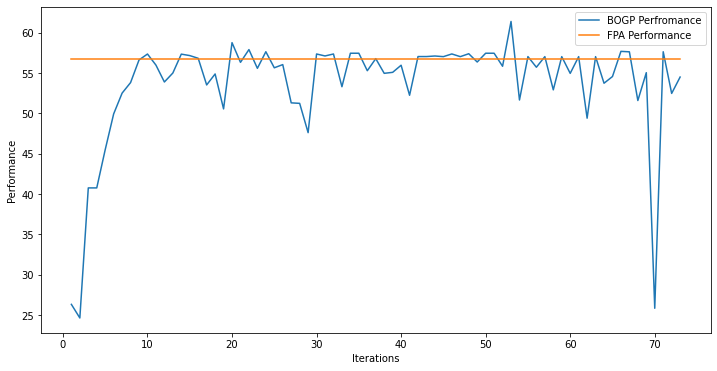

x_next is [40.         40.         40.         40.         40.         40.
 40.         39.99999971 39.99999998 -3.80056962 39.99996953 40.
 40.         40.         40.         40.         40.         40.
 40.         40.        ]
f()=57.815965, actual=57.368
72


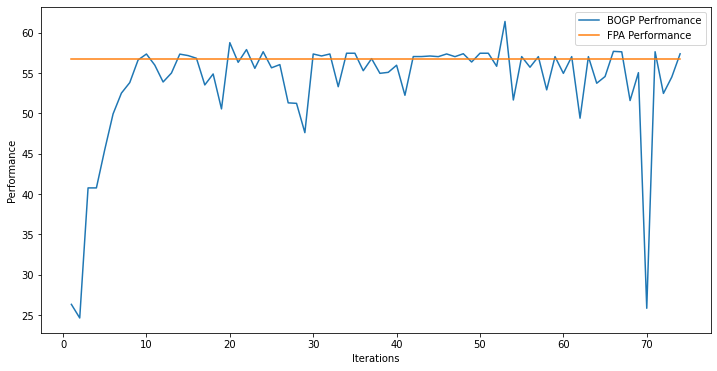

x_next is [40.         40.         39.99999991 39.99999999 40.         39.99999999
 40.         39.99997682 39.99984113 -5.36000245 30.39864401 40.
 40.         40.         40.         40.         40.         40.
 40.         40.        ]
f()=57.778173, actual=57.443
73


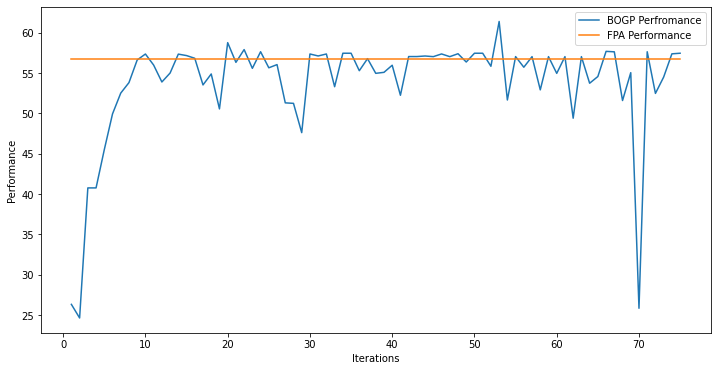

x_next is [40.         40.         40.         40.         40.         40.
 40.         39.99999992 40.         -6.31827831 26.95249475 40.
 40.         40.         40.         40.         40.         40.
 40.         40.        ]
f()=57.750325, actual=57.447
74


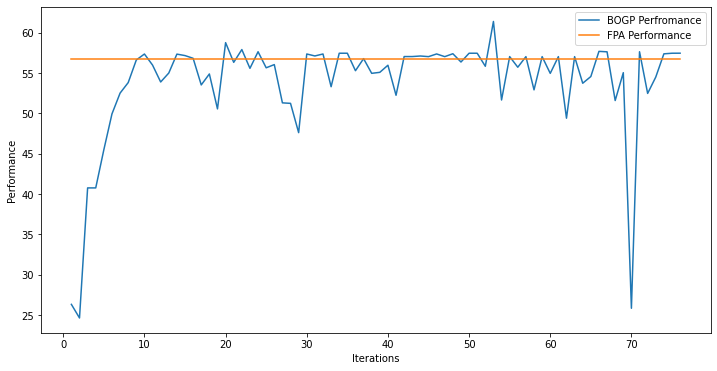

x_next is [ 39.99806112  39.99616073  39.98165321  39.85627697  39.96348821
  39.99801585  39.99709785 -27.26801893  39.97262179  39.98171775
 -30.97206712  39.97041302  39.98980716  39.99388253  -9.32418606
  39.98803484  39.99422915  25.20299225  39.98951552  39.98853487]
f()=53.516542, actual=52.426
75


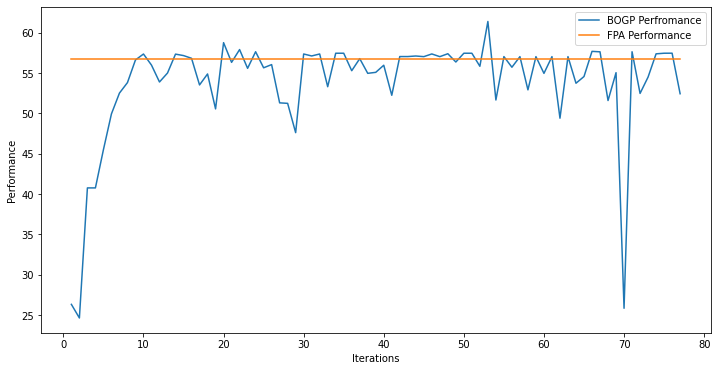

x_next is [ 39.95505378 -30.99453097  39.99435864  39.97616997  39.9973531
  39.9894585   39.96194583   1.83772239  39.9772555   20.91401513
  39.99667286  39.8903431   39.99869587  39.99744242  39.85224519
  39.99630141  39.99753823  39.97482169   0.31822407  39.99381599]
f()=52.993694, actual=55.298
76


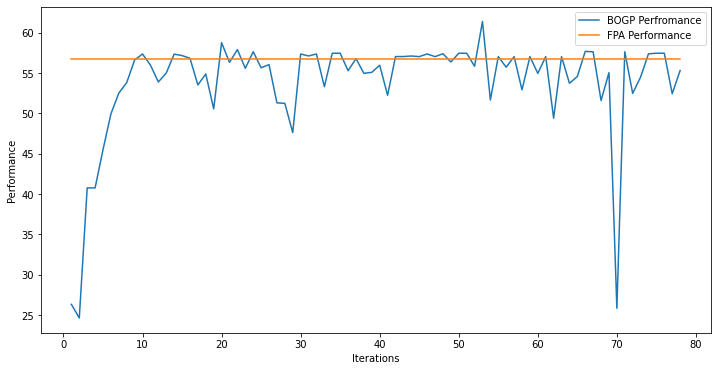

x_next is [ 39.99355809  39.97115267  -7.23353742  39.96520392  39.98185102
  39.94915738  39.99988005  -4.85243476  39.99507176  39.99154486
  39.98001193  39.90009948  39.99997098  39.98850772  39.94434849
  39.97038352  39.98858819  39.98278064 -16.88119259  39.99699892]
f()=54.612853, actual=52.799
77


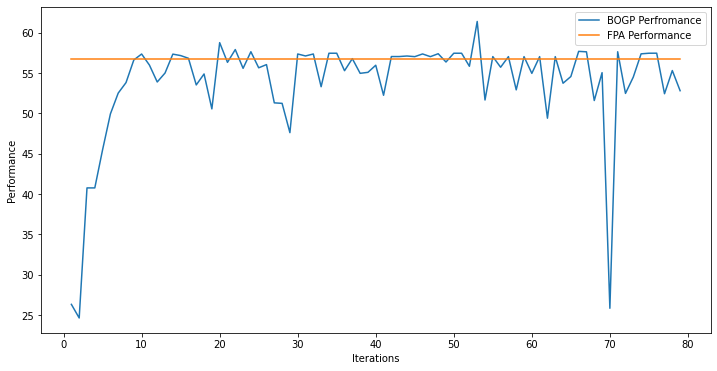

x_next is [ 39.98844035  39.98204377 -19.64108937  39.96405019  39.99464444
  39.99619288  39.99357111  39.97081752  39.97482172  39.4353818
  39.99838798 -30.98187134  39.99902867  39.99999774  39.90432289
  39.99256637  39.98809684  39.98354037  39.99946851  39.98594306]
f()=54.337540, actual=56.180
78


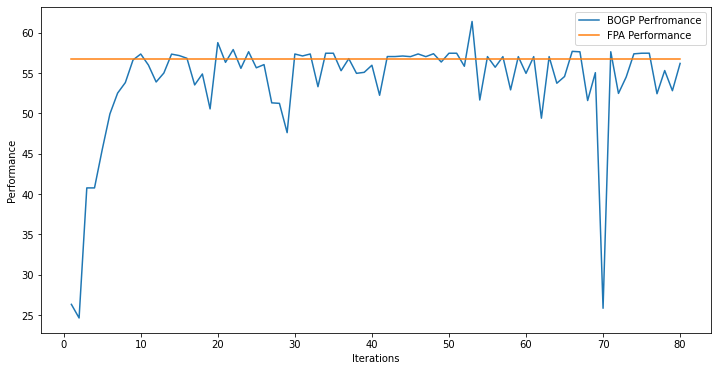

x_next is [ 39.99916749 -30.96186927  39.99136941  39.98123009  39.98661654
  39.99636723  39.99215759  31.38530168  39.99817921 -29.74522853
  39.96437186 -30.85687265  39.9883135   39.96443674  39.95720743
  39.99850912  39.99528414  39.97894496  39.97732892  39.98948485]
f()=53.684037, actual=54.060
79


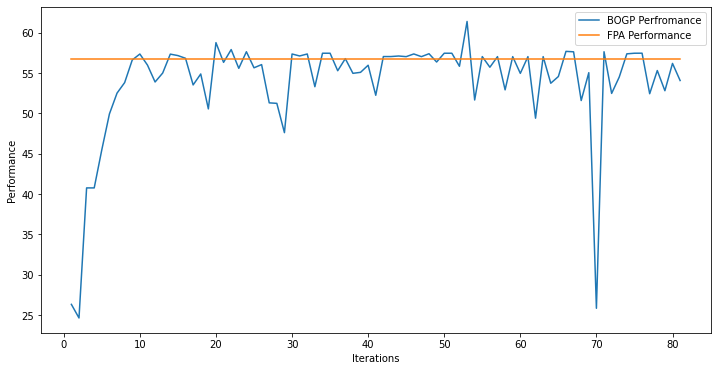

x_next is [40.         40.         40.         40.         40.         40.
 40.         20.41404192 39.99999998 -8.63989153 40.         39.99996904
 40.         40.         40.         40.         40.         40.
 40.         39.99999999]
f()=57.751392, actual=56.083
80


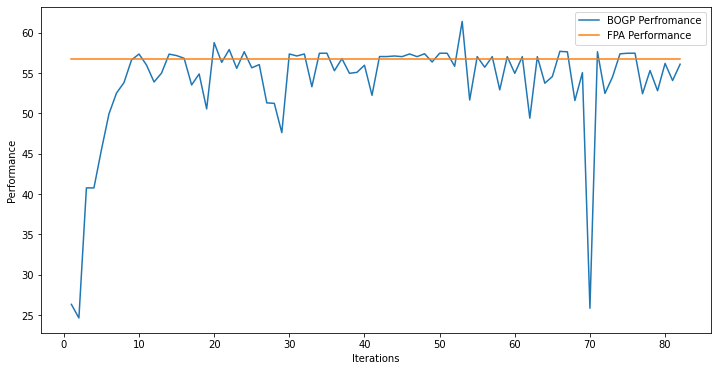

x_next is [ 39.96356298  39.98221626  39.98732028  39.98143376  39.98585683
  39.9567526   39.93274406  39.99660957  39.98655142  39.91555469
  39.98307905 -30.96715079  39.99819506  39.97167927  -2.50314467
  39.95662079  39.99433545  25.07521224  39.93547711  39.9919784 ]
f()=55.991956, actual=53.088
81


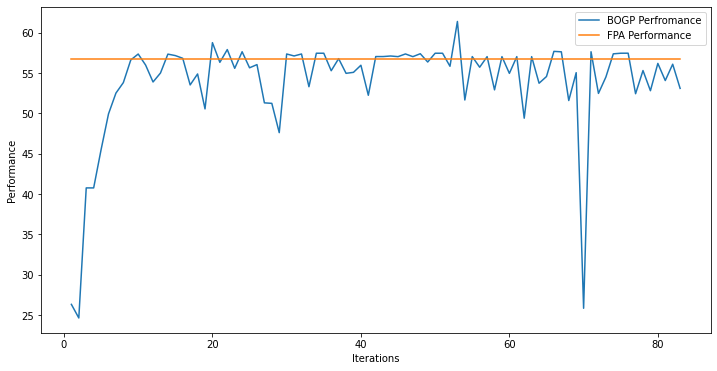

x_next is [ 39.99254155 -30.93234847  39.99737827  21.39266669  39.97839271
  39.98861879  39.95545463  12.22361602  39.98801587 -30.98014846
 -30.99254667  39.98028777  39.99585874  39.98435645  39.83268438
  14.39771467  39.9987341   39.98865582  39.9927937   39.99139862]
f()=55.122335, actual=52.357
82


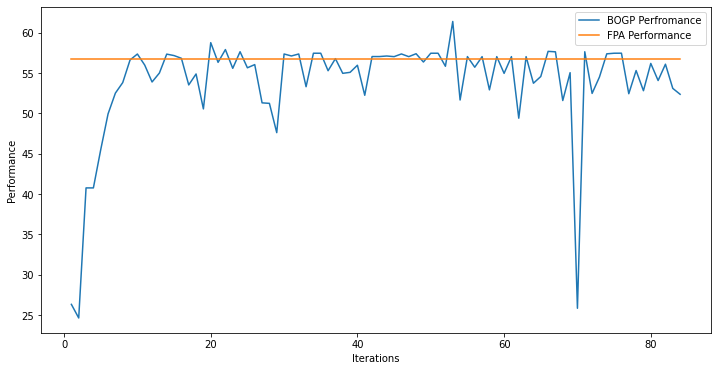

x_next is [ 40.  40.  40.  40.  40.  40.  40.  40.  40. -31.  40.  40.  40.  40.
  40.  40.  40.  40.  40.  40.]
f()=57.951052, actual=57.349
83


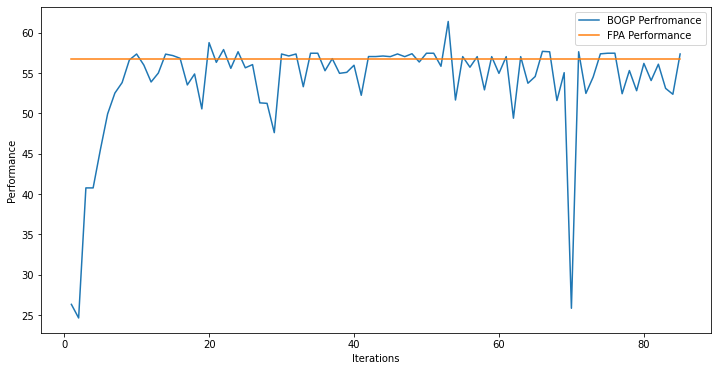

x_next is [ 39.74073177  39.69064233 -12.24612698  19.6091757   39.81277011
  39.01215142  39.98035991  38.51193405  39.04265666  39.06573623
  39.93069533  38.84201713  39.63140991 -29.66555403  39.41672462
  39.46065946  39.56365177  39.95376292  39.99280595  39.69843859]
f()=52.736630, actual=55.270
84


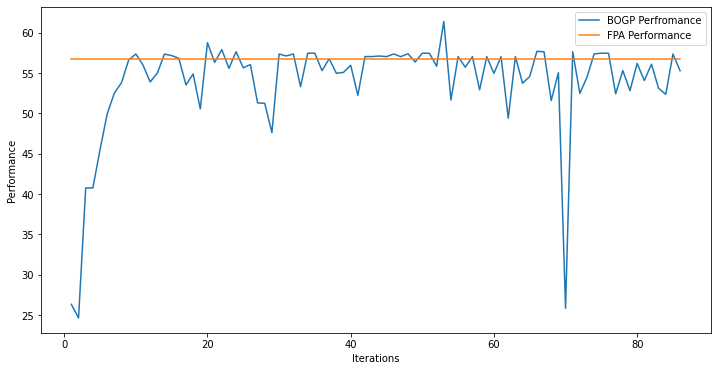

x_next is [ 39.9998739   39.99880332 -30.99913784   8.02492092 -30.99848978
  39.9984341   39.99890861  39.99626228  39.99739685 -30.99600206
  39.99704213  39.99948502  39.99927211 -30.99781292 -30.96893743
  39.99838755  39.99636211  39.99904691  39.99755279  39.99947442]
f()=48.089918, actual=49.695
85


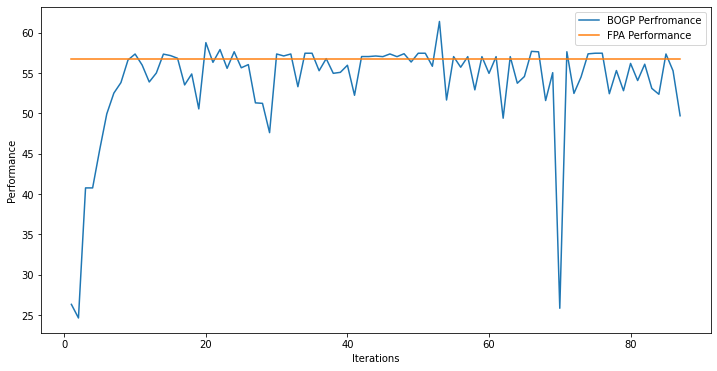

x_next is [ 39.99811284  39.985151    39.99951721 -30.66752832 -30.94217487
  39.99159767  39.97396782  39.99415341  39.97775699  39.99151109
 -30.98101921  39.9695445   39.99951262  39.98025286  39.98360919
  39.98460879  39.99495349 -30.99978465  39.98984888 -30.99010883]
f()=44.617312, actual=45.658
86


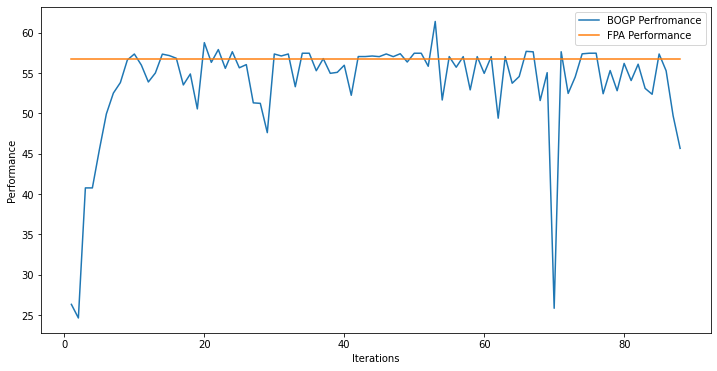

x_next is [40.         40.         40.         40.         40.         40.
 40.         39.99999999 40.         14.40771136 40.         40.
 40.         40.         40.         40.         40.         40.
 40.         40.        ]
f()=57.680747, actual=58.236
87


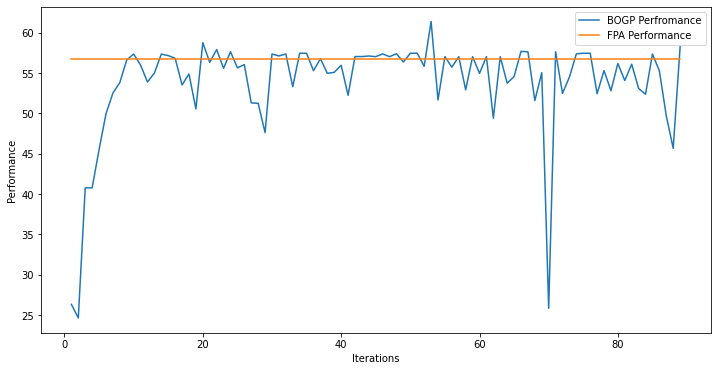

x_next is [  4.44555445  25.77723623 -26.54453728  -8.99307211   1.34252905
  -3.91244973   3.54202659  32.1452345  -30.12428861  33.84116204
  32.40897933  -2.26074861  16.11685079   2.1261894   25.64589044
 -25.07568475  25.66937044 -11.65336836  -7.65784557   6.0019567 ]
f()=53.822222, actual=27.590
88


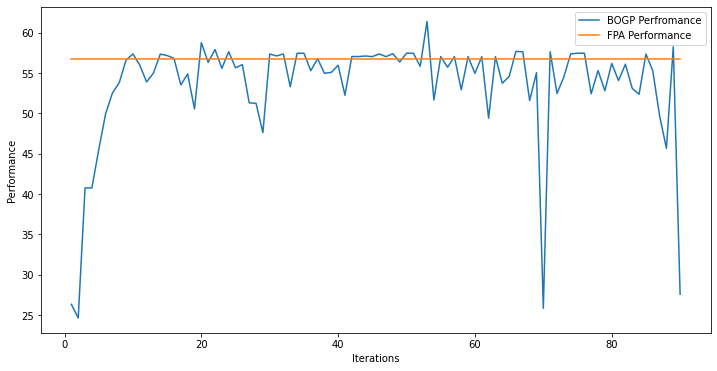

x_next is [ 39.56443617 -26.00345952 -11.72327954  35.21562338  39.68506077
  39.69993633  39.90102347  39.78872036  39.38038934 -14.3637418
  39.2874756   39.62940225  39.94506256  -0.88913188  36.90865662
  39.15975644  39.94141497  39.27391534  39.76320369  39.924829  ]
f()=54.904726, actual=54.633
89


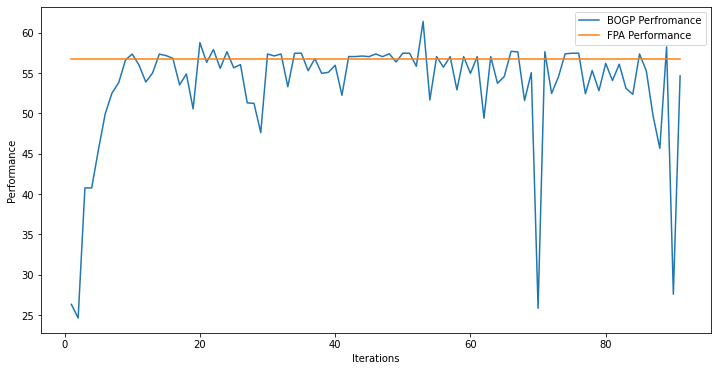

x_next is [40.         40.         12.80165115 40.         40.         40.
 40.         39.99999998 40.         11.82820073 39.99999998 40.
 40.         40.         39.99999999 40.         40.         40.
 40.         40.        ]
f()=57.726247, actual=57.672
90


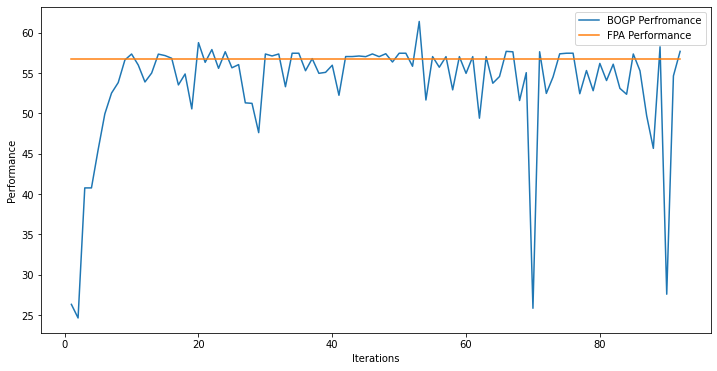

x_next is [ 39.86500555  39.71611212 -28.28023486   1.96616613  38.84697981
  39.93463288  39.48417543  38.86603345  39.17332152 -28.63372272
  15.26442866  39.36949482  39.8431447   39.66648906  -7.0446959
  38.08741054  39.94100316  38.83517232  39.18979891  39.75825372]
f()=55.888352, actual=55.718
91


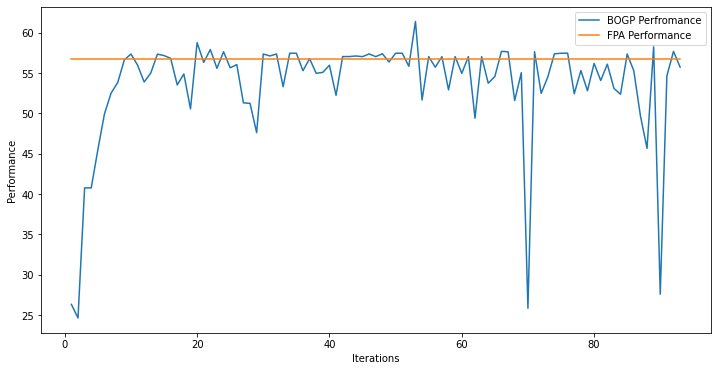

x_next is [ 39.32393365  39.57281904  38.21833052  38.43867875  39.90939161
  39.52170456  39.52594353  39.33390005  38.43445272 -30.85329898
  39.1910935   39.57241117  38.72054905  38.70485479  39.905588
  39.69787155  39.82681156  39.66744766  39.98104035  39.80637197]
f()=53.609444, actual=57.440
92


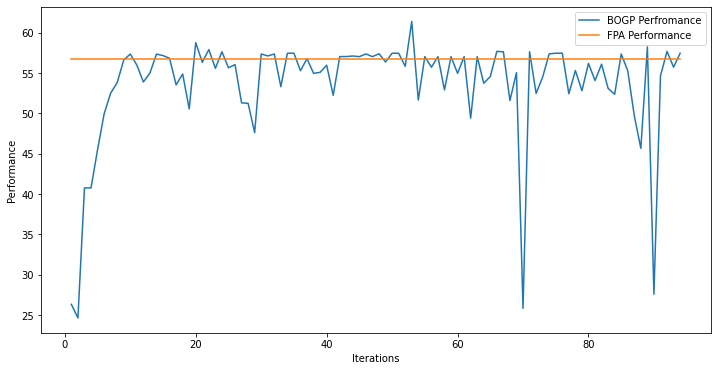

x_next is [-24.3825026  -30.55833919  20.21881394  33.09006765  38.55037512
 -13.49074521  20.59328047 -11.079711   -21.89176593   6.81223275
   8.08390261  -9.96818863  15.96135315  -5.9186408   16.64004434
  19.11941693   2.47934847 -24.46619802 -25.39517312  11.02762957]
f()=27.636131, actual=21.209
93


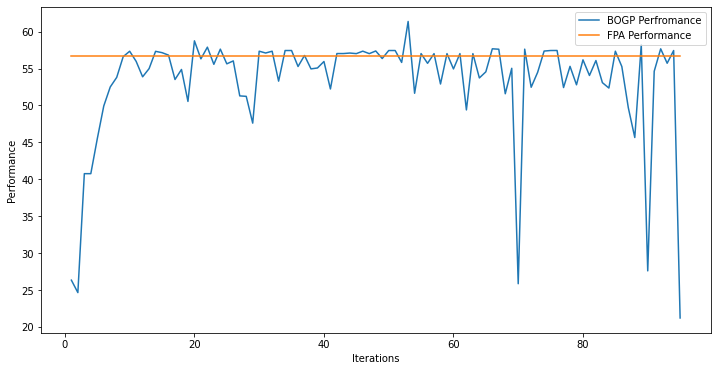

x_next is [ 39.89318247  39.79919694 -29.55823553   4.96158089 -28.40937236
  39.33860192  39.22452938  39.41354511  39.61505167  26.10437954
  39.95427167  39.75276472  39.56092394  38.30303149  39.33658851
  39.97038709  39.53079392  39.9850463   39.89385329  39.88685648]
f()=53.235860, actual=55.189
94


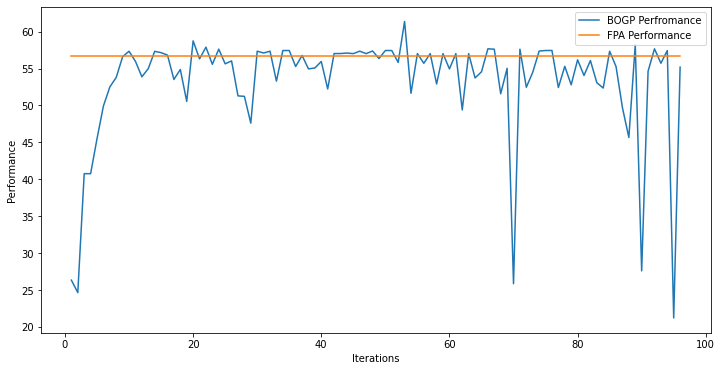

x_next is [ 39.99707806  39.71568089  39.76247947  18.56421907 -22.32053782
  39.58293765  39.89761568  38.69286646  39.9720253   15.75649054
  38.46985243  39.58436079  39.67179864 -18.58209535  39.95428093
  39.47047872  39.8843221   39.41859993  39.04378647  39.23615314]
f()=54.656095, actual=53.521
95


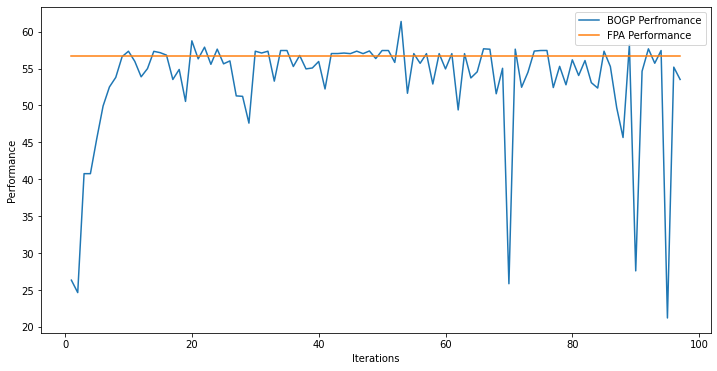

x_next is [ 39.99999981  39.99999977  39.99951343 -30.99999924 -30.99999927
 -30.99999932 -30.99984931 -30.999873    39.9999998  -30.99999929
 -30.99997805  39.99999978  39.99999981  39.99955999 -30.99999933
  39.99999992 -30.99999944  39.9999523  -30.9999994   39.99961894]
f()=38.923596, actual=38.667
96


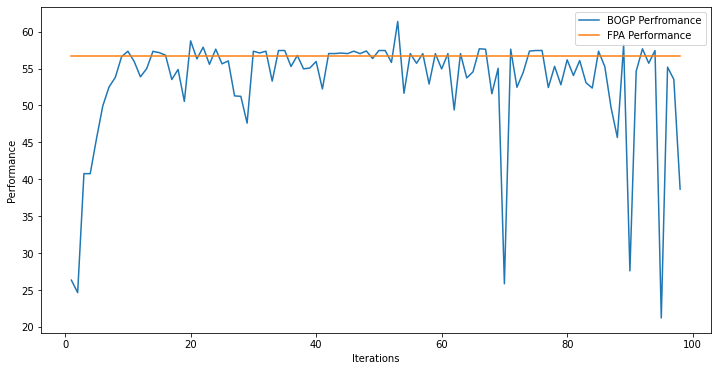

x_next is [ 39.70184053  39.95780629 -29.23752967   6.43444146   8.9603023
  39.96525958 -10.68666521  31.12796482  39.95226976 -29.5994837
  39.37358549  36.40151995  39.94875331  12.33951547  39.22846335
  39.77966763  39.64482089  38.19506148  39.97649407  39.95280091]
f()=54.207357, actual=46.963
97


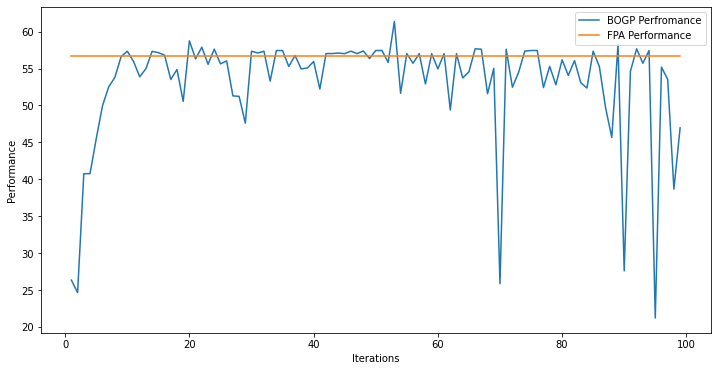

x_next is [ 39.96765625  39.58280453 -30.88907075  39.6625596    1.1879531
  38.83311797  39.9888943   38.80653473  39.62365341  38.41476645
  38.70147586  39.88274849  39.79986413  38.93461914 -27.9177011
  39.8038527   39.8914661   39.92112829  39.74096898  39.89435896]
f()=53.526014, actual=52.865
98


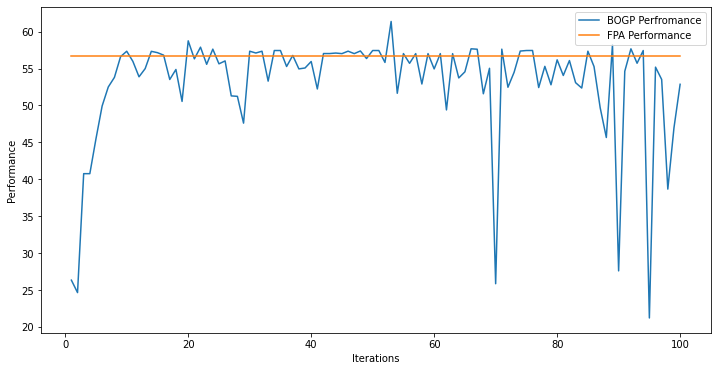

x_next is [ 39.99681025  39.58749281  19.66910534  39.43906218 -30.4478449
  39.25045999  39.75457403 -20.70559931  39.81236542  39.76986738
  38.96120659 -30.40517326  39.91424434  39.12097893  39.61970715
  39.94808292  39.85590869  39.2607908   39.96275976  39.38289739]
f()=51.681127, actual=50.809
99


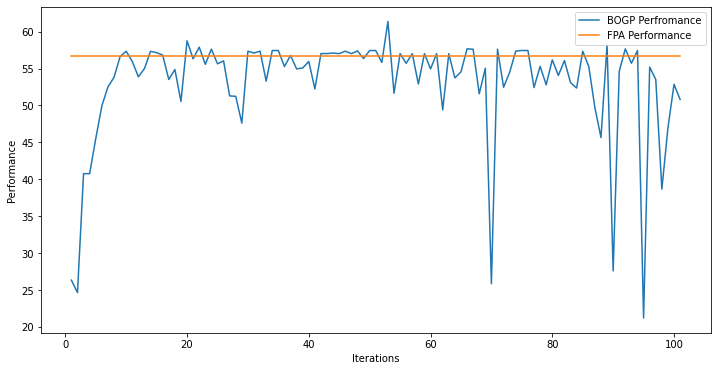

x_next is [ 29.70235305 -15.42993543   3.45237554  21.81418098   0.51874584
  35.13445301  34.44322005  33.71815776  -8.2982906    5.61521761
   1.2932431    1.24228761   5.44323833  12.53219748  -9.7145583
 -28.38562008 -10.23922705   1.33497593 -20.50485729  10.82593436]
f()=51.937331, actual=27.934
100


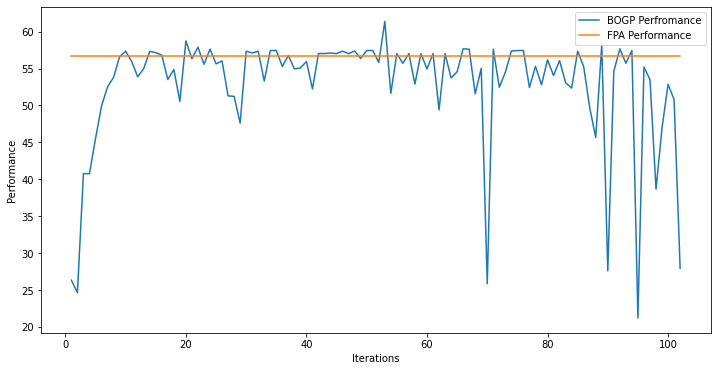

x_next is [ -9.72702353   9.54129343 -16.19358972 -14.80224512  16.97038527
  29.05084474   8.58337555  35.94395141  33.96026683  15.0788925
  11.65558105  -3.65026233  -4.09129247  27.01041618  32.49105887
 -21.77425282   7.72127261  10.88811871  39.37320514  -1.69446386]
f()=52.842920, actual=29.415
101


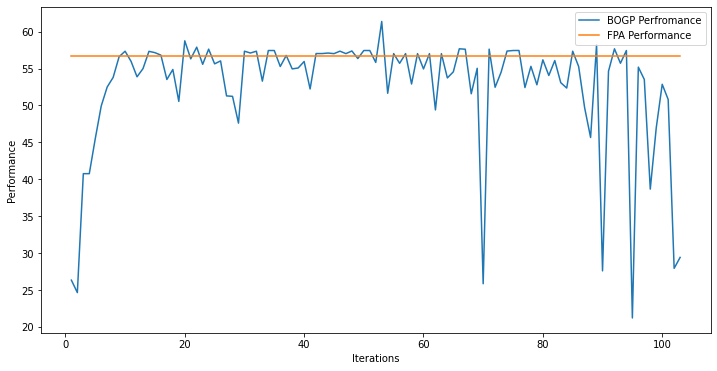

x_next is [-14.5910214   24.64745476   8.60473562   4.01257878  20.53307736
  25.36365392  35.23191768 -25.58670499  29.27406646  14.52601374
  28.55664482  35.97100045  26.83184431  26.06483332  -7.44507249
  25.46304295  28.27827454  35.32595396  -2.90640653 -16.69109831]
f()=41.397895, actual=42.957
102


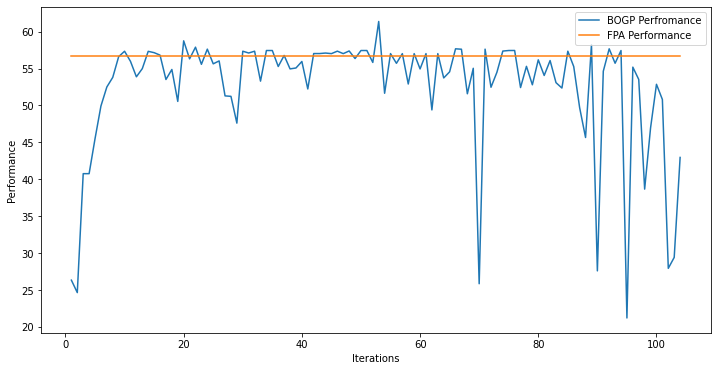

x_next is [ 39.95861434  39.79572052  39.28774965  15.94315844  39.06584
  -9.87026148  39.66126128  37.81790549  39.94408055 -30.49348392
 -30.84912734  39.86202132  39.90948503  39.88015704  -6.5505603
  38.5804249   39.90033079  37.74347733  39.10356891  39.80441665]
f()=55.324224, actual=54.671
103


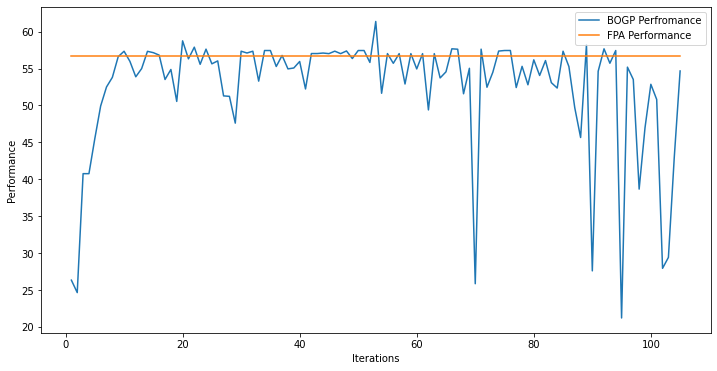

x_next is [-21.51893405   9.45060776 -13.93415661  -9.2380606   -7.44306439
 -12.19702919  27.05720787  27.21964168   0.57059173  35.66223101
 -28.27588367  21.37125098  -6.69071427  -5.46879491   3.10413177
  22.84717631  18.42532732  28.37468132 -20.69747177  10.20968519]
f()=52.542187, actual=25.307
104


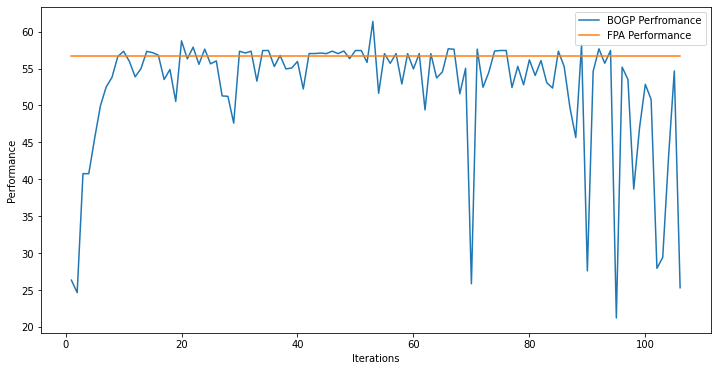

x_next is [ 39.90777728  39.8435715   39.95071059  -4.20576298  39.78214862
  38.67041107  39.76447213 -24.31795442  38.46360148 -30.73640874
 -30.95204735  39.8837841   39.72007688  39.69021369  39.93377553
  39.30996702 -30.05454006  37.78134166  39.68413007  39.14146647]
f()=51.463218, actual=52.268
105


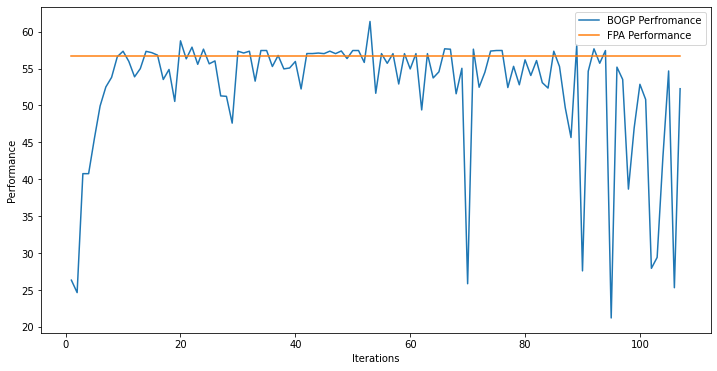

x_next is [ 40.          40.          40.          40.          40.
  40.          40.          40.          40.         -30.99973206
  40.          40.          40.          40.          40.
  40.          40.          40.          40.          40.        ]
f()=58.381828, actual=57.349
106


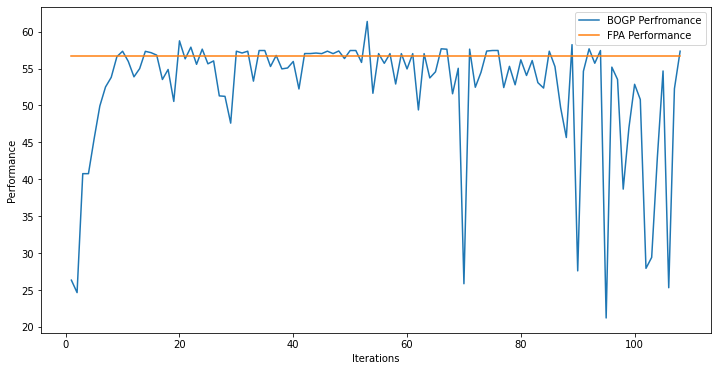

x_next is [-27.6001824   34.0128069  -13.31670441  18.19814241  24.49960388
  36.97543    -19.33851136 -24.55328047   8.28788674 -21.47748641
  -1.79248201  22.37054248   9.89322034  28.60328206  12.72822678
   1.80716497   3.98737057  24.45388504   1.87355843 -27.34449963]
f()=0.000000, actual=31.007
107


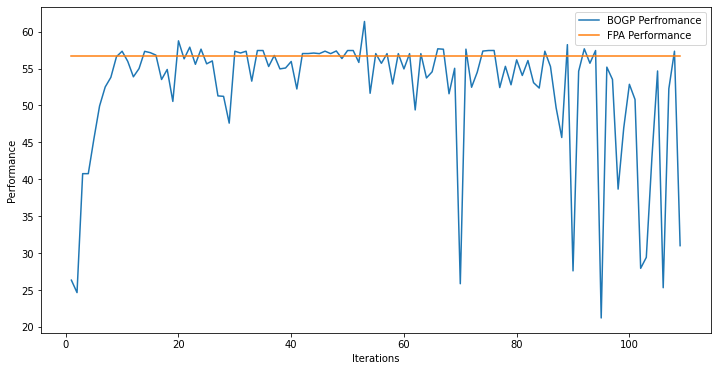

x_next is [ 39.91006982  39.44117698  39.75568619   4.76901459 -16.23648104
  37.31912864  38.99897655  38.10462456  39.49714787 -30.89724532
  39.06632035  39.34243723  39.8008296   39.53356088 -16.92196779
  38.78308027  39.30667164  37.9298741   31.3796263   36.38640489]
f()=54.495995, actual=54.232
108


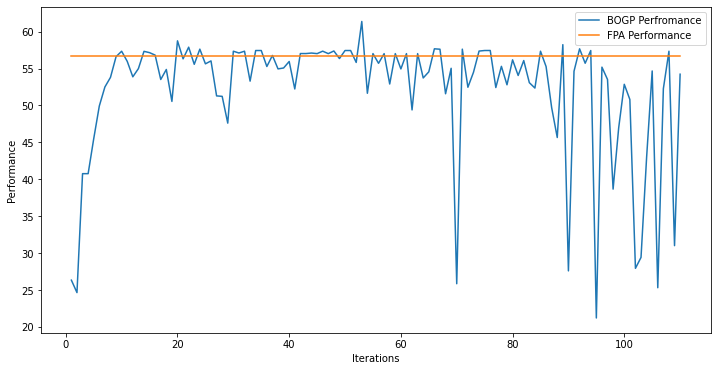

x_next is [ 39.86737301  39.12201866  39.76359176  34.480855    39.58800103
 -29.09107585  39.42475851  38.52221715  39.33238202  38.81697197
  39.74035775  39.54748144  39.78224591  39.37829669  39.69319704
  39.94393504  39.22805463  39.24009657  39.52606085 -30.4907652 ]
f()=50.251338, actual=52.087
109


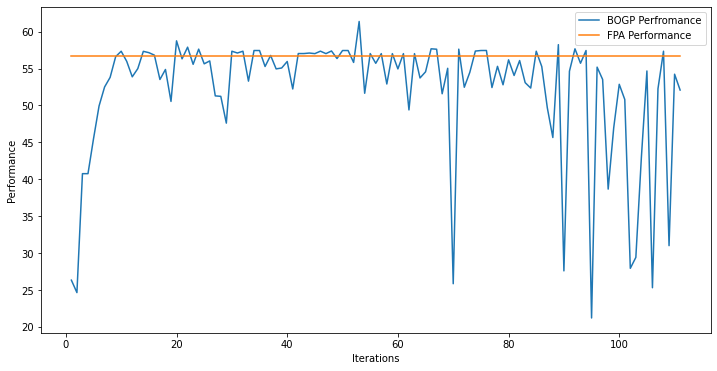

x_next is [ -6.95619076 -18.15703408 -17.77024492  14.95624337  10.87928562
   8.56066945  -9.75318202 -11.45845632  -0.39927195  29.53323017
 -24.5425632  -12.84933941  35.17929539  26.108253    33.52619957
 -10.40938371  38.19501554 -12.20998269  -2.52842136  21.1139735 ]
f()=52.153384, actual=33.059
110


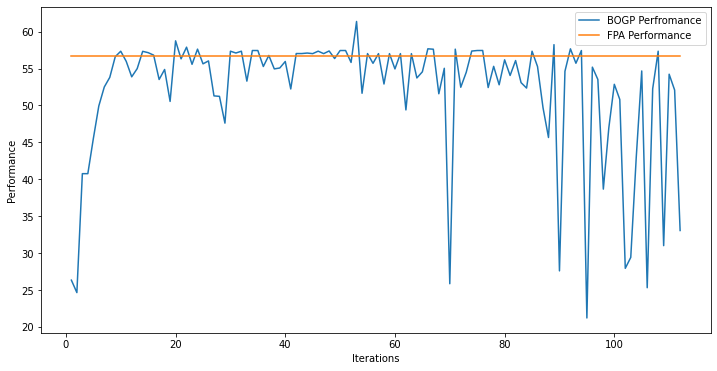

x_next is [ 39.99975286  39.99938397  39.99976661  39.9944275   39.99974291
  39.99996461  39.99934888  39.99901061  39.9991696  -30.99866018
  39.99286717  39.99841857  39.99866653  39.99986233  39.99974198
  39.99827446  39.99902936  39.9991752   39.99991957  39.99785195]
f()=58.507479, actual=57.351
111


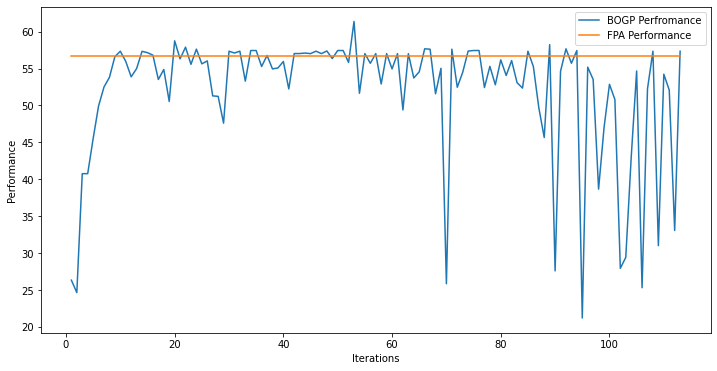

x_next is [ 39.88641441  38.54924845  39.67900898  10.97841065  39.46707925
  39.22504675  39.03334977  39.65212729  39.74929842 -27.86197062
  39.91844664  35.87917859  39.35990913  39.80893528  14.49697488
  36.9160163   39.25288973  39.05926519  39.31043111  10.38711922]
f()=58.266062, actual=52.859
112


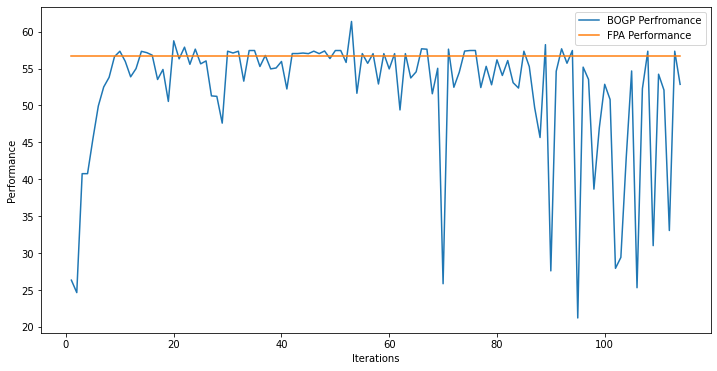

x_next is [ 39.90433924  39.55444291 -29.68110763  27.25068237  39.31577034
  39.85482499  39.96776881  38.18379682  38.74377595   1.6386864
  14.74764284  39.4933348   39.97337465  39.85564584  39.34781152
  38.89763969  39.19748789  -9.81991372  39.81855976  39.75490389]
f()=56.205067, actual=55.519
113


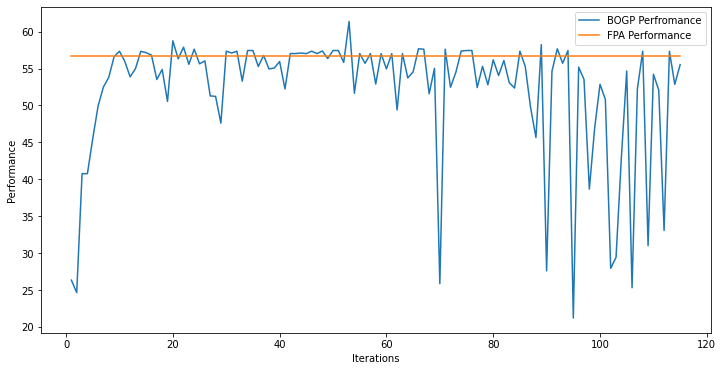

x_next is [ 39.32375573  39.16050541  39.956463    39.49060309  39.84645743
  39.04218927  39.86919973  39.88232801  39.86136476 -30.8147316
  38.91478516  38.50947609  39.4815487   39.80343486  38.41502125
  39.76585688  38.89466044  37.07822434  39.57278832  39.63183965]
f()=52.067766, actual=57.465
114


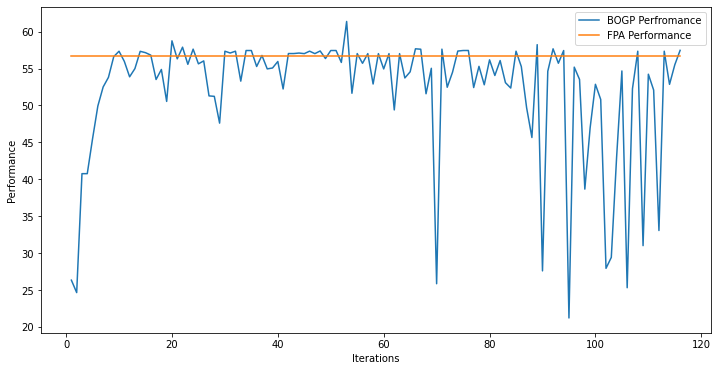

x_next is [ 39.9057286   39.9525359   39.20281603   4.62352342 -23.24002276
  39.64303331  39.6543485   -9.65700758  39.45741908 -26.2851147
 -30.2674233   39.87407142  39.88277708  39.34769732 -14.47015752
  39.1065772   39.81263498  39.27659165  39.8896201   39.99386112]
f()=53.231635, actual=50.216
115


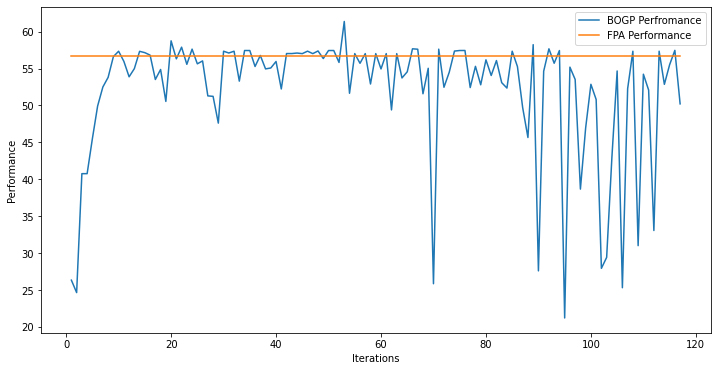

x_next is [ 39.64153592 -30.59503758  39.35245648  39.38535344  39.98683173
  39.54019376 -12.38343193  39.88818752  39.55699241  21.43536522
  38.65040767  37.48852384  39.57363402  39.8574659   39.845722
  39.91033778  39.61641043  38.53122016  39.43521606  38.40748229]
f()=53.397603, actual=56.663
116


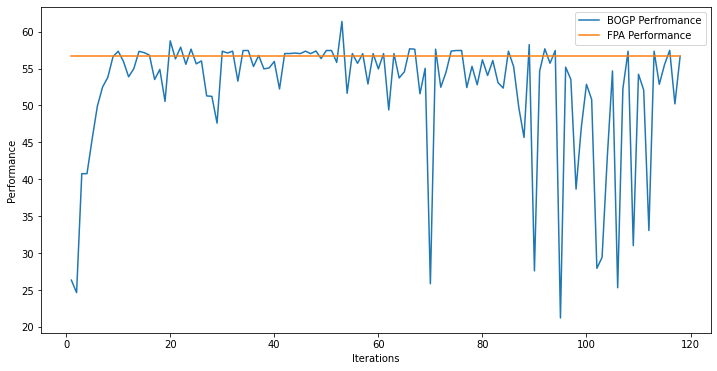

x_next is [39.76523227 39.77545027 26.26487415  5.49641705  7.85959344 39.10481414
 39.7936502  23.40465493 39.97735686 32.48693373 -1.29550418 39.30491851
 39.85014201 39.9894226  39.79997215 39.96024284 39.80979562 15.36389086
 39.89899762 38.51364488]
f()=57.831294, actual=50.460
117


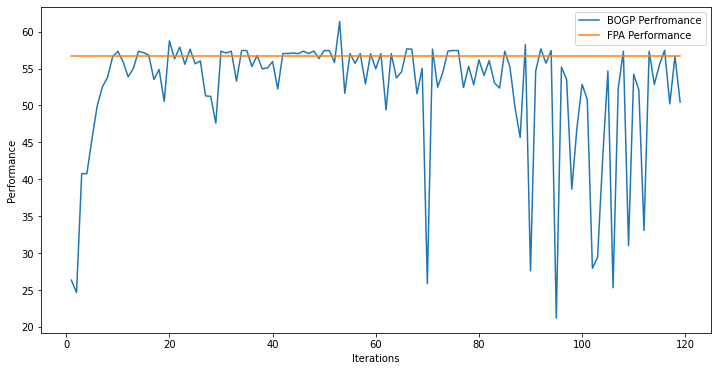

x_next is [ -6.93482774 -10.5233786  -10.90465552 -27.65974436  17.62704161
  10.89422574  -0.85432461 -15.91644659 -10.34616676  14.66890014
  -3.11835571  33.41452496   0.98715789 -27.65501879 -29.10339916
  23.01659801  34.69105529  30.22683058  20.1577747   -2.4536478 ]
f()=52.123005, actual=34.571
118


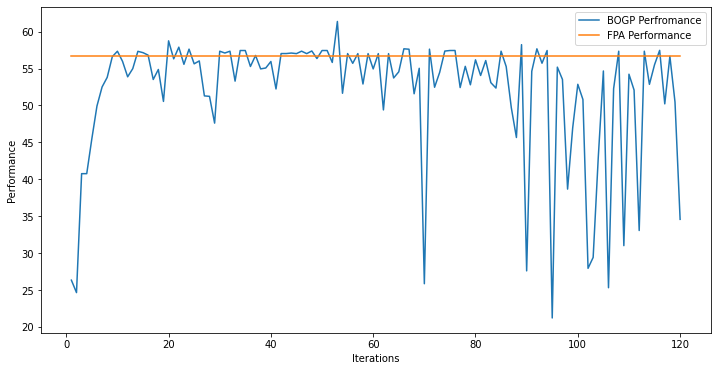

x_next is [ 39.90817383  39.78185651 -28.98705717  39.86891029  39.94719032
 -30.4734916   39.95763585 -30.53850712  39.81582208  39.18981684
   1.76866736  39.68007581  39.84109056 -27.89268817  39.62259366
  39.72002131  39.90238389  39.52715303  39.83407868  39.65751405]
f()=49.022632, actual=51.214
119


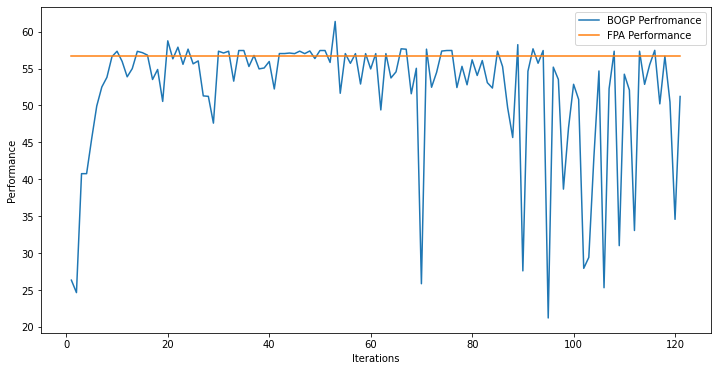

x_next is [ 39.97111012  39.89870154  39.1977828   39.29139387  39.4395021
  39.77231785  39.72912927  38.60698517  39.36750096 -30.50860694
  37.60163632  39.87766053  39.86710208  39.73682819  39.83809328
  39.06415635  39.98386387  39.95995755  38.64407511  39.02394647]
f()=51.970193, actual=57.739
120


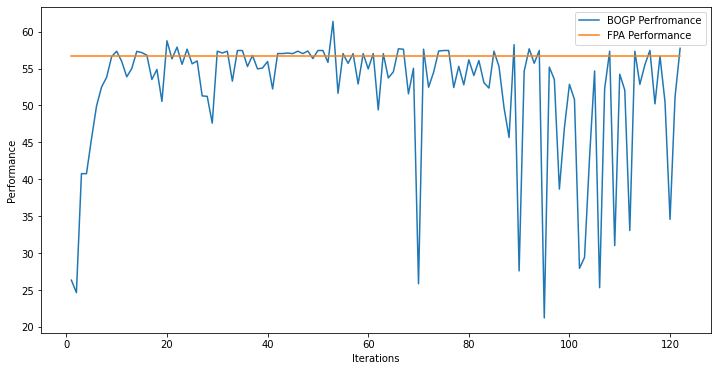

x_next is [ 13.82278475 -18.81338713 -23.27494028 -26.76262602  35.99056952
  21.81075651   4.22900692 -26.78687293 -12.21276755  -5.99944277
  13.0040341  -10.88865831  38.89472969 -22.34393357 -18.78157863
 -16.32637693  12.04782393  -8.63337922  32.9264701   -8.09504506]
f()=30.823152, actual=25.103
121


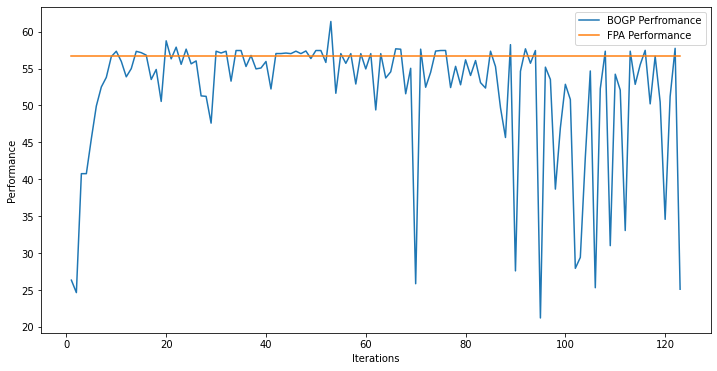

x_next is [40.         40.         -4.85436143 40.         40.         40.
 40.         40.         40.         18.65791724 40.         40.
 40.         40.         40.         40.         40.         40.
 40.         40.        ]
f()=57.734157, actual=58.734
122


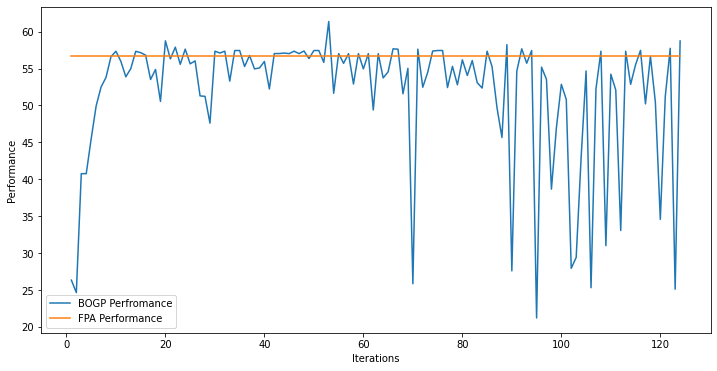

x_next is [  2.09647334   2.42597622 -24.25583063  15.56419315  17.78285034
 -10.36458589  -6.54021254 -13.40787093  32.16903511  -1.14400884
   9.2075404   -5.62122197   7.98639481  -0.42726927  -0.60492735
 -11.92359203  38.87984761 -14.50583908  10.27329348  16.24526988]
f()=51.853831, actual=26.597
123


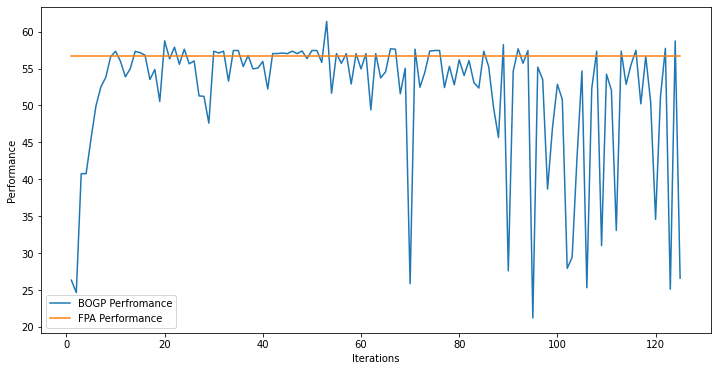

x_next is [39.99991939 39.99979036 39.99932678 39.99960277 39.99998003 39.9999657
 39.99951501 39.99869196 39.99937778 39.99918557 39.99937842 39.99993917
 39.99985534 39.99968651 39.99967637 39.99994664 39.99998227 39.99984351
 39.99987415 39.99974879]
f()=58.262539, actual=56.682
124


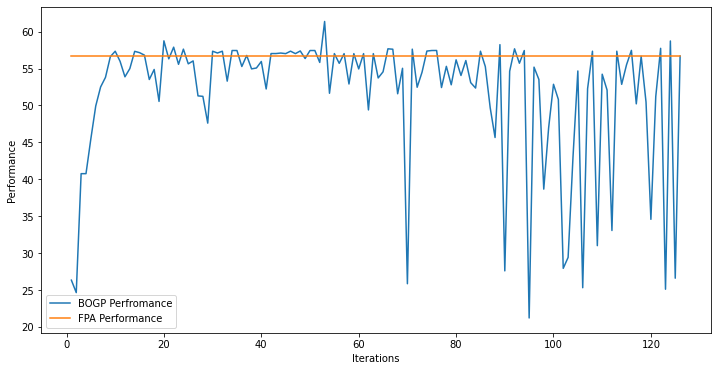

x_next is [ 39.29447138  39.26338465  39.55688821  38.70318623  39.91906495
  -5.71853054 -30.65232145  -1.10568712  39.38722328  -5.15788304
 -30.86321379  39.49629739  39.90705618  39.81889459  39.59430023
  39.94235089  39.42677704  39.97468315  39.36482805  39.88502279]
f()=52.935477, actual=51.762
125


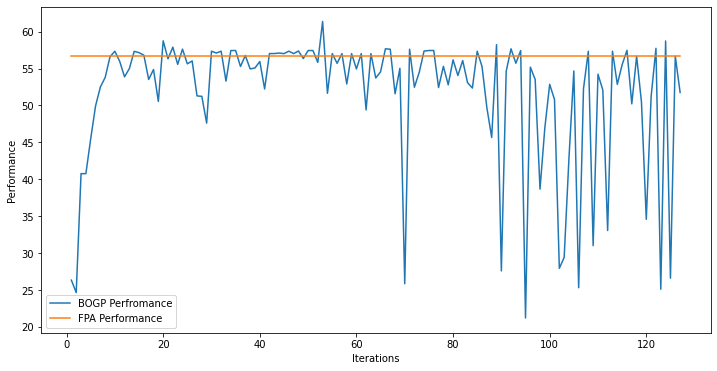

x_next is [ 39.71072299  39.9733741   39.54731388  38.57560455  39.2302269
  -2.89592075  39.78373713 -30.04629915  39.90185809 -25.82107836
 -30.83682665  39.98344046  39.85505973  39.78748107  39.72691603
  39.94952813  39.57997671  38.96769941 -12.31072586  39.35087681]
f()=52.912680, actual=52.860
126


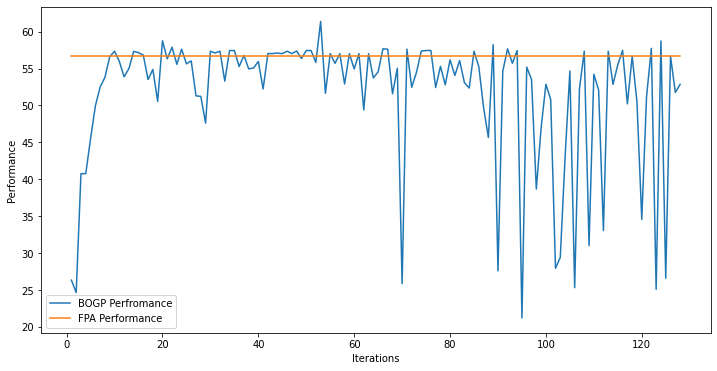

x_next is [ 40.          39.99999999 -11.79125981  40.          40.
  40.          40.          40.          39.99999994  18.97060647
  40.          40.          40.          40.          40.
  40.          40.          40.          40.          40.        ]
f()=57.874500, actual=58.795
127


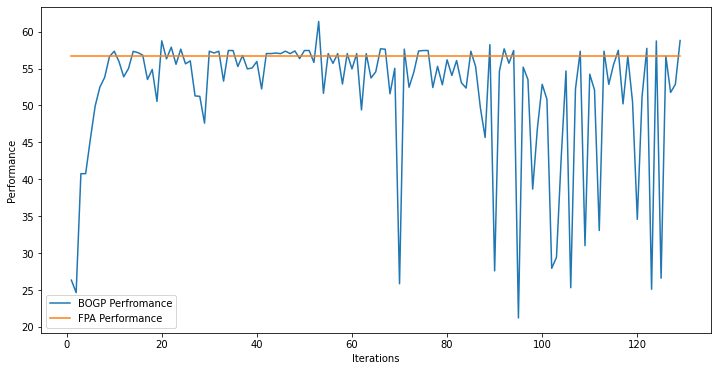

x_next is [ 40.          40.         -15.38444875  40.          40.
  40.          40.          40.          40.          20.96291949
  39.99999999  40.          40.          40.          40.
  40.          40.          40.          40.          40.        ]
f()=58.029901, actual=59.198
128


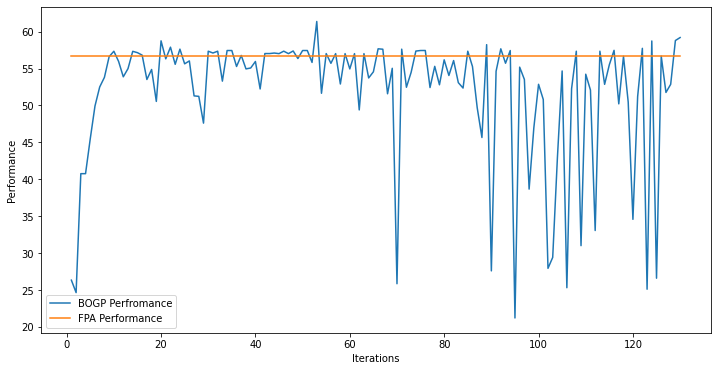

x_next is [ 39.94938524  39.87368234 -30.92169325  39.73499988  39.90942374
  39.77259204  39.86869242  -6.6579078  -27.42890084  39.89733643
 -30.95813983  39.7657428   39.92195378  39.85978333  39.93924948
  39.64612311  39.67844481  39.98409235  39.92231078 -16.05953666]
f()=51.067109, actual=51.670
129


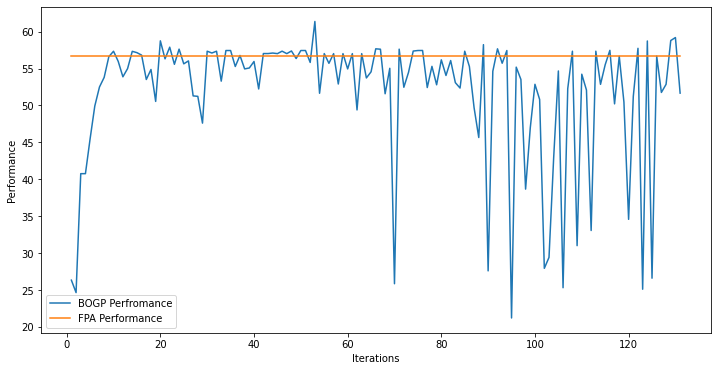

x_next is [ 39.74807839  39.38874632  39.71997761  38.37889196  39.50515545
  -9.6157553   39.95610559 -30.84816218  39.88210395  35.08967269
 -30.77856619  39.9077767   39.69336878  39.26824258  39.6242763
  39.92804207  39.86212046  39.81967201  39.98921753 -29.68489492]
f()=51.616499, actual=51.899
130


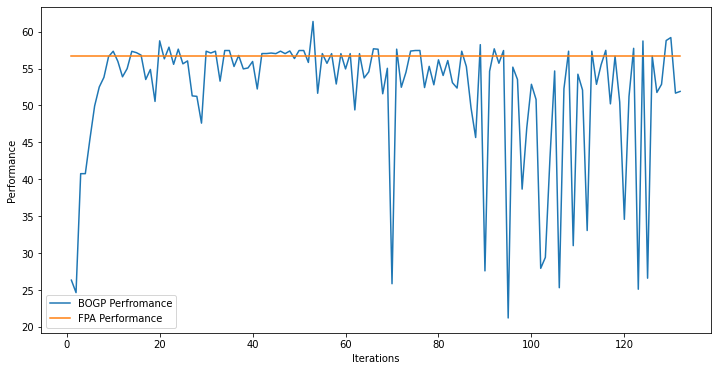

x_next is [ 34.90171813  39.88815312  34.48469905  39.82347608  39.00902826
  37.39228193  38.21483092 -26.32855962  38.51525214 -30.14842363
 -30.53312302  39.07630837  39.97665424 -27.68512125 -27.66791395
  37.87550355 -28.90005623  38.91247109  39.12892934  38.73474294]
f()=47.350256, actual=50.815
131


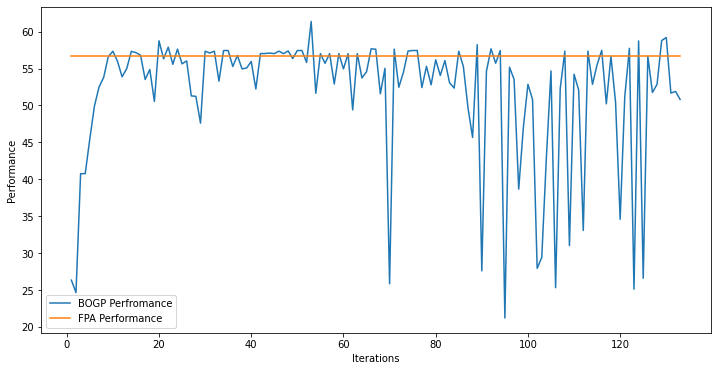

x_next is [ -7.48184177 -21.28402802   9.67538676  22.06802638  36.95132858
  -3.54763022  -5.40598278   7.13955878  22.78882478  15.92908855
 -19.09971902  14.25049906  -6.51958185  38.97942693  23.69234418
  24.80034045   9.2590105   32.91945696  -3.34495459   4.03291484]
f()=51.805588, actual=32.608
132


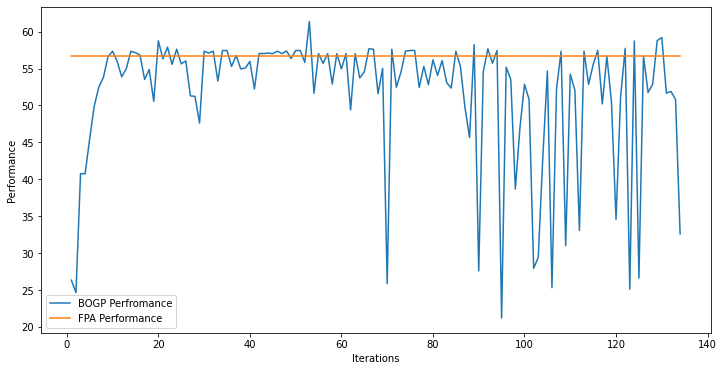

x_next is [ 39.99600713  39.93567307  39.96199584  39.71149982  39.91100566
  39.78924341  39.57762182 -28.94954158  39.64086309 -18.17744511
 -30.95234531 -29.70036227  39.95425005  39.70887587  39.55577861
  39.77274358  39.78142291  39.82849938  39.80719383  39.97879088]
f()=53.889769, actual=55.138
133


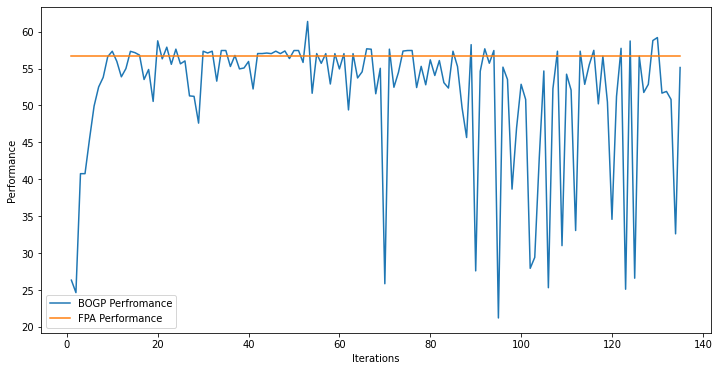

x_next is [ 39.59854178  39.73019062  39.91623792  39.95098075  39.79647616
  38.63947714  39.58900491  39.80707575  39.55601204 -26.1086384
  39.56740372 -30.54210305  39.5318234   39.09818137  39.57986943
  39.49710429  39.10619522  38.60152104  19.97786525  39.67973222]
f()=56.697548, actual=58.153
134


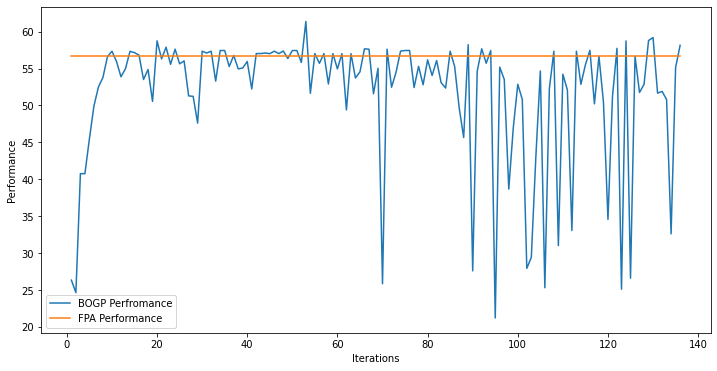

x_next is [ 40.  40.  40.  40.  40.  40.  40.  40.  40. -31.  40.  40.  40.  40.
  40.  40.  40.  40.  40.  40.]
f()=58.458575, actual=57.349
135


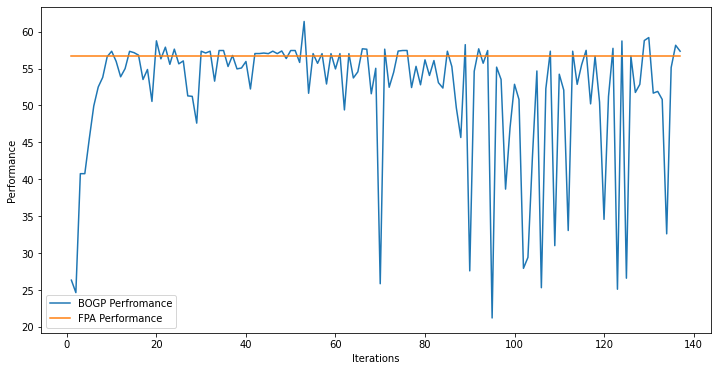

x_next is [ 40.          40.         -20.30743997  40.          40.
  40.          40.          40.          40.          20.48075882
  40.          40.          40.          40.          40.
  40.          40.          40.          40.          40.        ]
f()=58.250640, actual=59.100
136


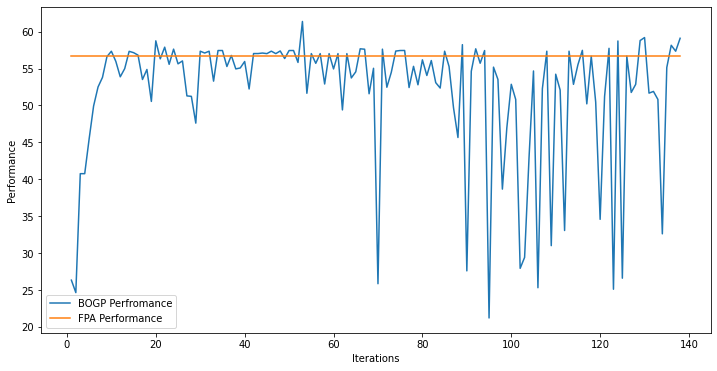

x_next is [ 39.36499844  39.6390935   38.26715746 -15.83030698  35.75002583
 -23.60459728  33.87370509  34.0777002   26.5275895   14.31545115
 -29.77484264  36.80589047  39.27207051 -22.10993534 -28.92250594
  33.61630143 -28.62616689  39.66715951  37.54958967 -29.43959685]
f()=42.238559, actual=45.291
137


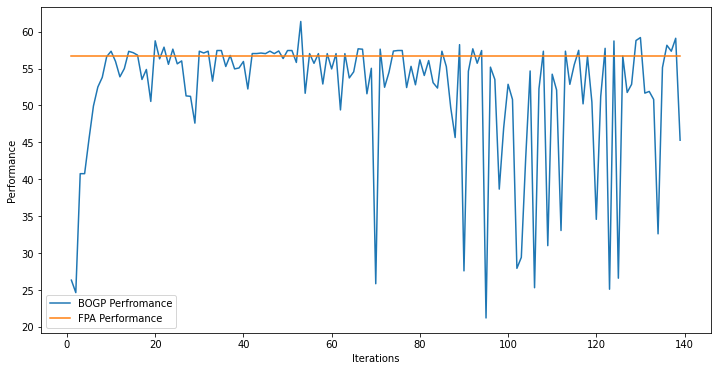

x_next is [-14.11796349 -12.59296202  39.8227769  -22.8037001   36.01161314
  23.07848486 -20.56061095 -15.25459137  26.03524635 -19.58717652
  20.81872898 -23.31574396  22.08909037  24.06689858 -26.58124996
  37.16411538  39.09667185  37.98488296  16.38745998  16.8045596 ]
f()=51.782515, actual=36.876
138


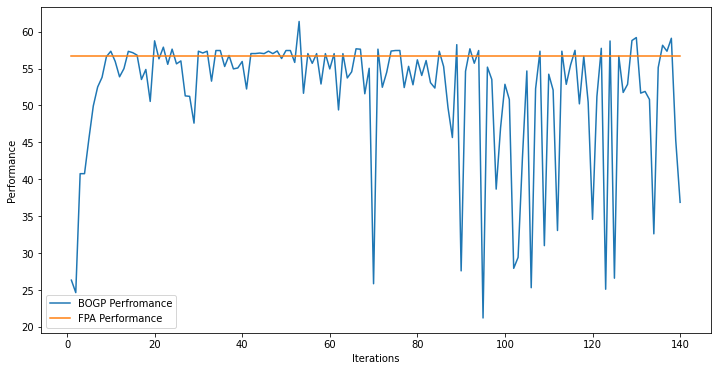

x_next is [ 39.98386731  36.35211033  36.27762672  34.13965588 -30.52869886
  39.82378866  39.59723752 -23.95850944 -30.33566708  39.99353619
 -28.48671548  39.23011272  39.27027399 -30.16710608  38.58268875
  39.69624459 -27.84930216  37.17429939  35.63448119 -24.21476334]
f()=43.566381, actual=45.893
139


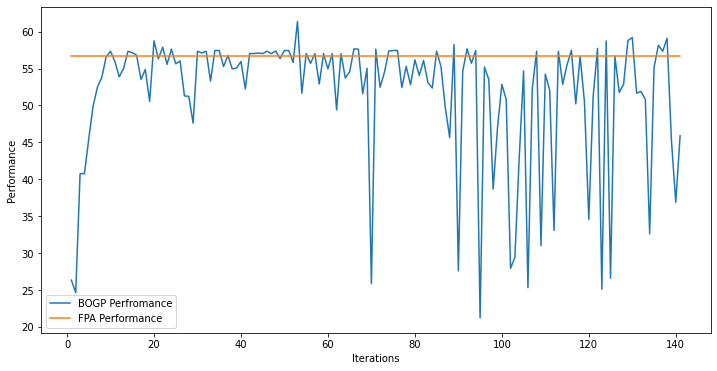

x_next is [ 39.92935312  39.84228856 -30.76194213  39.09930779  39.64461422
  -3.19656369  39.11860643  39.53418262  39.46470561  39.60011387
  39.61555252  39.38466769  39.6902559   39.76199407  39.47351216
  39.64427371  39.96215845  39.20753527  38.26521817  39.15944646]
f()=57.920499, actual=53.667
140


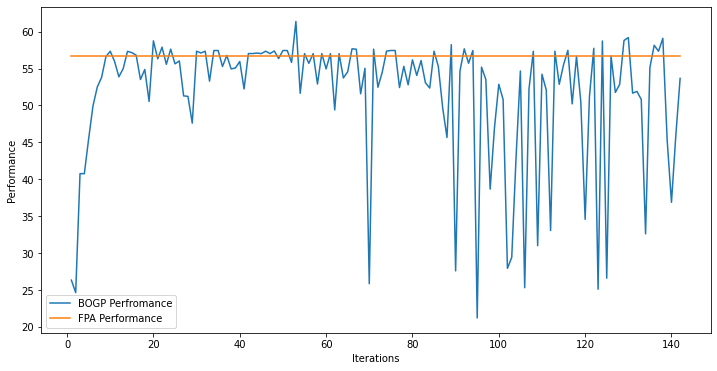

x_next is [ 39.59287964 -30.62205194  39.95554493  23.4374127  -30.15537643
  39.52627514  39.57391367  39.30256443  39.67594766 -29.64973227
  39.83471721  39.43375912  39.92202377  39.43120892  39.69435979
  39.98906594  39.8066631   39.86758661   0.10425514  39.56060304]
f()=52.472783, actual=50.651
141


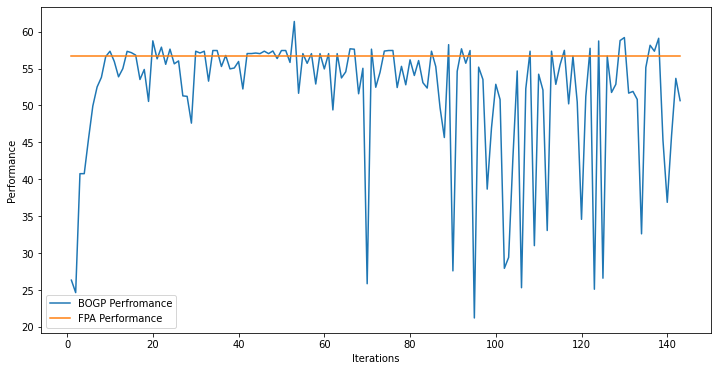

x_next is [ 39.73889264  39.66429244  39.8694673   30.25972049  39.81333684
  -1.33432487  39.98983069   2.85497923  39.53256935 -29.92168076
 -30.42037445  39.54888248  39.83259791 -30.58082376  39.85651768
  39.45031818  39.70803882  39.61083248  39.96482093  39.58182671]
f()=54.233299, actual=51.741
142


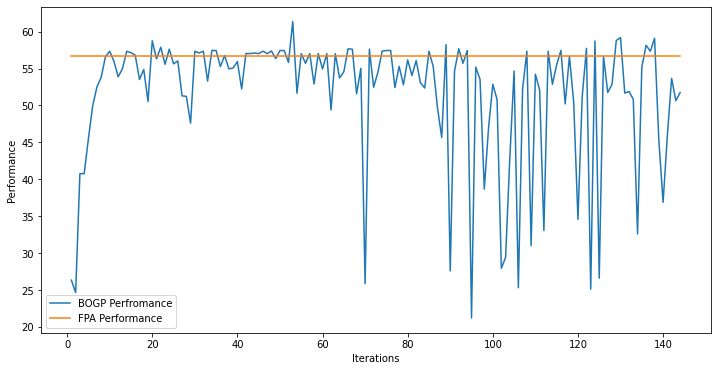

x_next is [ 39.95258653 -29.62254855  39.33859308  37.40903711  39.35649217
  39.77597624  39.91979879  38.49709771  39.7875696   39.07532374
  39.39443868  39.64883745  39.70412029  -5.8341608   39.4910994
  39.77825432  39.65670516  39.67228622  39.08058952  39.32846494]
f()=55.370710, actual=56.429
143


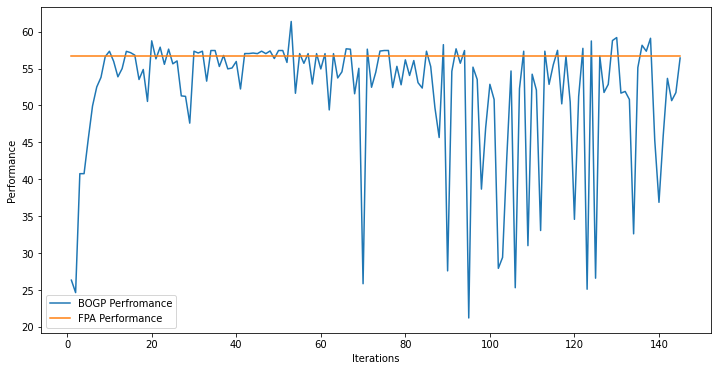

x_next is [ 40.          40.         -12.0175172   40.          40.
  40.          40.          40.          39.99999998  11.62122039
  39.99999998  39.99999999  40.          40.          40.
  40.          40.          40.          40.          40.        ]
f()=58.196114, actual=57.650
144


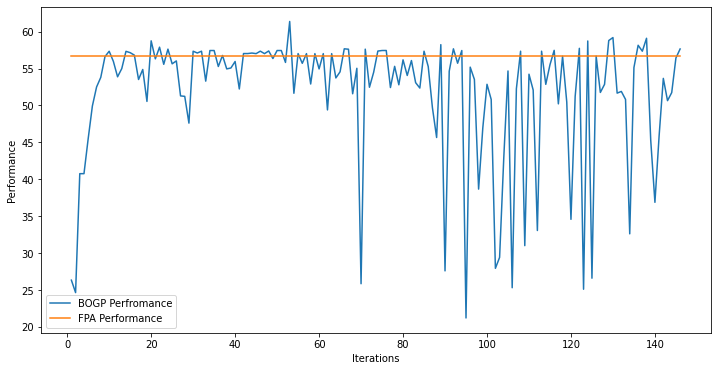

x_next is [ 39.79325377  39.92735702 -30.87214721  39.1275537   39.90978299
  39.7315361   39.37868234 -10.22168244  39.64110845 -29.94493706
  34.51516317 -29.83532677  39.65161828  39.75754078  39.11835556
  39.70448234  39.42112976  39.97398449  39.41177483  39.61302417]
f()=54.140199, actual=55.077
145


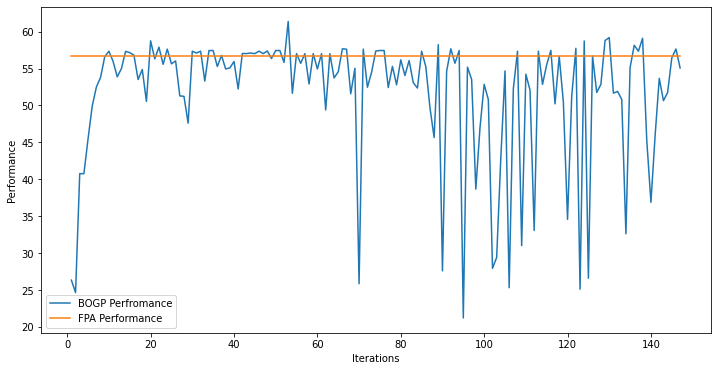

x_next is [ 39.92931834  39.24545344 -30.86994997  39.53230627  39.87335935
  38.44642811  39.9340185    3.72064095 -14.21134341 -29.50433778
 -29.23130654  39.88514375  39.79747542  39.78855162 -30.896237
  39.66668041  39.92012685  39.654269    39.86961924  39.5225849 ]
f()=52.293333, actual=55.068
146


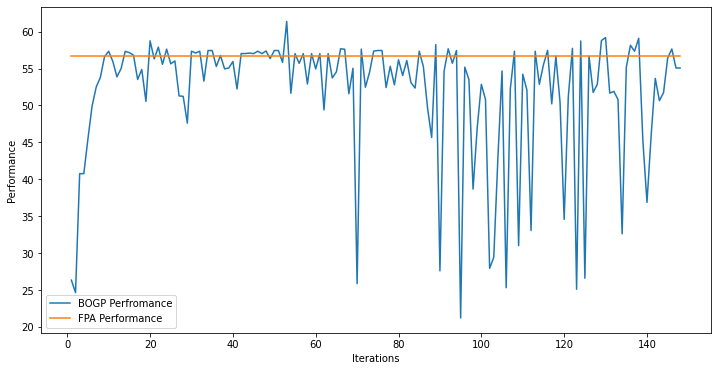

x_next is [ 39.94197113 -23.30858517  39.53532473  38.38160034  39.89261304
  39.71021103  39.94060784 -30.33870989  39.83087568  39.48055423
  39.87158928  39.96390522  39.57315776 -30.69602589  39.89054135
  39.98464913  39.77990594  39.79192881  39.9114221  -13.51218403]
f()=50.720207, actual=51.223
147


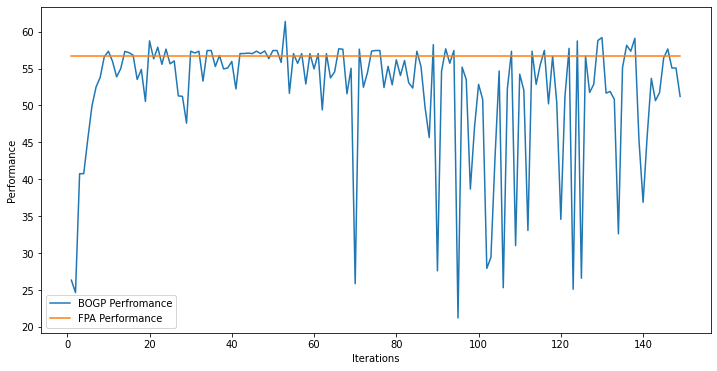

x_next is [ 39.72892907  39.53735279 -30.44726299  38.77183939  39.77212698
  39.45394957  39.63145904 -29.32438398  39.93081274  39.92309834
  39.99276272  39.84489284  39.94214536  -7.61764578  38.65353849
  39.48640112 -29.53785315  39.34151276  39.93326882  39.39968529]
f()=50.122482, actual=51.753
148


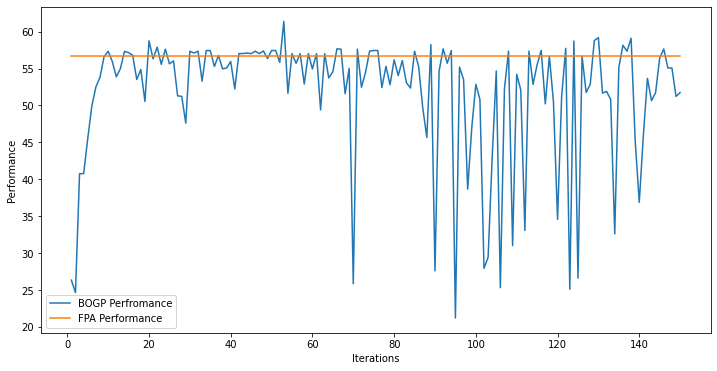

x_next is [  4.3698491  -26.34403714  17.92010909 -25.00918733   9.80502919
   8.07868112  19.88669567  35.42878285   7.18766271 -13.53237843
 -19.05279087  30.47071708 -26.10645091   2.9890693   -4.74180656
  25.4177401   34.25135281  -9.23224949  37.54334709  -6.82691765]
f()=51.759093, actual=27.427
149


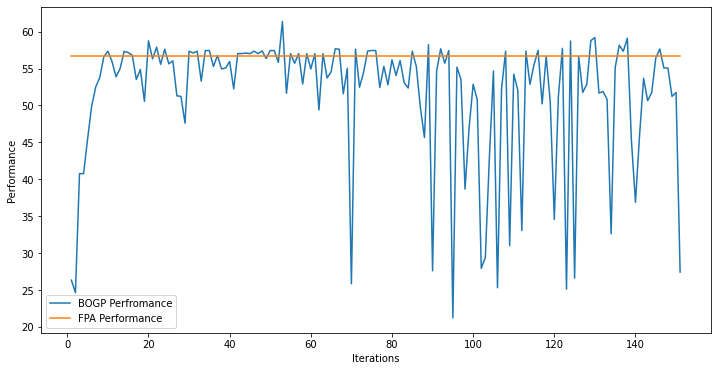

x_next is [ 40.          39.99999999 -11.8092957   40.          40.
  40.          40.          40.          40.          11.38663434
  39.99999999  40.          40.          40.          40.
  40.          40.          40.          40.          40.        ]
f()=58.110547, actual=57.627
150


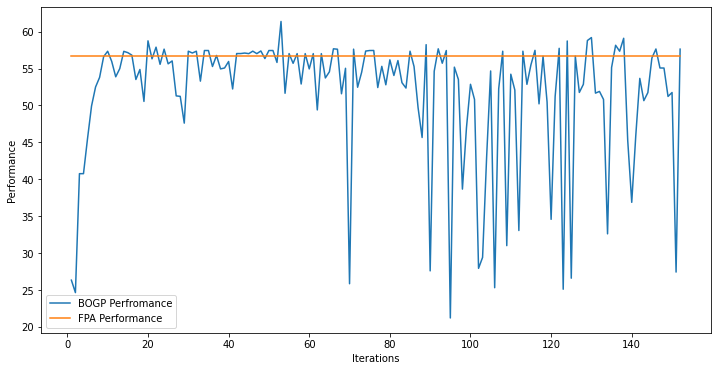

x_next is [ 38.37144005  39.98070279 -30.28316708  32.26075516  38.54469467
 -21.61008558  33.80747844 -30.00049059 -27.91122686  37.25404352
 -21.70300886  39.03292953  36.78291241  26.88248196 -30.59520432
  34.56111759 -30.97374551  39.58789932  37.14305169  39.62630337]
f()=45.941405, actual=48.926
151


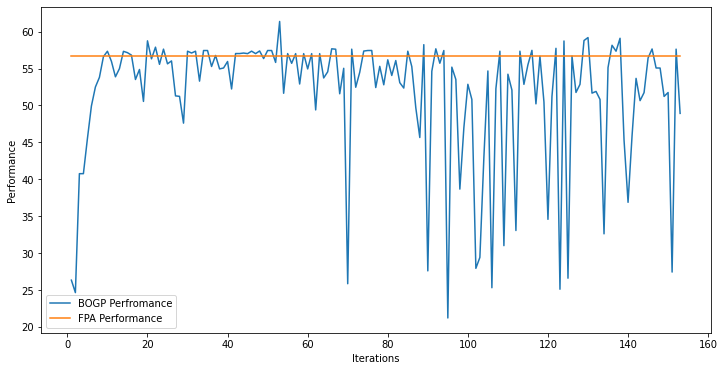

x_next is [39.68847611 39.9364732  39.275708   39.8158741  39.92534068 39.83319637
 39.89760242 38.28428495 39.26079031 35.44618919 38.9888995  39.60774567
 39.98137225 39.83760652 39.78958048 39.85096887 39.89960249 39.93726564
 39.70822892 39.76582469]
f()=58.069172, actual=59.054
152


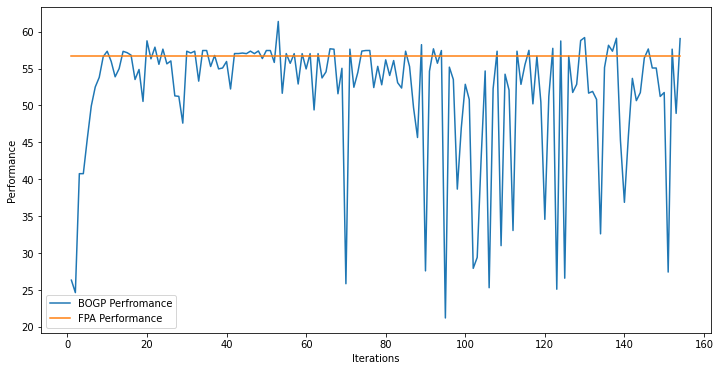

x_next is [ 39.55343697  39.98271929 -16.45828601  39.50012616  39.85266499
  39.91306612  39.85874247  11.10069216  12.14955484  35.92711321
  13.1669423   39.79774293  39.97628215   8.70556069   6.75696528
  39.73711804  39.49781289  39.95709079  39.73328305  39.95133957]
f()=58.290717, actual=55.014
153


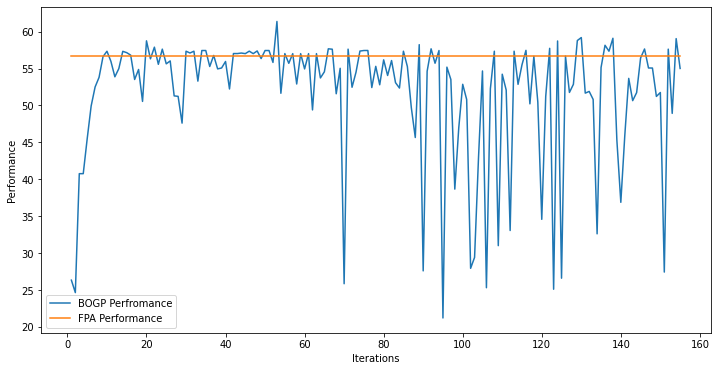

x_next is [ 26.05478275  37.70354499  28.22859381  34.14350101  20.77722262
  27.45861959  21.57021498 -24.17152931  27.24870678 -27.50980395
  25.297975    36.83410624  36.0857454    8.73562526  15.88799236
  39.86040138  21.35502756  39.3800533   27.03666335  35.26215399]
f()=48.701183, actual=47.208
154


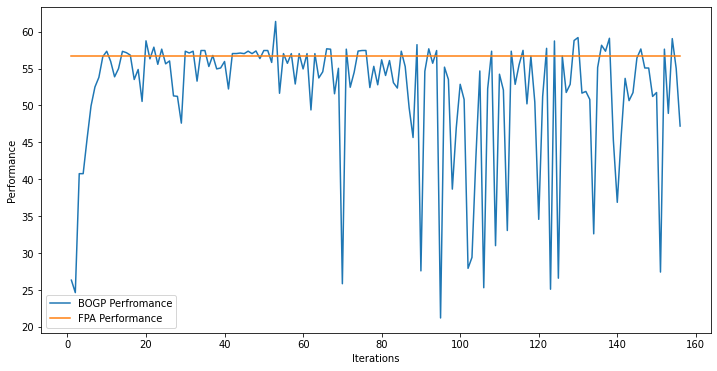

x_next is [ 39.9998201   39.99426612  39.99622396  39.99968363  39.99767737
  39.99971681  39.99948525  39.99918636  39.99592348 -30.9951824
  39.99897256  39.99955605  39.99971122  39.99988694  39.99901665
  39.99878409  39.99987434  39.99948718  39.99706448  39.99983059]
f()=51.660791, actual=57.348
155


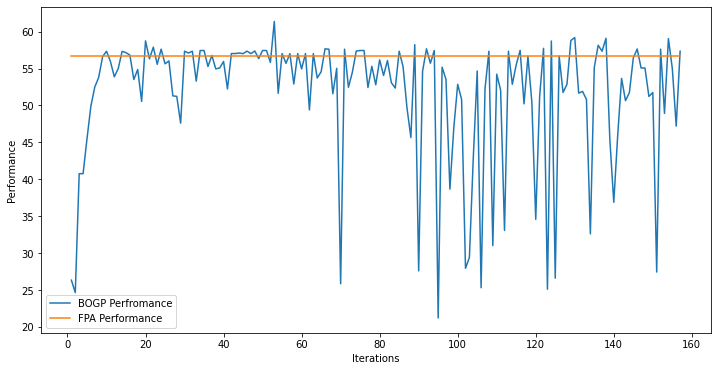

x_next is [ -9.35290825  39.92256706  17.90413589  22.52596807  19.08927636
  37.66183547  25.39378266  35.85776698  30.23277755   9.84149053
 -10.15161056  29.77377284 -22.32901399 -10.32473611  14.19920552
  -7.1601606    9.56538815  39.66633164  31.80634353  24.73037611]
f()=36.671074, actual=40.651
156


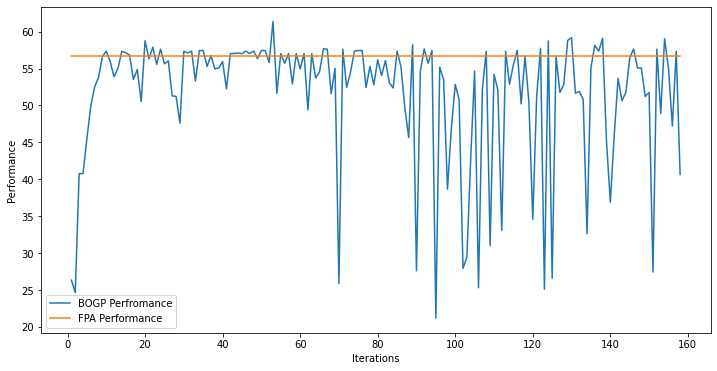

x_next is [ 39.58746984  39.91225351 -30.919832    39.7207911   39.67448207
  39.08548655  39.99064918  15.5056063   38.48310096 -30.8622465
 -30.90079372  39.99835702  39.97385415  39.76096918 -20.48537349
  39.73375916 -25.22732858  39.75552418  39.46553094  39.32772526]
f()=53.330425, actual=53.156
157


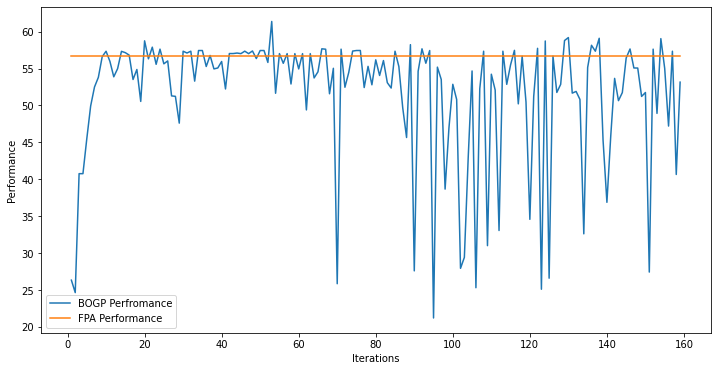

x_next is [ 34.67656921   7.6203467   32.58239873  38.54795551 -17.15424518
 -20.69223602  22.1318832  -16.66214124  -6.4283924   19.23367029
  34.00970735  10.52472021 -21.98196327 -30.73469579 -26.09307519
  25.79382912  31.21006071  -1.55328434  15.3291545  -10.29202724]
f()=51.636771, actual=36.530
158


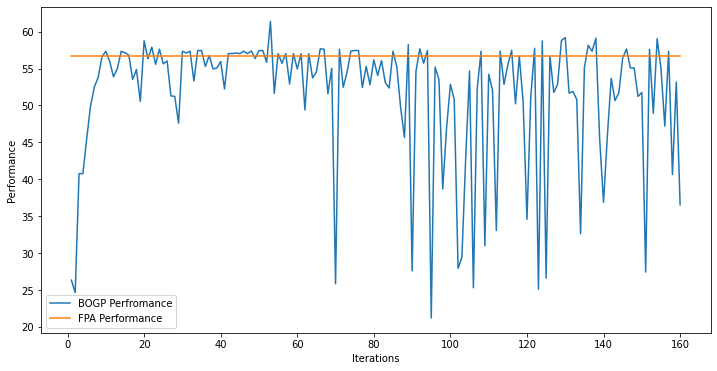

x_next is [ 39.88898736  39.99690131  39.1480458   32.81861165  39.83365273
  39.66093024  39.75993875 -30.58677458  -8.88585288  38.98546363
 -30.74801076  39.82584824  39.88605285  -1.37793376  39.65791269
  39.94109845  -7.11664581  39.99913798  39.86360751  39.58142897]
f()=53.172587, actual=53.335
159


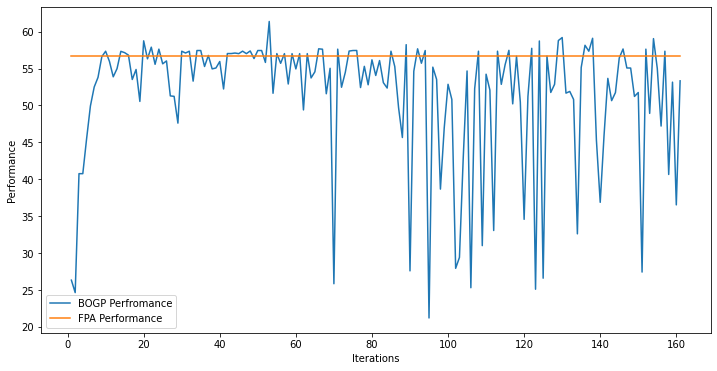

x_next is [  0.88978165   9.01988089  18.16020567 -21.14109046 -13.99709193
  33.74080922  24.57818929 -28.80382513  25.43487735 -11.09613168
   6.38810361   1.56524358   7.99742085 -27.73399396  19.42341495
 -14.23750749   2.40366412  16.31980358  -2.85087508 -23.65111169]
f()=51.553412, actual=27.187
160


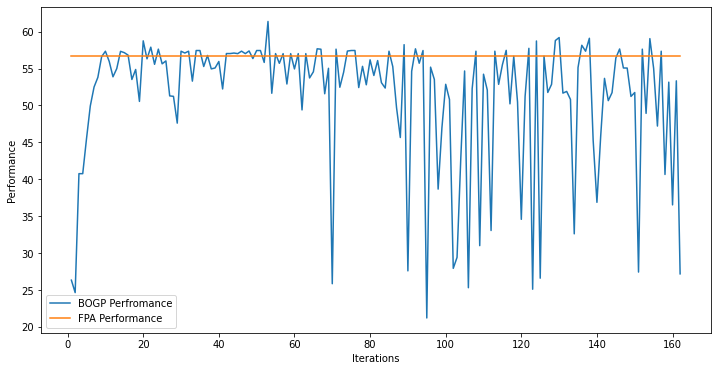

x_next is [40.         40.         -9.89492263 40.         40.         40.
 40.         40.         39.99999999 12.44738542 40.         39.99999999
 40.         40.         40.         40.         40.         40.
 40.         40.        ]
f()=58.094412, actual=57.740
161


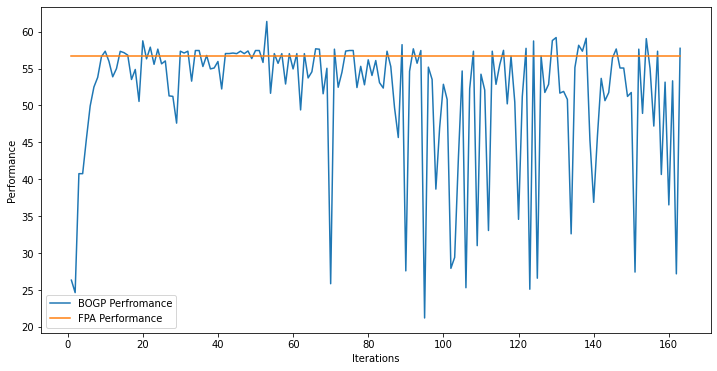

x_next is [ 17.6251305    3.5896003    4.90714299 -10.74884905  11.40058477
 -12.89299624  32.82389249  14.27294981  32.94337166  -5.71460907
  15.45251625 -26.43955113  36.97787536 -11.05342465  17.08822778
  16.63703274   1.06544997  -8.59760375  -6.99070364  34.55938002]
f()=32.150117, actual=26.940
162


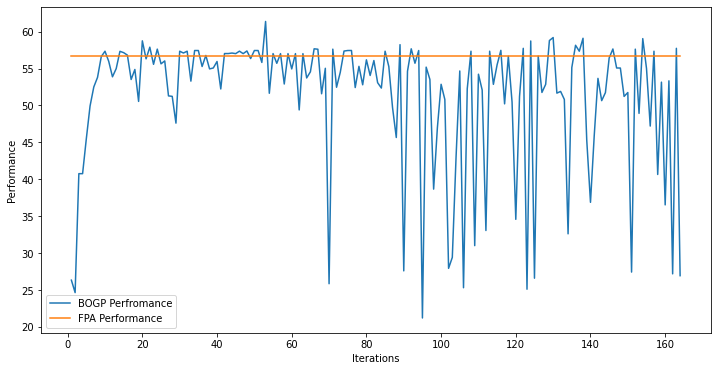

x_next is [ 39.79809038  39.68257973  39.9979198   23.27895417  39.94976157
  38.80921543  39.68642208   1.10455829 -30.68055658  -4.72036866
 -30.72389659  39.81820743  39.87973616  39.47475513 -30.08361603
  39.71785686  -1.97416895  39.96851876  39.54540257  39.65917238]
f()=53.683304, actual=52.925
163


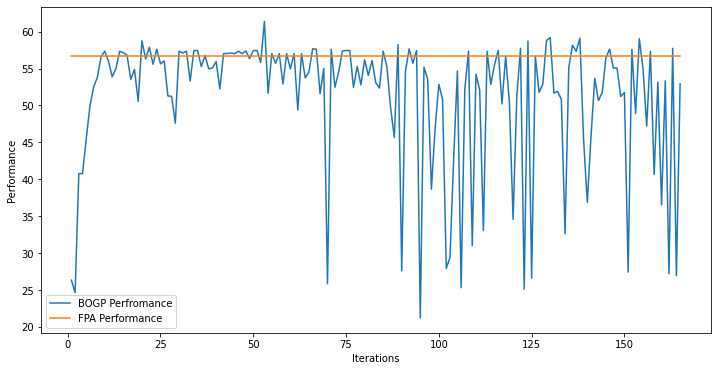

x_next is [ 18.56429214  35.378398    -8.57221158  21.86056773  -7.92767759
 -27.76767168 -17.35330791  38.90720174  14.68802973 -20.87800368
  21.24583485  33.10949788  17.29895018  12.12364337 -30.5956347
  30.16989329  35.17150367  -3.6281904   36.72199344  37.2831343 ]
f()=51.301665, actual=37.759
164


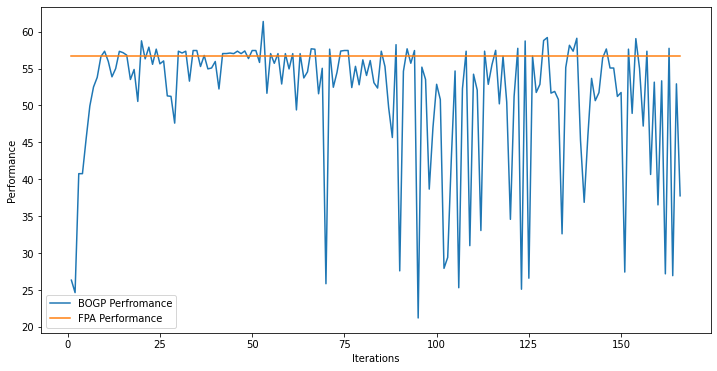

x_next is [ 39.66786764 -30.53208159  39.53966575  23.33954405  39.96856967
  39.75718061  -0.46169697  -5.37335924   6.35734282  39.39752335
  19.6466041   39.87920309  39.9144609   15.98762409  39.75489477
  39.9041099   39.928569    39.7522896   39.7454439   39.68333913]
f()=54.118289, actual=51.431
165


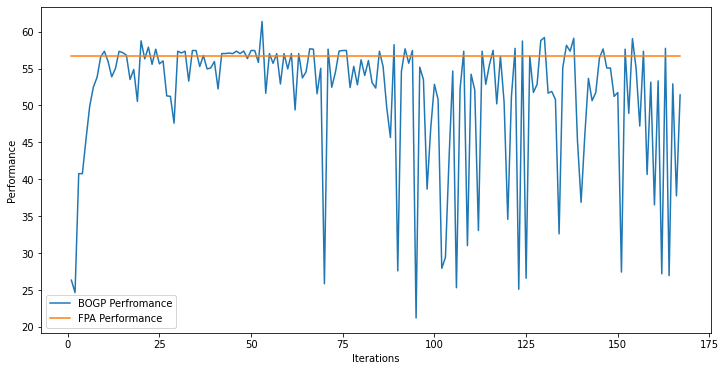

x_next is [-10.84161344  31.50652162   6.32251025   9.56201679  39.25710829
   1.10096139 -30.88327194 -22.14018592  20.56390554  17.68522873
  30.02140588  -3.19904542  20.12081049 -14.27249846   4.24029894
   5.21832169  32.53043778 -26.61157235  34.16458558  27.40793688]
f()=30.834492, actual=36.573
166


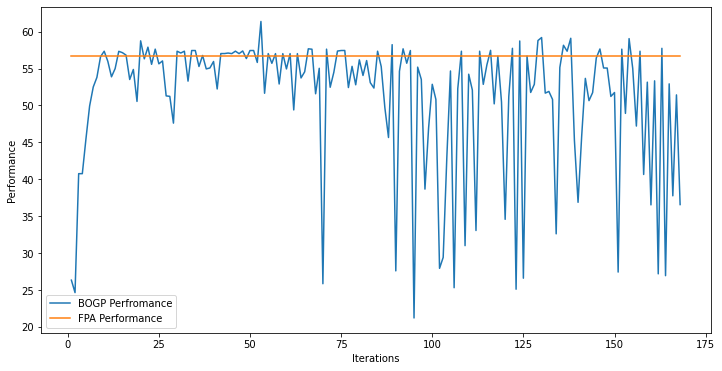

x_next is [  2.14926063   9.1368594   13.13662934  39.6123733   21.34438373
  28.61052842  37.76698057  -4.08195311  36.30006563  14.27047031
   4.90044214  13.52267319  22.2451207   30.43423517  -3.08020618
 -17.41347636  -2.271677   -27.03890088  34.99633178  -0.1107146 ]
f()=51.134017, actual=38.048
167


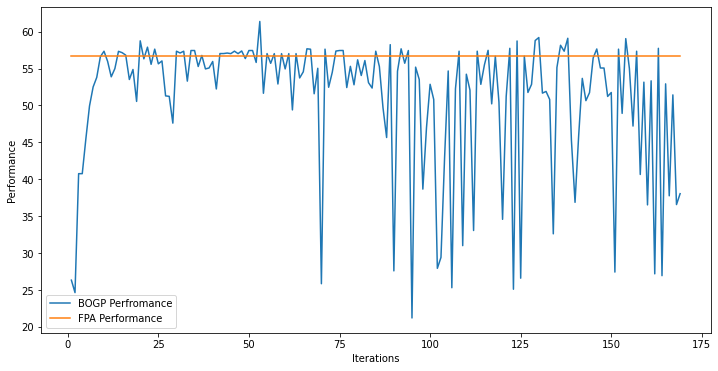

x_next is [ 39.97108737  39.99844903  38.85073319  37.55092153  39.99168166
  38.80141825  39.98657644  10.11370663 -21.42002446   3.90408749
 -30.56487856  39.20969553  39.94158732  38.87219299  39.65147324
  39.75415729  38.910271    17.85832866  39.85028396  15.63997703]
f()=56.676294, actual=50.675
168


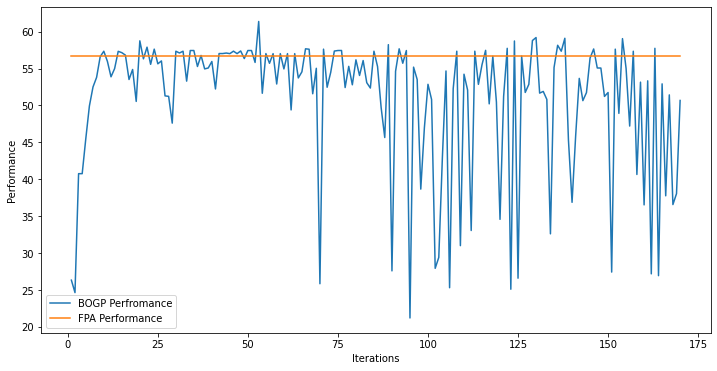

In [ ]:
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

X = 0 * np.ones([1,var], dtype = "float")
y = np.array([[objective_FPA(X[0].reshape((int)(var/number_of_cells), number_of_cells))]])

tr_FPA = objective_FPA(P_max * np.ones([1,var], dtype = "float").reshape((int)(var/number_of_cells), number_of_cells))
y_FPA = np.array([[tr_FPA]])

kernels =  ConstantKernel(constant_value=200, constant_value_bounds = (1e-20, 1e20)) * Matern(length_scale=1, length_scale_bounds=(1e-20,1e20), nu=1.5) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e20)) 
model = GaussianProcessRegressor(kernel = kernels, n_restarts_optimizer=30)

model.fit(X, y)

for i in range(200):
  x_next = opt_acquisition(X, y, model)

  np.save("/content/drive/MyDrive/trainingx_BOGP_EI_P=40.npy",X)
  np.save("/content/drive/MyDrive/trainingy_BOGP_EI_P=40.npy",y)
  np.save("/content/drive/MyDrive/grad_trainingyFPA_BOGP_EI_P=40.npy",y_FPA)
  
  tr = 0
  for l in range(1):
    tr = tr + objective_FPA(x_next.reshape((int)(var/number_of_cells), number_of_cells))
  tr = tr/1.0  
  actual = tr

  tr_FPA = objective_FPA(P_max * np.ones([1,var], dtype = "float").reshape((int)(var/number_of_cells), number_of_cells))
  
  est, _ = surrogate(model, [x_next])
  print("x_next is", x_next)
  print('f()=%3f, actual=%.3f' % (est, actual))
  
  X = vstack((X, [x_next]))
  y = vstack((y, [[actual]]))
  y_FPA = vstack((y_FPA, [[tr_FPA]]))
  
  model.fit(X, y)

  print(i)
  pyplot.figure(figsize = (12, 6))

  pyplot.xlabel("Iterations")
  pyplot.ylabel("Performance")
  pyplot.plot(np.arange(1,X.shape[0]+1),y[:])
  pyplot.plot(np.arange(1,X.shape[0]+1), y_FPA[:])
  pyplot.legend(["BOGP Perfromance","FPA Performance"])
  pyplot.show()






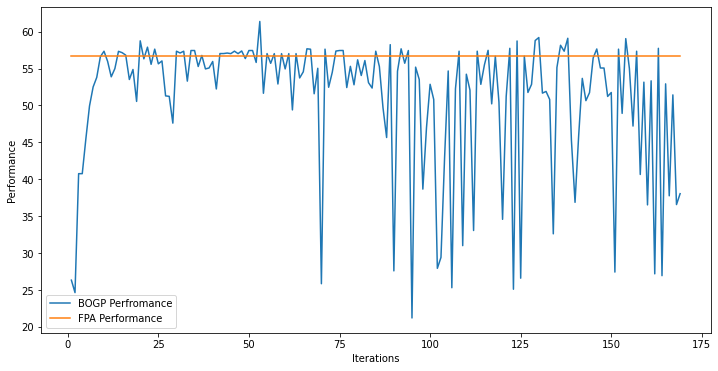

P_max = 40.000, Optimal_SE = 61.378
P_max = 40.000, Optimal_SE_FPA = 56.682


In [15]:
pyplot.figure(figsize = (12, 6))   
pyplot.xlabel("Iterations")
pyplot.ylabel("Performance")
pyplot.plot(np.arange(1,X.shape[0]+1),y[:])
pyplot.plot(np.arange(1,X.shape[0]+1), y_FPA[:])
pyplot.legend(["BOGP Perfromance","FPA Performance"])
pyplot.show() 
ix = 0
ix = argmax(y)
print('P_max = %.3f, Optimal_SE = %.3f' % (P_max, y[ix]))

ix_FPA=0
ix_FPA=argmax(y_FPA)
print('P_max = %.3f, Optimal_SE_FPA = %.3f' % (P_max, y_FPA[ix_FPA]))

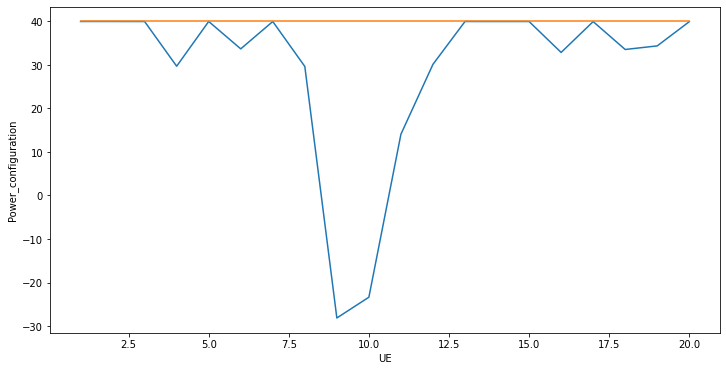

Power_configuration_BOGP is [ 39.99633204  39.99601107  39.98813622  29.71710637  39.99773841
  33.7024698   39.98639671  29.66025765 -28.15128893 -23.37566701
  14.08108426  30.15497052  39.99524996  39.98999721  39.99243512
  32.88168831  39.96953444  33.56085485  34.38485207  39.94921816]


In [18]:
X_FPA = P_max * np.ones([1,var], dtype = "float").reshape((int)(20), 1)
pyplot.figure(figsize = (12, 6)) 
pyplot.xlabel("UE")
pyplot.ylabel("Power_configuration")
pyplot.plot(np.arange(1,21),X[ix][:])
pyplot.plot(np.arange(1,21),X_FPA[:])
pyplot.show()
print("Power_configuration_BOGP is", X[ix])

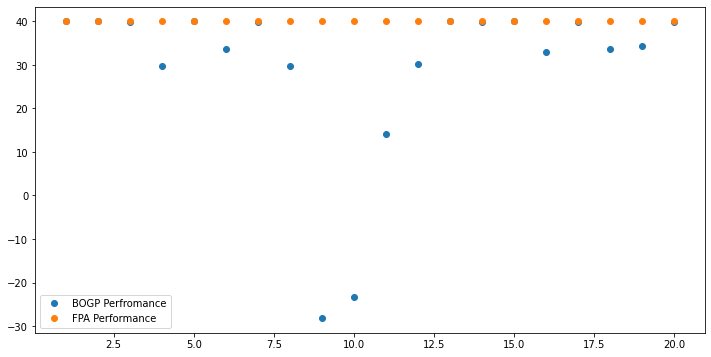

Power_configuration_BOGP is [ 39.99633204  39.99601107  39.98813622  29.71710637  39.99773841
  33.7024698   39.98639671  29.66025765 -28.15128893 -23.37566701
  14.08108426  30.15497052  39.99524996  39.98999721  39.99243512
  32.88168831  39.96953444  33.56085485  34.38485207  39.94921816]


In [17]:
import matplotlib.pyplot as plt
X_FPA=np.linspace(P_max,P_max,20)
plt.figure(figsize = (12, 6)) 
plt.plot(np.arange(1,21),X[ix][:], 'o')
plt.plot(np.arange(1,21),X_FPA[:], 'o')
plt.legend(["BOGP Perfromance","FPA Performance"])
plt.show()
print("Power_configuration_BOGP is", X[ix])